## **Libraries**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm

In [4]:
DATA_DIR = "/content/drive/MyDrive/Automatic Guitar Transcription/processed_data/cnn_ctc"

## **CTCDataset**

In [5]:
class GuitarSetCTCDataset(Dataset):
    def __init__(self, data_dir):
        self.files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".npz")]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = np.load(self.files[idx])
        mel = data["mel"]
        label = data["label"]
        input_len = data["input_length"][0]
        target_len = data["target_length"][0]
        mel = (mel - mel.mean()) / (mel.std() + 1e-6)
        return torch.tensor(mel.T, dtype=torch.float32), torch.tensor(label, dtype=torch.int32), input_len, target_len

In [6]:
def collate_fn(batch):
    mels, labels, input_lengths, target_lengths = zip(*batch)
    mels = [x.T for x in mels]
    mels_padded = nn.utils.rnn.pad_sequence(mels, batch_first=True)
    labels_concat = torch.cat(labels)
    input_lengths = torch.tensor(input_lengths, dtype=torch.int32)
    target_lengths = torch.tensor(target_lengths, dtype=torch.int32)
    return mels_padded.transpose(1, 2), labels_concat, input_lengths, target_lengths

In [7]:
dataset = GuitarSetCTCDataset(DATA_DIR)
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [8]:
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)

## **Model**

In [9]:
import torch.nn as nn

class CTCModel(nn.Module):
    def __init__(self, n_mels=128, n_classes=43):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv1d(n_mels, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            # MaxPool1d(2),  ← GEÇİCİ OLARAK YORUM SATIRI YAP
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU()
            # İkinci MaxPool da yok!
        )

        self.bilstm = nn.LSTM(
            input_size=256,
            hidden_size=512,  # Daha büyük kapasite
            num_layers=3,
            bidirectional=True,
            batch_first=False
        )

        self.classifier = nn.Linear(1024, n_classes)  # 512*2

    def forward(self, x):  # x: [B, n_mels, T]
        x = self.cnn(x)         # [B, 256, T]
        x = x.permute(2, 0, 1)  # [T, B, 256]
        x, _ = self.bilstm(x)   # [T, B, 1024]
        x = self.classifier(x) # [T, B, n_classes]
        return x

## **Train**

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CTCModel(n_mels=128, n_classes=43).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
ctc_loss = nn.CTCLoss(blank=42, zero_infinity=True)
best_val_loss = float('inf')
patience = 5
patience_counter = 0

In [11]:
history = {
    'train_loss': [],
    'val_loss': [],
    'val_sim': [],
    'val_token_acc': []
}

In [12]:
from difflib import SequenceMatcher

def seq_similarity(pred, target):
    return SequenceMatcher(None, pred, target).ratio()

def clean_decoded(seq, valid_range=(1, 42)):
    return [x for x in seq if valid_range[0] <= x <= valid_range[1]]

def token_level_accuracy(preds, targets):
    total = 0
    correct = 0
    for pred, target in zip(preds, targets):
        match_len = min(len(pred), len(target))
        for i in range(match_len):
            if pred[i] == target[i]:
                correct += 1
        total += len(target)
    return correct / total if total > 0 else 0

In [13]:
from collections import defaultdict
import heapq

def beam_search_decode(log_probs, beam_width=10, blank=0):
    """
    log_probs: (T, C) — time steps x classes
    Returns: decoded sequence (list)
    """
    T, C = log_probs.shape
    log_probs = log_probs.cpu().numpy()

    beam = [((), 0.0)]  # list of (sequence, score)

    for t in range(T):
        new_beam = defaultdict(lambda: -float('inf'))
        for seq, score in beam:
            for c in range(C):
                new_seq = seq + (c,)
                new_score = score + log_probs[t, c]
                if c == blank:
                    new_beam[seq] = max(new_beam[seq], new_score)
                else:
                    new_beam[new_seq] = max(new_beam[new_seq], new_score)

        beam = heapq.nlargest(beam_width, new_beam.items(), key=lambda x: x[1])

    best_seq = max(beam, key=lambda x: x[1])[0]
    decoded = []
    prev = None
    for c in best_seq:
        if c != blank and c != prev:
            decoded.append(c)
        prev = c
    return decoded

In [14]:
def sequence_accuracy(preds, targets):
    correct = 0
    for p, t in zip(preds, targets):
        if p == t:
            correct += 1
    return correct / len(preds)

In [15]:
for epoch in range(50):
    model.train()
    train_loss = 0

    for batch in train_loader:
        print(f"Batch size: {batch[0].size(0)}")
        break

    for batch in train_loader:
        mels, labels, input_lens, target_lens = [b.to(device) for b in batch]
        if (input_lens < target_lens).any():
            print("UYUMSUZLUK: input_len < target_len")
        break

    for batch in tqdm(train_loader):
        mels, labels, input_lens, target_lens = [b.to(device) for b in batch]
        print(f"Input_len: {input_lens.max().item()}, Target_len: {target_lens.max().item()}")
        logits = model(mels)
        log_probs = F.log_softmax(logits, dim=2)
        loss = ctc_loss(log_probs, labels, input_lens, target_lens)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    history['train_loss'].append(train_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    val_preds, val_targets = [], []

    with torch.no_grad():
        for batch in val_loader:
            mels, labels, input_lens, target_lens = [b.to(device) for b in batch]
            print(f"Input_len: {input_lens.max().item()}, Target_len: {target_lens.max().item()}")
            logits = model(mels)
            log_probs = F.log_softmax(logits, dim=2)
            loss = ctc_loss(log_probs, labels, input_lens, target_lens)
            val_loss += loss.item()

            input_lens_cpu = input_lens.cpu().tolist()
            log_probs_cpu = log_probs.cpu()

            for i, T in enumerate(input_lens_cpu):
                pred = beam_search_decode(log_probs_cpu[i, :T], beam_width=10)
                val_preds.append(pred)

            targets = torch.split(labels.cpu(), target_lens.cpu().tolist())
            val_targets.extend([t.tolist() for t in targets])

    # Metrik hesaplama
    val_preds_clean = [clean_decoded(p) for p in val_preds]
    sim_scores = [seq_similarity(p, t) for p, t in zip(val_preds_clean, val_targets)]
    mean_similarity = np.mean(sim_scores)
    token_acc = token_level_accuracy(val_preds_clean, val_targets)

    history['val_loss'].append(val_loss / len(val_loader))
    history['val_sim'].append(mean_similarity)
    history['val_token_acc'].append(token_acc)

    print(f"📊 Epoch {epoch+1} - Train Loss: {history['train_loss'][-1]:.4f} | Val Loss: {val_loss / len(val_loader):.4f}")
    print(f"📈 Val Sequence Similarity: {mean_similarity:.4f} | 🔢 Token Accuracy: {token_acc:.4f}")

    scheduler.step(val_loss)

    # Checkpoint ve EarlyStopping
    if history['val_loss'][-1] < best_val_loss:
        best_val_loss = history['val_loss'][-1]
        patience_counter = 0
        torch.save(model.state_dict(), "/content/drive/MyDrive/Automatic Guitar Transcription/results/cnn_ctc/best_model.pth")
        print("✅ Model saved.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⛔ Early stopping.")
            break

Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 916, Target_len: 218


  1%|▏         | 1/72 [00:01<02:15,  1.91s/it]

Input_len: 1429, Target_len: 245


  4%|▍         | 3/72 [00:02<00:42,  1.61it/s]

Input_len: 1111, Target_len: 293
Input_len: 1324, Target_len: 239


  7%|▋         | 5/72 [00:02<00:25,  2.63it/s]

Input_len: 1009, Target_len: 265
Input_len: 1324, Target_len: 152


 10%|▉         | 7/72 [00:03<00:19,  3.30it/s]

Input_len: 1091, Target_len: 251


 11%|█         | 8/72 [00:03<00:17,  3.64it/s]

Input_len: 1026, Target_len: 456


 12%|█▎        | 9/72 [00:03<00:16,  3.88it/s]

Input_len: 1009, Target_len: 178
Input_len: 1429, Target_len: 141


 15%|█▌        | 11/72 [00:04<00:15,  3.92it/s]

Input_len: 1122, Target_len: 81


 17%|█▋        | 12/72 [00:04<00:14,  4.24it/s]

Input_len: 916, Target_len: 218
Input_len: 1364, Target_len: 411


 19%|█▉        | 14/72 [00:04<00:13,  4.40it/s]

Input_len: 846, Target_len: 454
Input_len: 1111, Target_len: 130


 21%|██        | 15/72 [00:05<00:13,  4.37it/s]

Input_len: 1225, Target_len: 222


 24%|██▎       | 17/72 [00:05<00:12,  4.48it/s]

Input_len: 901, Target_len: 324
Input_len: 1091, Target_len: 197


 26%|██▋       | 19/72 [00:06<00:11,  4.78it/s]

Input_len: 846, Target_len: 86
Input_len: 1091, Target_len: 242


 29%|██▉       | 21/72 [00:06<00:11,  4.62it/s]

Input_len: 1111, Target_len: 244
Input_len: 1429, Target_len: 742


 32%|███▏      | 23/72 [00:07<00:16,  2.99it/s]

Input_len: 1072, Target_len: 373


 33%|███▎      | 24/72 [00:07<00:14,  3.30it/s]

Input_len: 1122, Target_len: 272
Input_len: 1429, Target_len: 161


 36%|███▌      | 26/72 [00:08<00:12,  3.60it/s]

Input_len: 1122, Target_len: 215
Input_len: 1429, Target_len: 656


 39%|███▉      | 28/72 [00:08<00:11,  3.81it/s]

Input_len: 1026, Target_len: 381


 40%|████      | 29/72 [00:08<00:10,  3.99it/s]

Input_len: 1111, Target_len: 176
Input_len: 1225, Target_len: 472


 42%|████▏     | 30/72 [00:09<00:10,  3.99it/s]

Input_len: 1364, Target_len: 343


 43%|████▎     | 31/72 [00:09<00:10,  3.90it/s]

Input_len: 1225, Target_len: 308


 44%|████▍     | 32/72 [00:09<00:10,  3.95it/s]

Input_len: 1364, Target_len: 232


 46%|████▌     | 33/72 [00:09<00:10,  3.88it/s]

Input_len: 1364, Target_len: 315


 47%|████▋     | 34/72 [00:10<00:09,  3.83it/s]

Input_len: 1412, Target_len: 104


 49%|████▊     | 35/72 [00:10<00:09,  3.74it/s]

Input_len: 1324, Target_len: 143


 50%|█████     | 36/72 [00:10<00:09,  3.76it/s]

Input_len: 1364, Target_len: 194


 53%|█████▎    | 38/72 [00:11<00:08,  3.98it/s]

Input_len: 1026, Target_len: 276
Input_len: 1364, Target_len: 370


 56%|█████▌    | 40/72 [00:12<00:11,  2.69it/s]

Input_len: 1009, Target_len: 167


 57%|█████▋    | 41/72 [00:12<00:10,  3.05it/s]

Input_len: 1111, Target_len: 606


 58%|█████▊    | 42/72 [00:12<00:11,  2.59it/s]

Input_len: 876, Target_len: 224
Input_len: 928, Target_len: 183


 61%|██████    | 44/72 [00:13<00:08,  3.35it/s]

Input_len: 1111, Target_len: 457
Input_len: 1364, Target_len: 252


 62%|██████▎   | 45/72 [00:13<00:07,  3.45it/s]

Input_len: 1429, Target_len: 236


 64%|██████▍   | 46/72 [00:13<00:07,  3.43it/s]

Input_len: 1324, Target_len: 194


 67%|██████▋   | 48/72 [00:14<00:06,  3.92it/s]

Input_len: 901, Target_len: 327
Input_len: 1225, Target_len: 189


 68%|██████▊   | 49/72 [00:14<00:05,  3.97it/s]

Input_len: 1225, Target_len: 268


 71%|███████   | 51/72 [00:15<00:04,  4.22it/s]

Input_len: 1009, Target_len: 154
Input_len: 1412, Target_len: 210


 72%|███████▏  | 52/72 [00:15<00:04,  4.01it/s]

Input_len: 1364, Target_len: 267


 74%|███████▎  | 53/72 [00:15<00:04,  3.91it/s]

Input_len: 1412, Target_len: 243


 75%|███████▌  | 54/72 [00:16<00:06,  2.71it/s]

Input_len: 1364, Target_len: 170


 76%|███████▋  | 55/72 [00:17<00:08,  2.05it/s]

Input_len: 1225, Target_len: 196


 78%|███████▊  | 56/72 [00:17<00:06,  2.42it/s]

Input_len: 1412, Target_len: 124


 81%|████████  | 58/72 [00:17<00:04,  3.07it/s]

Input_len: 1111, Target_len: 230
Input_len: 1225, Target_len: 328


 82%|████████▏ | 59/72 [00:18<00:03,  3.32it/s]

Input_len: 1429, Target_len: 230


 85%|████████▍ | 61/72 [00:18<00:03,  3.64it/s]

Input_len: 1122, Target_len: 85
Input_len: 1429, Target_len: 176


 86%|████████▌ | 62/72 [00:19<00:04,  2.32it/s]

Input_len: 1324, Target_len: 247


 88%|████████▊ | 63/72 [00:19<00:03,  2.59it/s]

Input_len: 1324, Target_len: 373


 90%|█████████ | 65/72 [00:20<00:02,  3.23it/s]

Input_len: 1026, Target_len: 223
Input_len: 1225, Target_len: 403


 92%|█████████▏| 66/72 [00:20<00:01,  3.42it/s]

Input_len: 1429, Target_len: 355


 93%|█████████▎| 67/72 [00:20<00:01,  3.44it/s]

Input_len: 1429, Target_len: 369


 94%|█████████▍| 68/72 [00:20<00:01,  3.45it/s]

Input_len: 1412, Target_len: 610


 96%|█████████▌| 69/72 [00:21<00:00,  3.49it/s]

Input_len: 1412, Target_len: 202


 99%|█████████▊| 71/72 [00:21<00:00,  3.84it/s]

Input_len: 1026, Target_len: 165


100%|██████████| 72/72 [00:21<00:00,  3.29it/s]


Input_len: 901, Target_len: 327
Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 1 - Train Loss: 4.7401 | Val Loss: 3.6623
📈 Val Sequence Similarity: 0.0000 | 🔢 Token Accuracy: 0.0000
✅ Model saved.
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1072, Target_len: 149


  1%|▏         | 1/72 [00:00<00:15,  4.60it/s]

Input_len: 1364, Target_len: 309


  4%|▍         | 3/72 [00:01<00:33,  2.08it/s]

Input_len: 1091, Target_len: 242


  6%|▌         | 4/72 [00:01<00:25,  2.65it/s]

Input_len: 1091, Target_len: 99


  7%|▋         | 5/72 [00:01<00:21,  3.09it/s]

Input_len: 1111, Target_len: 230


  8%|▊         | 6/72 [00:01<00:18,  3.51it/s]

Input_len: 1026, Target_len: 381
Input_len: 1429, Target_len: 252


 10%|▉         | 7/72 [00:02<00:18,  3.54it/s]

Input_len: 1429, Target_len: 268


 12%|█▎        | 9/72 [00:02<00:15,  3.95it/s]

Input_len: 901, Target_len: 324
Input_len: 1412, Target_len: 119


 15%|█▌        | 11/72 [00:03<00:14,  4.24it/s]

Input_len: 846, Target_len: 168
Input_len: 1111, Target_len: 296


 18%|█▊        | 13/72 [00:03<00:13,  4.43it/s]

Input_len: 1001, Target_len: 610
Input_len: 1412, Target_len: 226


 21%|██        | 15/72 [00:04<00:13,  4.20it/s]

Input_len: 1091, Target_len: 370
Input_len: 1412, Target_len: 229


 22%|██▏       | 16/72 [00:04<00:14,  3.99it/s]

Input_len: 1412, Target_len: 742


 25%|██▌       | 18/72 [00:04<00:12,  4.32it/s]

Input_len: 723, Target_len: 245
Input_len: 1429, Target_len: 403


 28%|██▊       | 20/72 [00:05<00:12,  4.13it/s]

Input_len: 1122, Target_len: 98
Input_len: 1324, Target_len: 170


 29%|██▉       | 21/72 [00:05<00:12,  3.99it/s]

Input_len: 1324, Target_len: 144


 32%|███▏      | 23/72 [00:06<00:12,  4.06it/s]

Input_len: 1111, Target_len: 267
Input_len: 1225, Target_len: 373


 35%|███▍      | 25/72 [00:06<00:11,  4.27it/s]

Input_len: 1009, Target_len: 80
Input_len: 1429, Target_len: 334


 36%|███▌      | 26/72 [00:06<00:11,  4.03it/s]

Input_len: 1324, Target_len: 85


 39%|███▉      | 28/72 [00:07<00:10,  4.08it/s]

Input_len: 1111, Target_len: 274
Input_len: 1364, Target_len: 213


 42%|████▏     | 30/72 [00:07<00:10,  4.11it/s]

Input_len: 1111, Target_len: 230
Input_len: 1364, Target_len: 222


 44%|████▍     | 32/72 [00:08<00:09,  4.13it/s]

Input_len: 1091, Target_len: 411


 46%|████▌     | 33/72 [00:08<00:09,  4.32it/s]

Input_len: 1009, Target_len: 224
Input_len: 1225, Target_len: 218


 49%|████▊     | 35/72 [00:08<00:08,  4.50it/s]

Input_len: 916, Target_len: 454
Input_len: 1225, Target_len: 472


 50%|█████     | 36/72 [00:09<00:08,  4.36it/s]

Input_len: 1225, Target_len: 327


 53%|█████▎    | 38/72 [00:09<00:07,  4.53it/s]

Input_len: 916, Target_len: 197
Input_len: 1364, Target_len: 180


 54%|█████▍    | 39/72 [00:09<00:07,  4.13it/s]

Input_len: 1412, Target_len: 226


 56%|█████▌    | 40/72 [00:10<00:08,  3.93it/s]

Input_len: 1225, Target_len: 276


 58%|█████▊    | 42/72 [00:11<00:13,  2.21it/s]

Input_len: 1111, Target_len: 158


 60%|█████▉    | 43/72 [00:11<00:10,  2.64it/s]

Input_len: 1009, Target_len: 178


 61%|██████    | 44/72 [00:12<00:09,  3.02it/s]

Input_len: 1009, Target_len: 265
Input_len: 1429, Target_len: 210


 62%|██████▎   | 45/72 [00:12<00:08,  3.15it/s]

Input_len: 1225, Target_len: 120


 64%|██████▍   | 46/72 [00:12<00:07,  3.38it/s]

Input_len: 1225, Target_len: 361


 65%|██████▌   | 47/72 [00:12<00:06,  3.57it/s]

Input_len: 1429, Target_len: 268


 68%|██████▊   | 49/72 [00:13<00:05,  3.86it/s]

Input_len: 1001, Target_len: 327
Input_len: 1412, Target_len: 97


 69%|██████▉   | 50/72 [00:13<00:05,  3.79it/s]

Input_len: 1429, Target_len: 162


 71%|███████   | 51/72 [00:13<00:05,  3.73it/s]

Input_len: 1364, Target_len: 170


 74%|███████▎  | 53/72 [00:14<00:04,  3.94it/s]

Input_len: 1072, Target_len: 232
Input_len: 1364, Target_len: 315


 75%|███████▌  | 54/72 [00:14<00:04,  3.86it/s]

Input_len: 1225, Target_len: 308


 76%|███████▋  | 55/72 [00:14<00:04,  3.93it/s]

Input_len: 1429, Target_len: 97


 78%|███████▊  | 56/72 [00:15<00:04,  3.75it/s]

Input_len: 1324, Target_len: 166


 79%|███████▉  | 57/72 [00:15<00:03,  3.77it/s]

Input_len: 1225, Target_len: 355


 82%|████████▏ | 59/72 [00:15<00:03,  4.07it/s]

Input_len: 1009, Target_len: 87
Input_len: 1225, Target_len: 293


 85%|████████▍ | 61/72 [00:16<00:02,  4.16it/s]

Input_len: 1111, Target_len: 471
Input_len: 1324, Target_len: 457


 86%|████████▌ | 62/72 [00:16<00:02,  4.05it/s]

Input_len: 1324, Target_len: 223


 88%|████████▊ | 63/72 [00:16<00:02,  3.98it/s]

Input_len: 1429, Target_len: 456


 89%|████████▉ | 64/72 [00:17<00:02,  3.84it/s]

Input_len: 1364, Target_len: 183


 92%|█████████▏| 66/72 [00:17<00:01,  3.95it/s]

Input_len: 1091, Target_len: 244
Input_len: 1122, Target_len: 214


 94%|█████████▍| 68/72 [00:18<00:00,  4.13it/s]

Input_len: 1091, Target_len: 180


 96%|█████████▌| 69/72 [00:18<00:00,  4.26it/s]

Input_len: 1026, Target_len: 606


 97%|█████████▋| 70/72 [00:18<00:00,  4.33it/s]

Input_len: 1072, Target_len: 656
Input_len: 1429, Target_len: 203


100%|██████████| 72/72 [00:19<00:00,  3.77it/s]

Input_len: 1072, Target_len: 377


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 2 - Train Loss: 3.7428 | Val Loss: 3.7057
📈 Val Sequence Similarity: 0.0000 | 🔢 Token Accuracy: 0.0000
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1225, Target_len: 268


  3%|▎         | 2/72 [00:00<00:16,  4.32it/s]

Input_len: 1111, Target_len: 118


  4%|▍         | 3/72 [00:00<00:15,  4.36it/s]

Input_len: 1111, Target_len: 166


  6%|▌         | 4/72 [00:00<00:15,  4.35it/s]

Input_len: 1122, Target_len: 221


  7%|▋         | 5/72 [00:01<00:15,  4.39it/s]

Input_len: 1091, Target_len: 656
Input_len: 1364, Target_len: 276


  8%|▊         | 6/72 [00:01<00:15,  4.14it/s]

Input_len: 1429, Target_len: 203


 11%|█         | 8/72 [00:01<00:15,  4.16it/s]

Input_len: 1009, Target_len: 215
Input_len: 1412, Target_len: 742


 14%|█▍        | 10/72 [00:02<00:14,  4.18it/s]

Input_len: 1009, Target_len: 274
Input_len: 1111, Target_len: 471


 17%|█▋        | 12/72 [00:02<00:14,  4.25it/s]

Input_len: 1122, Target_len: 222


 18%|█▊        | 13/72 [00:03<00:13,  4.31it/s]

Input_len: 1111, Target_len: 130
Input_len: 1364, Target_len: 194


 19%|█▉        | 14/72 [00:03<00:14,  4.11it/s]

Input_len: 1429, Target_len: 457


 21%|██        | 15/72 [00:03<00:14,  3.92it/s]

Input_len: 1122, Target_len: 355


 22%|██▏       | 16/72 [00:03<00:14,  3.93it/s]

Input_len: 1412, Target_len: 381


 25%|██▌       | 18/72 [00:04<00:12,  4.16it/s]

Input_len: 901, Target_len: 108
Input_len: 1026, Target_len: 243


 28%|██▊       | 20/72 [00:04<00:11,  4.67it/s]

Input_len: 801, Target_len: 165
Input_len: 1225, Target_len: 218


 29%|██▉       | 21/72 [00:04<00:11,  4.48it/s]

Input_len: 1324, Target_len: 272


 31%|███       | 22/72 [00:05<00:11,  4.25it/s]

Input_len: 1364, Target_len: 98


 32%|███▏      | 23/72 [00:05<00:12,  4.06it/s]

Input_len: 1429, Target_len: 213


 33%|███▎      | 24/72 [00:05<00:12,  3.91it/s]

Input_len: 1324, Target_len: 328


 36%|███▌      | 26/72 [00:06<00:11,  4.04it/s]

Input_len: 1091, Target_len: 244


 38%|███▊      | 27/72 [00:06<00:10,  4.24it/s]

Input_len: 1026, Target_len: 148


 39%|███▉      | 28/72 [00:06<00:09,  4.50it/s]

Input_len: 928, Target_len: 173
Input_len: 1364, Target_len: 315


 42%|████▏     | 30/72 [00:07<00:09,  4.34it/s]

Input_len: 1026, Target_len: 293
Input_len: 1324, Target_len: 296


 43%|████▎     | 31/72 [00:07<00:09,  4.15it/s]

Input_len: 1324, Target_len: 224


 46%|████▌     | 33/72 [00:07<00:09,  4.14it/s]

Input_len: 1111, Target_len: 230


 47%|████▋     | 34/72 [00:08<00:09,  4.18it/s]

Input_len: 1072, Target_len: 144
Input_len: 1429, Target_len: 334


 49%|████▊     | 35/72 [00:08<00:09,  3.95it/s]

Input_len: 1429, Target_len: 272


 50%|█████     | 36/72 [00:08<00:09,  3.77it/s]

Input_len: 1225, Target_len: 200


 53%|█████▎    | 38/72 [00:09<00:08,  4.01it/s]

Input_len: 1026, Target_len: 373


 54%|█████▍    | 39/72 [00:09<00:08,  4.12it/s]

Input_len: 1111, Target_len: 610
Input_len: 1324, Target_len: 150


 57%|█████▋    | 41/72 [00:09<00:07,  4.42it/s]

Input_len: 811, Target_len: 223
Input_len: 1111, Target_len: 185


 58%|█████▊    | 42/72 [00:10<00:06,  4.43it/s]

Input_len: 1225, Target_len: 454


 61%|██████    | 44/72 [00:10<00:06,  4.59it/s]

Input_len: 916, Target_len: 252
Input_len: 1412, Target_len: 377


 64%|██████▍   | 46/72 [00:11<00:05,  4.51it/s]

Input_len: 928, Target_len: 370
Input_len: 1111, Target_len: 251


 67%|██████▋   | 48/72 [00:11<00:05,  4.56it/s]

Input_len: 1026, Target_len: 97
Input_len: 1364, Target_len: 180


 68%|██████▊   | 49/72 [00:11<00:05,  4.27it/s]

Input_len: 1429, Target_len: 239


 69%|██████▉   | 50/72 [00:11<00:05,  4.03it/s]

Input_len: 1412, Target_len: 606


 72%|███████▏  | 52/72 [00:12<00:04,  4.14it/s]

Input_len: 928, Target_len: 161
Input_len: 1225, Target_len: 472


 74%|███████▎  | 53/72 [00:12<00:04,  4.14it/s]

Input_len: 1225, Target_len: 111


 75%|███████▌  | 54/72 [00:12<00:04,  4.11it/s]

Input_len: 1429, Target_len: 403


 76%|███████▋  | 55/72 [00:13<00:04,  3.92it/s]

Input_len: 1412, Target_len: 327


 78%|███████▊  | 56/72 [00:13<00:04,  3.84it/s]

Input_len: 1225, Target_len: 361


 79%|███████▉  | 57/72 [00:13<00:03,  3.93it/s]

Input_len: 1364, Target_len: 456


 82%|████████▏ | 59/72 [00:14<00:03,  4.20it/s]

Input_len: 901, Target_len: 324
Input_len: 846, Target_len: 411


 85%|████████▍ | 61/72 [00:14<00:02,  4.64it/s]

Input_len: 1009, Target_len: 183
Input_len: 1429, Target_len: 265


 86%|████████▌ | 62/72 [00:14<00:02,  4.26it/s]

Input_len: 1324, Target_len: 143


 89%|████████▉ | 64/72 [00:15<00:01,  4.64it/s]

Input_len: 693, Target_len: 149
Input_len: 1429, Target_len: 242


 90%|█████████ | 65/72 [00:15<00:01,  4.26it/s]

Input_len: 1364, Target_len: 373


 92%|█████████▏| 66/72 [00:15<00:01,  4.07it/s]

Input_len: 1429, Target_len: 178


 93%|█████████▎| 67/72 [00:16<00:01,  3.91it/s]

Input_len: 1364, Target_len: 158


 94%|█████████▍| 68/72 [00:16<00:01,  3.80it/s]

Input_len: 1225, Target_len: 218


 96%|█████████▌| 69/72 [00:16<00:00,  3.89it/s]

Input_len: 1364, Target_len: 222


 97%|█████████▋| 70/72 [00:16<00:00,  3.85it/s]

Input_len: 1225, Target_len: 214


 99%|█████████▊| 71/72 [00:17<00:00,  3.92it/s]

Input_len: 1225, Target_len: 196


100%|██████████| 72/72 [00:17<00:00,  4.14it/s]


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 3 - Train Loss: 3.7057 | Val Loss: 3.5191
📈 Val Sequence Similarity: 0.0000 | 🔢 Token Accuracy: 0.0000
✅ Model saved.
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 916, Target_len: 180


  1%|▏         | 1/72 [00:00<00:14,  4.93it/s]

Input_len: 723, Target_len: 195


  3%|▎         | 2/72 [00:00<00:12,  5.67it/s]

Input_len: 1026, Target_len: 381


  6%|▌         | 4/72 [00:00<00:14,  4.79it/s]

Input_len: 1122, Target_len: 229


  7%|▋         | 5/72 [00:01<00:14,  4.77it/s]

Input_len: 1009, Target_len: 162


  8%|▊         | 6/72 [00:01<00:14,  4.61it/s]

Input_len: 1122, Target_len: 194


 10%|▉         | 7/72 [00:01<00:13,  4.75it/s]

Input_len: 928, Target_len: 148
Input_len: 1412, Target_len: 742


 11%|█         | 8/72 [00:01<00:14,  4.28it/s]

Input_len: 1429, Target_len: 370


 14%|█▍        | 10/72 [00:02<00:18,  3.43it/s]

Input_len: 1072, Target_len: 179
Input_len: 1225, Target_len: 185


 15%|█▌        | 11/72 [00:02<00:16,  3.60it/s]

Input_len: 1364, Target_len: 222


 18%|█▊        | 13/72 [00:03<00:15,  3.93it/s]

Input_len: 1001, Target_len: 162
Input_len: 1429, Target_len: 218


 21%|██        | 15/72 [00:03<00:14,  4.01it/s]

Input_len: 1091, Target_len: 369
Input_len: 1429, Target_len: 192


 24%|██▎       | 17/72 [00:04<00:13,  4.17it/s]

Input_len: 928, Target_len: 200
Input_len: 1324, Target_len: 267


 25%|██▌       | 18/72 [00:04<00:13,  4.07it/s]

Input_len: 1364, Target_len: 606


 26%|██▋       | 19/72 [00:04<00:13,  3.95it/s]

Input_len: 1364, Target_len: 456


 28%|██▊       | 20/72 [00:04<00:13,  3.87it/s]

Input_len: 1225, Target_len: 373


 29%|██▉       | 21/72 [00:05<00:12,  3.94it/s]

Input_len: 1412, Target_len: 226


 31%|███       | 22/72 [00:05<00:13,  3.84it/s]

Input_len: 1429, Target_len: 315


 32%|███▏      | 23/72 [00:05<00:13,  3.75it/s]

Input_len: 1364, Target_len: 86


 33%|███▎      | 24/72 [00:05<00:12,  3.76it/s]

Input_len: 1429, Target_len: 203


 36%|███▌      | 26/72 [00:06<00:11,  3.99it/s]

Input_len: 1009, Target_len: 293
Input_len: 1412, Target_len: 229


 39%|███▉      | 28/72 [00:06<00:11,  3.92it/s]

Input_len: 1122, Target_len: 222
Input_len: 1225, Target_len: 151


 40%|████      | 29/72 [00:07<00:10,  3.96it/s]

Input_len: 1429, Target_len: 268


 42%|████▏     | 30/72 [00:07<00:10,  3.83it/s]

Input_len: 1225, Target_len: 656


 44%|████▍     | 32/72 [00:07<00:09,  4.12it/s]

Input_len: 1091, Target_len: 324


 46%|████▌     | 33/72 [00:08<00:08,  4.45it/s]

Input_len: 901, Target_len: 147
Input_len: 1225, Target_len: 454


 49%|████▊     | 35/72 [00:08<00:08,  4.51it/s]

Input_len: 1026, Target_len: 373


 50%|█████     | 36/72 [00:08<00:08,  4.48it/s]

Input_len: 1122, Target_len: 411


 51%|█████▏    | 37/72 [00:09<00:07,  4.51it/s]

Input_len: 1111, Target_len: 296
Input_len: 1225, Target_len: 243


 53%|█████▎    | 38/72 [00:09<00:07,  4.38it/s]

Input_len: 1225, Target_len: 200


 54%|█████▍    | 39/72 [00:09<00:07,  4.29it/s]

Input_len: 1364, Target_len: 361


 56%|█████▌    | 40/72 [00:09<00:07,  4.10it/s]

Input_len: 1225, Target_len: 472


 57%|█████▋    | 41/72 [00:10<00:07,  4.10it/s]

Input_len: 1429, Target_len: 334


 58%|█████▊    | 42/72 [00:10<00:07,  3.93it/s]

Input_len: 1364, Target_len: 471


 61%|██████    | 44/72 [00:11<00:12,  2.26it/s]

Input_len: 811, Target_len: 180
Input_len: 1412, Target_len: 210


 64%|██████▍   | 46/72 [00:12<00:09,  2.84it/s]

Input_len: 1091, Target_len: 152
Input_len: 1324, Target_len: 83


 67%|██████▋   | 48/72 [00:12<00:07,  3.38it/s]

Input_len: 1072, Target_len: 170


 68%|██████▊   | 49/72 [00:12<00:06,  3.62it/s]

Input_len: 1111, Target_len: 272


 69%|██████▉   | 50/72 [00:13<00:05,  3.83it/s]

Input_len: 1091, Target_len: 251


 71%|███████   | 51/72 [00:13<00:05,  3.98it/s]

Input_len: 1122, Target_len: 355


 72%|███████▏  | 52/72 [00:13<00:04,  4.21it/s]

Input_len: 1009, Target_len: 159
Input_len: 1324, Target_len: 144


 75%|███████▌  | 54/72 [00:14<00:04,  4.16it/s]

Input_len: 1122, Target_len: 120


 76%|███████▋  | 55/72 [00:14<00:04,  4.24it/s]

Input_len: 1111, Target_len: 377
Input_len: 1412, Target_len: 82


 78%|███████▊  | 56/72 [00:14<00:03,  4.04it/s]

Input_len: 1225, Target_len: 102


 81%|████████  | 58/72 [00:15<00:03,  4.25it/s]

Input_len: 1001, Target_len: 276


 82%|████████▏ | 59/72 [00:15<00:02,  4.38it/s]

Input_len: 1026, Target_len: 274
Input_len: 1429, Target_len: 610


 83%|████████▎ | 60/72 [00:15<00:02,  4.08it/s]

Input_len: 1324, Target_len: 226


 85%|████████▍ | 61/72 [00:15<00:02,  4.00it/s]

Input_len: 1324, Target_len: 247


 88%|████████▊ | 63/72 [00:16<00:02,  4.04it/s]

Input_len: 1072, Target_len: 457
Input_len: 1225, Target_len: 203


 89%|████████▉ | 64/72 [00:16<00:01,  4.06it/s]

Input_len: 1429, Target_len: 130


 92%|█████████▏| 66/72 [00:17<00:01,  4.04it/s]

Input_len: 1111, Target_len: 224
Input_len: 1412, Target_len: 252


 93%|█████████▎| 67/72 [00:17<00:01,  3.87it/s]

Input_len: 1429, Target_len: 200


 94%|█████████▍| 68/72 [00:17<00:01,  3.76it/s]

Input_len: 1225, Target_len: 343


 97%|█████████▋| 70/72 [00:18<00:00,  4.10it/s]

Input_len: 1009, Target_len: 215


 99%|█████████▊| 71/72 [00:18<00:00,  4.28it/s]

Input_len: 1009, Target_len: 221
Input_len: 1412, Target_len: 215


100%|██████████| 72/72 [00:18<00:00,  3.87it/s]


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 4 - Train Loss: 3.5274 | Val Loss: 3.4132
📈 Val Sequence Similarity: 0.0000 | 🔢 Token Accuracy: 0.0000
✅ Model saved.
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1091, Target_len: 272


  3%|▎         | 2/72 [00:00<00:15,  4.48it/s]

Input_len: 1091, Target_len: 265
Input_len: 1324, Target_len: 324


  4%|▍         | 3/72 [00:00<00:16,  4.09it/s]

Input_len: 1429, Target_len: 230


  7%|▋         | 5/72 [00:01<00:16,  4.12it/s]

Input_len: 1009, Target_len: 170


  8%|▊         | 6/72 [00:01<00:15,  4.29it/s]

Input_len: 1026, Target_len: 215
Input_len: 1364, Target_len: 472


 10%|▉         | 7/72 [00:01<00:15,  4.07it/s]

Input_len: 1225, Target_len: 168


 12%|█▎        | 9/72 [00:02<00:14,  4.21it/s]

Input_len: 1091, Target_len: 200


 14%|█▍        | 10/72 [00:02<00:14,  4.25it/s]

Input_len: 1111, Target_len: 327
Input_len: 1429, Target_len: 361


 15%|█▌        | 11/72 [00:02<00:15,  4.02it/s]

Input_len: 1412, Target_len: 159


 17%|█▋        | 12/72 [00:02<00:15,  3.89it/s]

Input_len: 1429, Target_len: 411


 19%|█▉        | 14/72 [00:03<00:14,  3.95it/s]

Input_len: 1111, Target_len: 223
Input_len: 1429, Target_len: 180


 22%|██▏       | 16/72 [00:03<00:13,  4.14it/s]

Input_len: 916, Target_len: 203
Input_len: 1429, Target_len: 296


 24%|██▎       | 17/72 [00:04<00:13,  3.95it/s]

Input_len: 1412, Target_len: 226


 26%|██▋       | 19/72 [00:04<00:12,  4.10it/s]

Input_len: 1009, Target_len: 239
Input_len: 1364, Target_len: 606


 29%|██▉       | 21/72 [00:05<00:12,  4.05it/s]

Input_len: 1091, Target_len: 195
Input_len: 1364, Target_len: 185


 32%|███▏      | 23/72 [00:05<00:11,  4.16it/s]

Input_len: 1009, Target_len: 194


 33%|███▎      | 24/72 [00:05<00:11,  4.32it/s]

Input_len: 1026, Target_len: 456
Input_len: 1412, Target_len: 202


 36%|███▌      | 26/72 [00:06<00:10,  4.24it/s]

Input_len: 1026, Target_len: 243


 38%|███▊      | 27/72 [00:06<00:10,  4.40it/s]

Input_len: 1001, Target_len: 610


 39%|███▉      | 28/72 [00:06<00:09,  4.41it/s]

Input_len: 1122, Target_len: 165


 40%|████      | 29/72 [00:07<00:09,  4.51it/s]

Input_len: 1026, Target_len: 176


 42%|████▏     | 30/72 [00:07<00:09,  4.54it/s]

Input_len: 1072, Target_len: 377
Input_len: 1324, Target_len: 144


 43%|████▎     | 31/72 [00:07<00:09,  4.29it/s]

Input_len: 1225, Target_len: 276


 44%|████▍     | 32/72 [00:07<00:09,  4.24it/s]

Input_len: 1225, Target_len: 148


 46%|████▌     | 33/72 [00:07<00:09,  4.19it/s]

Input_len: 1429, Target_len: 106


 47%|████▋     | 34/72 [00:08<00:09,  3.99it/s]

Input_len: 1364, Target_len: 308


 49%|████▊     | 35/72 [00:08<00:09,  3.89it/s]

Input_len: 1364, Target_len: 309


 50%|█████     | 36/72 [00:08<00:09,  3.83it/s]

Input_len: 1412, Target_len: 120


 53%|█████▎    | 38/72 [00:09<00:08,  4.01it/s]

Input_len: 1009, Target_len: 369
Input_len: 1225, Target_len: 457


 54%|█████▍    | 39/72 [00:09<00:08,  3.91it/s]

Input_len: 1429, Target_len: 252


 57%|█████▋    | 41/72 [00:10<00:07,  3.96it/s]

Input_len: 1122, Target_len: 245
Input_len: 1225, Target_len: 224


 58%|█████▊    | 42/72 [00:11<00:17,  1.73it/s]

Input_len: 1324, Target_len: 471


 60%|█████▉    | 43/72 [00:11<00:14,  2.06it/s]

Input_len: 1225, Target_len: 272


 61%|██████    | 44/72 [00:11<00:11,  2.42it/s]

Input_len: 1225, Target_len: 454


 62%|██████▎   | 45/72 [00:12<00:09,  2.75it/s]

Input_len: 1225, Target_len: 121


 65%|██████▌   | 47/72 [00:12<00:07,  3.42it/s]

Input_len: 1009, Target_len: 656


 67%|██████▋   | 48/72 [00:12<00:06,  3.73it/s]

Input_len: 1009, Target_len: 178
Input_len: 1412, Target_len: 742


 68%|██████▊   | 49/72 [00:13<00:06,  3.70it/s]

Input_len: 1429, Target_len: 274


 71%|███████   | 51/72 [00:13<00:05,  3.86it/s]

Input_len: 1091, Target_len: 244
Input_len: 1324, Target_len: 160


 72%|███████▏  | 52/72 [00:13<00:05,  3.83it/s]

Input_len: 1364, Target_len: 103


 74%|███████▎  | 53/72 [00:14<00:05,  3.77it/s]

Input_len: 1225, Target_len: 373


 75%|███████▌  | 54/72 [00:14<00:04,  3.83it/s]

Input_len: 1429, Target_len: 210


 78%|███████▊  | 56/72 [00:14<00:04,  3.83it/s]

Input_len: 1091, Target_len: 251


 79%|███████▉  | 57/72 [00:15<00:03,  4.00it/s]

Input_len: 1111, Target_len: 343


 81%|████████  | 58/72 [00:15<00:03,  4.15it/s]

Input_len: 1072, Target_len: 236


 82%|████████▏ | 59/72 [00:15<00:03,  4.22it/s]

Input_len: 1091, Target_len: 86
Input_len: 1324, Target_len: 247


 83%|████████▎ | 60/72 [00:15<00:02,  4.09it/s]

Input_len: 1364, Target_len: 381


 86%|████████▌ | 62/72 [00:16<00:02,  4.14it/s]

Input_len: 1072, Target_len: 328


 88%|████████▊ | 63/72 [00:16<00:02,  4.28it/s]

Input_len: 1072, Target_len: 232


 89%|████████▉ | 64/72 [00:16<00:01,  4.43it/s]

Input_len: 1026, Target_len: 150
Input_len: 1324, Target_len: 293


 90%|█████████ | 65/72 [00:17<00:01,  4.24it/s]

Input_len: 1412, Target_len: 104


 93%|█████████▎| 67/72 [00:17<00:01,  4.19it/s]

Input_len: 1111, Target_len: 120


 94%|█████████▍| 68/72 [00:17<00:00,  4.50it/s]

Input_len: 901, Target_len: 267
Input_len: 1072, Target_len: 115


 97%|█████████▋| 70/72 [00:18<00:00,  4.66it/s]

Input_len: 1009, Target_len: 215
Input_len: 1429, Target_len: 334


 99%|█████████▊| 71/72 [00:18<00:00,  4.27it/s]

Input_len: 1364, Target_len: 403


100%|██████████| 72/72 [00:18<00:00,  3.85it/s]


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 5 - Train Loss: 3.4497 | Val Loss: 3.4247
📈 Val Sequence Similarity: 0.0000 | 🔢 Token Accuracy: 0.0000
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1412, Target_len: 457


  1%|▏         | 1/72 [00:00<00:19,  3.59it/s]

Input_len: 1364, Target_len: 373


  4%|▍         | 3/72 [00:00<00:16,  4.07it/s]

Input_len: 1009, Target_len: 274
Input_len: 1429, Target_len: 161


  6%|▌         | 4/72 [00:01<00:17,  3.85it/s]

Input_len: 1429, Target_len: 108


  8%|▊         | 6/72 [00:01<00:16,  3.94it/s]

Input_len: 1122, Target_len: 293
Input_len: 1429, Target_len: 268


 10%|▉         | 7/72 [00:01<00:17,  3.81it/s]

Input_len: 1364, Target_len: 381


 11%|█         | 8/72 [00:02<00:17,  3.76it/s]

Input_len: 1412, Target_len: 166


 12%|█▎        | 9/72 [00:02<00:16,  3.72it/s]

Input_len: 1429, Target_len: 103


 14%|█▍        | 10/72 [00:02<00:16,  3.68it/s]

Input_len: 1225, Target_len: 373


 17%|█▋        | 12/72 [00:03<00:14,  4.03it/s]

Input_len: 1026, Target_len: 610
Input_len: 1429, Target_len: 102


 18%|█▊        | 13/72 [00:03<00:15,  3.87it/s]

Input_len: 1225, Target_len: 158


 19%|█▉        | 14/72 [00:03<00:14,  3.94it/s]

Input_len: 1412, Target_len: 179


 21%|██        | 15/72 [00:03<00:14,  3.85it/s]

Input_len: 1364, Target_len: 226


 22%|██▏       | 16/72 [00:04<00:14,  3.75it/s]

Input_len: 1225, Target_len: 176


 24%|██▎       | 17/72 [00:04<00:14,  3.85it/s]

Input_len: 1429, Target_len: 167


 26%|██▋       | 19/72 [00:04<00:13,  4.00it/s]

Input_len: 1009, Target_len: 189


 28%|██▊       | 20/72 [00:05<00:12,  4.16it/s]

Input_len: 1072, Target_len: 149


 29%|██▉       | 21/72 [00:05<00:11,  4.33it/s]

Input_len: 1009, Target_len: 183
Input_len: 1412, Target_len: 170


 32%|███▏      | 23/72 [00:05<00:11,  4.40it/s]

Input_len: 846, Target_len: 454
Input_len: 1001, Target_len: 180


 33%|███▎      | 24/72 [00:06<00:10,  4.52it/s]

Input_len: 1225, Target_len: 361


 35%|███▍      | 25/72 [00:06<00:10,  4.37it/s]

Input_len: 1225, Target_len: 456


 36%|███▌      | 26/72 [00:06<00:10,  4.26it/s]

Input_len: 1412, Target_len: 162


 38%|███▊      | 27/72 [00:06<00:11,  4.04it/s]

Input_len: 1429, Target_len: 218


 40%|████      | 29/72 [00:07<00:10,  4.02it/s]

Input_len: 1111, Target_len: 215


 42%|████▏     | 30/72 [00:07<00:10,  4.19it/s]

Input_len: 1026, Target_len: 168
Input_len: 1225, Target_len: 472


 44%|████▍     | 32/72 [00:07<00:09,  4.36it/s]

Input_len: 1009, Target_len: 69


 46%|████▌     | 33/72 [00:08<00:08,  4.38it/s]

Input_len: 1122, Target_len: 218


 47%|████▋     | 34/72 [00:08<00:08,  4.39it/s]

Input_len: 1009, Target_len: 252


 49%|████▊     | 35/72 [00:08<00:08,  4.52it/s]

Input_len: 1009, Target_len: 168
Input_len: 1364, Target_len: 180


 50%|█████     | 36/72 [00:08<00:08,  4.22it/s]

Input_len: 1324, Target_len: 247


 53%|█████▎    | 38/72 [00:09<00:08,  4.17it/s]

Input_len: 1122, Target_len: 656
Input_len: 1364, Target_len: 309


 54%|█████▍    | 39/72 [00:09<00:08,  4.02it/s]

Input_len: 1225, Target_len: 606


 56%|█████▌    | 40/72 [00:09<00:07,  4.02it/s]

Input_len: 1364, Target_len: 101


 58%|█████▊    | 42/72 [00:10<00:07,  4.07it/s]

Input_len: 1091, Target_len: 244


 60%|█████▉    | 43/72 [00:10<00:06,  4.16it/s]

Input_len: 1122, Target_len: 411
Input_len: 1225, Target_len: 236


 61%|██████    | 44/72 [00:10<00:06,  4.14it/s]

Input_len: 1225, Target_len: 195


 64%|██████▍   | 46/72 [00:11<00:06,  4.27it/s]

Input_len: 1091, Target_len: 251
Input_len: 1412, Target_len: 742


 65%|██████▌   | 47/72 [00:11<00:06,  4.06it/s]

Input_len: 1324, Target_len: 343


 67%|██████▋   | 48/72 [00:11<00:05,  4.00it/s]

Input_len: 1225, Target_len: 124


 68%|██████▊   | 49/72 [00:12<00:05,  4.06it/s]

Input_len: 1412, Target_len: 471


 69%|██████▉   | 50/72 [00:12<00:05,  3.92it/s]

Input_len: 1429, Target_len: 183


 72%|███████▏  | 52/72 [00:12<00:04,  4.01it/s]

Input_len: 1009, Target_len: 203


 74%|███████▎  | 53/72 [00:13<00:04,  4.16it/s]

Input_len: 1072, Target_len: 194


 75%|███████▌  | 54/72 [00:13<00:04,  4.24it/s]

Input_len: 1091, Target_len: 327


 76%|███████▋  | 55/72 [00:13<00:03,  4.32it/s]

Input_len: 1091, Target_len: 243
Input_len: 1225, Target_len: 121


 79%|███████▉  | 57/72 [00:14<00:03,  4.35it/s]

Input_len: 1072, Target_len: 370


 81%|████████  | 58/72 [00:14<00:03,  4.40it/s]

Input_len: 1072, Target_len: 377


 82%|████████▏ | 59/72 [00:14<00:02,  4.51it/s]

Input_len: 1009, Target_len: 230
Input_len: 1364, Target_len: 403


 85%|████████▍ | 61/72 [00:14<00:02,  4.27it/s]

Input_len: 1122, Target_len: 276


 86%|████████▌ | 62/72 [00:15<00:02,  4.43it/s]

Input_len: 1009, Target_len: 265


 88%|████████▊ | 63/72 [00:15<00:02,  4.45it/s]

Input_len: 1072, Target_len: 324
Input_len: 1364, Target_len: 162


 89%|████████▉ | 64/72 [00:15<00:01,  4.21it/s]

Input_len: 1225, Target_len: 268


 90%|█████████ | 65/72 [00:15<00:01,  4.16it/s]

Input_len: 1324, Target_len: 159


 92%|█████████▏| 66/72 [00:16<00:01,  4.06it/s]

Input_len: 1429, Target_len: 242


 93%|█████████▎| 67/72 [00:16<00:01,  3.87it/s]

Input_len: 1324, Target_len: 200


 94%|█████████▍| 68/72 [00:16<00:01,  3.86it/s]

Input_len: 1429, Target_len: 355


 97%|█████████▋| 70/72 [00:17<00:00,  3.95it/s]

Input_len: 1026, Target_len: 147


 99%|█████████▊| 71/72 [00:17<00:00,  4.35it/s]

Input_len: 801, Target_len: 165
Input_len: 1111, Target_len: 272


100%|██████████| 72/72 [00:17<00:00,  4.09it/s]


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 6 - Train Loss: 3.3966 | Val Loss: 3.4004
📈 Val Sequence Similarity: 0.0000 | 🔢 Token Accuracy: 0.0000
✅ Model saved.
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1324, Target_len: 148


  1%|▏         | 1/72 [00:00<00:18,  3.83it/s]

Input_len: 1225, Target_len: 472


  4%|▍         | 3/72 [00:00<00:16,  4.14it/s]

Input_len: 1122, Target_len: 293
Input_len: 1429, Target_len: 166


  7%|▋         | 5/72 [00:01<00:15,  4.20it/s]

Input_len: 1009, Target_len: 274
Input_len: 1412, Target_len: 173


  8%|▊         | 6/72 [00:01<00:16,  3.98it/s]

Input_len: 1429, Target_len: 334


 11%|█         | 8/72 [00:02<00:16,  3.99it/s]

Input_len: 1111, Target_len: 226


 12%|█▎        | 9/72 [00:02<00:15,  4.14it/s]

Input_len: 1111, Target_len: 230
Input_len: 1225, Target_len: 119


 14%|█▍        | 10/72 [00:02<00:15,  4.13it/s]

Input_len: 1364, Target_len: 80


 15%|█▌        | 11/72 [00:02<00:17,  3.44it/s]

Input_len: 1324, Target_len: 200


 17%|█▋        | 12/72 [00:03<00:16,  3.55it/s]

Input_len: 1364, Target_len: 309


 19%|█▉        | 14/72 [00:03<00:15,  3.81it/s]

Input_len: 1111, Target_len: 471
Input_len: 1429, Target_len: 224


 22%|██▏       | 16/72 [00:04<00:13,  4.19it/s]

Input_len: 801, Target_len: 150
Input_len: 1111, Target_len: 454


 24%|██▎       | 17/72 [00:04<00:12,  4.27it/s]

Input_len: 1412, Target_len: 656


 25%|██▌       | 18/72 [00:04<00:13,  4.04it/s]

Input_len: 1225, Target_len: 268


 28%|██▊       | 20/72 [00:05<00:12,  4.27it/s]

Input_len: 1009, Target_len: 183
Input_len: 1429, Target_len: 361


 29%|██▉       | 21/72 [00:05<00:12,  4.02it/s]

Input_len: 1364, Target_len: 218


 32%|███▏      | 23/72 [00:05<00:11,  4.16it/s]

Input_len: 1026, Target_len: 210


 33%|███▎      | 24/72 [00:06<00:11,  4.25it/s]

Input_len: 1122, Target_len: 242
Input_len: 1225, Target_len: 403


 36%|███▌      | 26/72 [00:06<00:10,  4.34it/s]

Input_len: 1072, Target_len: 167
Input_len: 1364, Target_len: 222


 39%|███▉      | 28/72 [00:06<00:10,  4.16it/s]

Input_len: 1091, Target_len: 202
Input_len: 1225, Target_len: 308


 40%|████      | 29/72 [00:07<00:10,  4.14it/s]

Input_len: 1429, Target_len: 276


 43%|████▎     | 31/72 [00:07<00:09,  4.28it/s]

Input_len: 901, Target_len: 183
Input_len: 1009, Target_len: 153


 46%|████▌     | 33/72 [00:08<00:08,  4.66it/s]

Input_len: 916, Target_len: 170
Input_len: 1412, Target_len: 165


 49%|████▊     | 35/72 [00:09<00:16,  2.24it/s]

Input_len: 1122, Target_len: 377
Input_len: 1225, Target_len: 327


 50%|█████     | 36/72 [00:09<00:14,  2.56it/s]

Input_len: 1412, Target_len: 328


 53%|█████▎    | 38/72 [00:10<00:11,  3.09it/s]

Input_len: 1091, Target_len: 457


 54%|█████▍    | 39/72 [00:10<00:09,  3.41it/s]

Input_len: 1072, Target_len: 170
Input_len: 1225, Target_len: 103


 57%|█████▋    | 41/72 [00:11<00:08,  3.85it/s]

Input_len: 1026, Target_len: 606
Input_len: 1225, Target_len: 160


 58%|█████▊    | 42/72 [00:11<00:07,  3.92it/s]

Input_len: 1412, Target_len: 194


 60%|█████▉    | 43/72 [00:11<00:07,  3.83it/s]

Input_len: 1429, Target_len: 373


 62%|██████▎   | 45/72 [00:12<00:06,  3.90it/s]

Input_len: 1072, Target_len: 411
Input_len: 1364, Target_len: 180


 64%|██████▍   | 46/72 [00:12<00:06,  3.84it/s]

Input_len: 1364, Target_len: 121


 65%|██████▌   | 47/72 [00:12<00:06,  3.79it/s]

Input_len: 1324, Target_len: 296


 67%|██████▋   | 48/72 [00:12<00:06,  3.79it/s]

Input_len: 1429, Target_len: 180


 69%|██████▉   | 50/72 [00:13<00:05,  3.92it/s]

Input_len: 1111, Target_len: 124


 71%|███████   | 51/72 [00:13<00:05,  4.14it/s]

Input_len: 1026, Target_len: 178
Input_len: 1225, Target_len: 215


 74%|███████▎  | 53/72 [00:14<00:04,  4.30it/s]

Input_len: 1009, Target_len: 215


 75%|███████▌  | 54/72 [00:14<00:04,  4.43it/s]

Input_len: 1009, Target_len: 343


 76%|███████▋  | 55/72 [00:14<00:03,  4.54it/s]

Input_len: 1009, Target_len: 223


 78%|███████▊  | 56/72 [00:14<00:03,  4.70it/s]

Input_len: 928, Target_len: 324
Input_len: 1225, Target_len: 381


 81%|████████  | 58/72 [00:15<00:03,  4.57it/s]

Input_len: 1026, Target_len: 456


 82%|████████▏ | 59/72 [00:15<00:02,  4.51it/s]

Input_len: 1122, Target_len: 373


 83%|████████▎ | 60/72 [00:15<00:02,  4.55it/s]

Input_len: 1001, Target_len: 610
Input_len: 1324, Target_len: 178


 85%|████████▍ | 61/72 [00:15<00:02,  4.29it/s]

Input_len: 1412, Target_len: 742


 88%|████████▊ | 63/72 [00:16<00:02,  4.10it/s]

Input_len: 1122, Target_len: 200
Input_len: 1429, Target_len: 203


 89%|████████▉ | 64/72 [00:16<00:02,  3.91it/s]

Input_len: 1364, Target_len: 138


 92%|█████████▏| 66/72 [00:17<00:01,  4.04it/s]

Input_len: 1091, Target_len: 162


 93%|█████████▎| 67/72 [00:17<00:01,  4.56it/s]

Input_len: 723, Target_len: 245
Input_len: 1429, Target_len: 315


 94%|█████████▍| 68/72 [00:17<00:00,  4.20it/s]

Input_len: 1225, Target_len: 272


 96%|█████████▌| 69/72 [00:17<00:00,  4.17it/s]

Input_len: 1324, Target_len: 247


 97%|█████████▋| 70/72 [00:18<00:00,  4.05it/s]

Input_len: 1364, Target_len: 251


100%|██████████| 72/72 [00:18<00:00,  3.87it/s]

Input_len: 1072, Target_len: 158


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 7 - Train Loss: 3.4088 | Val Loss: 3.3464
📈 Val Sequence Similarity: 0.0000 | 🔢 Token Accuracy: 0.0000
✅ Model saved.
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1091, Target_len: 252


  1%|▏         | 1/72 [00:00<00:15,  4.52it/s]

Input_len: 1412, Target_len: 276


  3%|▎         | 2/72 [00:00<00:17,  3.96it/s]

Input_len: 1429, Target_len: 226


  4%|▍         | 3/72 [00:00<00:18,  3.76it/s]

Input_len: 1225, Target_len: 221


  6%|▌         | 4/72 [00:01<00:22,  3.05it/s]

Input_len: 1122, Target_len: 160


  8%|▊         | 6/72 [00:01<00:17,  3.71it/s]

Input_len: 1072, Target_len: 162
Input_len: 1412, Target_len: 373


 11%|█         | 8/72 [00:02<00:16,  3.85it/s]

Input_len: 1122, Target_len: 656
Input_len: 1225, Target_len: 403


 12%|█▎        | 9/72 [00:02<00:16,  3.90it/s]

Input_len: 1364, Target_len: 315


 14%|█▍        | 10/72 [00:02<00:16,  3.83it/s]

Input_len: 1429, Target_len: 606


 17%|█▋        | 12/72 [00:03<00:15,  3.96it/s]

Input_len: 1091, Target_len: 195
Input_len: 1225, Target_len: 122


 18%|█▊        | 13/72 [00:03<00:14,  4.01it/s]

Input_len: 1364, Target_len: 457


 21%|██        | 15/72 [00:03<00:13,  4.15it/s]

Input_len: 1026, Target_len: 381


 22%|██▏       | 16/72 [00:04<00:13,  4.22it/s]

Input_len: 1122, Target_len: 230
Input_len: 1324, Target_len: 247


 24%|██▎       | 17/72 [00:04<00:13,  4.08it/s]

Input_len: 1225, Target_len: 119


 25%|██▌       | 18/72 [00:04<00:13,  4.08it/s]

Input_len: 1225, Target_len: 472


 26%|██▋       | 19/72 [00:04<00:12,  4.09it/s]

Input_len: 1429, Target_len: 229


 29%|██▉       | 21/72 [00:05<00:12,  4.08it/s]

Input_len: 1072, Target_len: 377
Input_len: 1412, Target_len: 328


 32%|███▏      | 23/72 [00:05<00:12,  4.04it/s]

Input_len: 1091, Target_len: 120


 33%|███▎      | 24/72 [00:06<00:11,  4.23it/s]

Input_len: 1009, Target_len: 324


 35%|███▍      | 25/72 [00:06<00:10,  4.48it/s]

Input_len: 916, Target_len: 203
Input_len: 1324, Target_len: 165


 38%|███▊      | 27/72 [00:06<00:10,  4.36it/s]

Input_len: 1072, Target_len: 183


 39%|███▉      | 28/72 [00:06<00:09,  4.49it/s]

Input_len: 1001, Target_len: 454
Input_len: 1429, Target_len: 272


 42%|████▏     | 30/72 [00:07<00:09,  4.22it/s]

Input_len: 1111, Target_len: 226


 43%|████▎     | 31/72 [00:07<00:09,  4.28it/s]

Input_len: 1111, Target_len: 296


 44%|████▍     | 32/72 [00:07<00:09,  4.41it/s]

Input_len: 1026, Target_len: 456
Input_len: 1225, Target_len: 268


 47%|████▋     | 34/72 [00:08<00:08,  4.46it/s]

Input_len: 1009, Target_len: 166
Input_len: 1429, Target_len: 370


 49%|████▊     | 35/72 [00:08<00:08,  4.15it/s]

Input_len: 1364, Target_len: 180


 50%|█████     | 36/72 [00:08<00:08,  4.01it/s]

Input_len: 1429, Target_len: 194


 51%|█████▏    | 37/72 [00:09<00:09,  3.87it/s]

Input_len: 1225, Target_len: 327


 53%|█████▎    | 38/72 [00:09<00:08,  3.93it/s]

Input_len: 1225, Target_len: 471


 56%|█████▌    | 40/72 [00:09<00:07,  4.05it/s]

Input_len: 1111, Target_len: 148
Input_len: 1122, Target_len: 224


 58%|█████▊    | 42/72 [00:11<00:16,  1.81it/s]

Input_len: 1072, Target_len: 213
Input_len: 1324, Target_len: 411


 60%|█████▉    | 43/72 [00:11<00:13,  2.14it/s]

Input_len: 1225, Target_len: 202


 61%|██████    | 44/72 [00:11<00:11,  2.49it/s]

Input_len: 1429, Target_len: 334


 62%|██████▎   | 45/72 [00:12<00:10,  2.69it/s]

Input_len: 1364, Target_len: 272


 65%|██████▌   | 47/72 [00:12<00:07,  3.25it/s]

Input_len: 1111, Target_len: 215
Input_len: 1364, Target_len: 87


 67%|██████▋   | 48/72 [00:13<00:07,  3.36it/s]

Input_len: 1324, Target_len: 173


 68%|██████▊   | 49/72 [00:13<00:06,  3.47it/s]

Input_len: 1225, Target_len: 355


 71%|███████   | 51/72 [00:13<00:05,  3.83it/s]

Input_len: 1091, Target_len: 154
Input_len: 1364, Target_len: 222


 72%|███████▏  | 52/72 [00:14<00:05,  3.80it/s]

Input_len: 1412, Target_len: 361


 75%|███████▌  | 54/72 [00:14<00:04,  3.98it/s]

Input_len: 1072, Target_len: 170


 76%|███████▋  | 55/72 [00:14<00:04,  4.21it/s]

Input_len: 1001, Target_len: 274
Input_len: 1412, Target_len: 242


 78%|███████▊  | 56/72 [00:15<00:04,  3.96it/s]

Input_len: 1225, Target_len: 343


 79%|███████▉  | 57/72 [00:15<00:03,  4.02it/s]

Input_len: 1429, Target_len: 243


 81%|████████  | 58/72 [00:15<00:03,  3.87it/s]

Input_len: 1412, Target_len: 742


 82%|████████▏ | 59/72 [00:15<00:03,  3.78it/s]

Input_len: 1225, Target_len: 222


 83%|████████▎ | 60/72 [00:16<00:03,  3.86it/s]

Input_len: 1429, Target_len: 268


 86%|████████▌ | 62/72 [00:16<00:02,  4.12it/s]

Input_len: 916, Target_len: 239
Input_len: 1225, Target_len: 308


 88%|████████▊ | 63/72 [00:16<00:02,  4.08it/s]

Input_len: 1429, Target_len: 373


 89%|████████▉ | 64/72 [00:17<00:02,  3.90it/s]

Input_len: 1225, Target_len: 196


 90%|█████████ | 65/72 [00:17<00:01,  3.95it/s]

Input_len: 1225, Target_len: 267


 92%|█████████▏| 66/72 [00:17<00:01,  3.95it/s]

Input_len: 1324, Target_len: 167


 94%|█████████▍| 68/72 [00:18<00:00,  4.22it/s]

Input_len: 916, Target_len: 236
Input_len: 1364, Target_len: 194


 96%|█████████▌| 69/72 [00:18<00:00,  4.06it/s]

Input_len: 1364, Target_len: 309


 99%|█████████▊| 71/72 [00:18<00:00,  4.16it/s]

Input_len: 1009, Target_len: 369


100%|██████████| 72/72 [00:19<00:00,  3.78it/s]

Input_len: 1111, Target_len: 108


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 8 - Train Loss: 3.3730 | Val Loss: 3.4190
📈 Val Sequence Similarity: 0.0000 | 🔢 Token Accuracy: 0.0000
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1429, Target_len: 343


  3%|▎         | 2/72 [00:00<00:15,  4.63it/s]

Input_len: 811, Target_len: 52
Input_len: 1122, Target_len: 178


  6%|▌         | 4/72 [00:00<00:15,  4.48it/s]

Input_len: 1111, Target_len: 471
Input_len: 1225, Target_len: 472


  8%|▊         | 6/72 [00:01<00:14,  4.41it/s]

Input_len: 1091, Target_len: 242
Input_len: 1429, Target_len: 276


 10%|▉         | 7/72 [00:01<00:15,  4.08it/s]

Input_len: 1429, Target_len: 194


 12%|█▎        | 9/72 [00:02<00:14,  4.21it/s]

Input_len: 916, Target_len: 454
Input_len: 1364, Target_len: 373


 14%|█▍        | 10/72 [00:02<00:15,  4.02it/s]

Input_len: 1122, Target_len: 355


 15%|█▌        | 11/72 [00:02<00:15,  4.06it/s]

Input_len: 1429, Target_len: 327


 18%|█▊        | 13/72 [00:03<00:14,  4.07it/s]

Input_len: 1091, Target_len: 215


 19%|█▉        | 14/72 [00:03<00:13,  4.19it/s]

Input_len: 1072, Target_len: 120
Input_len: 1412, Target_len: 742


 21%|██        | 15/72 [00:03<00:14,  3.96it/s]

Input_len: 1364, Target_len: 328


 22%|██▏       | 16/72 [00:03<00:14,  3.85it/s]

Input_len: 1429, Target_len: 334


 25%|██▌       | 18/72 [00:04<00:13,  4.05it/s]

Input_len: 916, Target_len: 150
Input_len: 1111, Target_len: 272


 28%|██▊       | 20/72 [00:04<00:11,  4.36it/s]

Input_len: 1009, Target_len: 324


 29%|██▉       | 21/72 [00:05<00:11,  4.37it/s]

Input_len: 1122, Target_len: 230
Input_len: 1412, Target_len: 104


 31%|███       | 22/72 [00:05<00:12,  4.10it/s]

Input_len: 1364, Target_len: 101


 32%|███▏      | 23/72 [00:05<00:12,  3.98it/s]

Input_len: 1412, Target_len: 87


 35%|███▍      | 25/72 [00:06<00:11,  4.03it/s]

Input_len: 1111, Target_len: 245


 36%|███▌      | 26/72 [00:06<00:11,  4.13it/s]

Input_len: 1122, Target_len: 606


 38%|███▊      | 27/72 [00:06<00:10,  4.30it/s]

Input_len: 1009, Target_len: 194
Input_len: 1225, Target_len: 369


 40%|████      | 29/72 [00:07<00:09,  4.41it/s]

Input_len: 1001, Target_len: 90
Input_len: 1429, Target_len: 268


 42%|████▏     | 30/72 [00:07<00:10,  4.11it/s]

Input_len: 1364, Target_len: 327


 43%|████▎     | 31/72 [00:07<00:10,  3.96it/s]

Input_len: 1364, Target_len: 315


 46%|████▌     | 33/72 [00:08<00:09,  4.13it/s]

Input_len: 1026, Target_len: 223


 47%|████▋     | 34/72 [00:08<00:08,  4.38it/s]

Input_len: 876, Target_len: 411
Input_len: 1324, Target_len: 144


 49%|████▊     | 35/72 [00:08<00:08,  4.23it/s]

Input_len: 1324, Target_len: 361


 51%|█████▏    | 37/72 [00:08<00:08,  4.31it/s]

Input_len: 1009, Target_len: 168
Input_len: 1225, Target_len: 272


 54%|█████▍    | 39/72 [00:09<00:07,  4.63it/s]

Input_len: 790, Target_len: 215
Input_len: 1429, Target_len: 97


 57%|█████▋    | 41/72 [00:09<00:06,  4.64it/s]

Input_len: 801, Target_len: 158
Input_len: 1412, Target_len: 244


 58%|█████▊    | 42/72 [00:10<00:06,  4.29it/s]

Input_len: 1364, Target_len: 265


 60%|█████▉    | 43/72 [00:10<00:07,  4.09it/s]

Input_len: 1412, Target_len: 200


 61%|██████    | 44/72 [00:10<00:07,  3.92it/s]

Input_len: 1429, Target_len: 108


 64%|██████▍   | 46/72 [00:11<00:06,  4.04it/s]

Input_len: 1072, Target_len: 119
Input_len: 1412, Target_len: 226


 65%|██████▌   | 47/72 [00:11<00:06,  3.89it/s]

Input_len: 1225, Target_len: 293


 68%|██████▊   | 49/72 [00:11<00:05,  4.18it/s]

Input_len: 1009, Target_len: 229


 69%|██████▉   | 50/72 [00:12<00:05,  4.33it/s]

Input_len: 1026, Target_len: 610
Input_len: 1429, Target_len: 166


 71%|███████   | 51/72 [00:12<00:05,  4.00it/s]

Input_len: 1429, Target_len: 377


 74%|███████▎  | 53/72 [00:12<00:04,  4.11it/s]

Input_len: 1009, Target_len: 267
Input_len: 1225, Target_len: 373


 76%|███████▋  | 55/72 [00:13<00:04,  4.20it/s]

Input_len: 1111, Target_len: 296
Input_len: 1364, Target_len: 656


 79%|███████▉  | 57/72 [00:13<00:03,  4.48it/s]

Input_len: 780, Target_len: 147
Input_len: 1324, Target_len: 141


 82%|████████▏ | 59/72 [00:14<00:02,  4.39it/s]

Input_len: 1001, Target_len: 202


 83%|████████▎ | 60/72 [00:14<00:02,  4.38it/s]

Input_len: 1111, Target_len: 226
Input_len: 1225, Target_len: 403


 86%|████████▌ | 62/72 [00:14<00:02,  4.39it/s]

Input_len: 1009, Target_len: 232
Input_len: 1324, Target_len: 247


 89%|████████▉ | 64/72 [00:15<00:01,  4.33it/s]

Input_len: 1026, Target_len: 210


 90%|█████████ | 65/72 [00:15<00:01,  4.34it/s]

Input_len: 1111, Target_len: 162


 92%|█████████▏| 66/72 [00:15<00:01,  4.56it/s]

Input_len: 928, Target_len: 180
Input_len: 1091, Target_len: 130


 93%|█████████▎| 67/72 [00:16<00:01,  4.52it/s]

Input_len: 1412, Target_len: 109


 94%|█████████▍| 68/72 [00:16<00:00,  4.18it/s]

Input_len: 1225, Target_len: 196


 96%|█████████▌| 69/72 [00:16<00:00,  4.08it/s]

Input_len: 1364, Target_len: 243


 97%|█████████▋| 70/72 [00:16<00:00,  3.94it/s]

Input_len: 1364, Target_len: 221


100%|██████████| 72/72 [00:17<00:00,  4.15it/s]

Input_len: 1026, Target_len: 381


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 9 - Train Loss: 3.3543 | Val Loss: 3.3230
📈 Val Sequence Similarity: 0.0000 | 🔢 Token Accuracy: 0.0000
✅ Model saved.
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1364, Target_len: 309


  1%|▏         | 1/72 [00:00<00:19,  3.68it/s]

Input_len: 1225, Target_len: 472


  3%|▎         | 2/72 [00:00<00:18,  3.88it/s]

Input_len: 1412, Target_len: 373


  6%|▌         | 4/72 [00:01<00:17,  3.95it/s]

Input_len: 1111, Target_len: 170


  7%|▋         | 5/72 [00:01<00:15,  4.21it/s]

Input_len: 1026, Target_len: 148


  8%|▊         | 6/72 [00:01<00:15,  4.34it/s]

Input_len: 1072, Target_len: 103
Input_len: 1429, Target_len: 334


 11%|█         | 8/72 [00:01<00:14,  4.35it/s]

Input_len: 916, Target_len: 454
Input_len: 1091, Target_len: 153


 14%|█▍        | 10/72 [00:02<00:13,  4.45it/s]

Input_len: 1009, Target_len: 86
Input_len: 1412, Target_len: 742


 15%|█▌        | 11/72 [00:02<00:14,  4.13it/s]

Input_len: 1412, Target_len: 122


 17%|█▋        | 12/72 [00:02<00:15,  3.95it/s]

Input_len: 1429, Target_len: 327


 18%|█▊        | 13/72 [00:03<00:15,  3.82it/s]

Input_len: 1364, Target_len: 245


 21%|██        | 15/72 [00:03<00:13,  4.09it/s]

Input_len: 1009, Target_len: 229
Input_len: 1225, Target_len: 293


 24%|██▎       | 17/72 [00:04<00:12,  4.41it/s]

Input_len: 916, Target_len: 252
Input_len: 1429, Target_len: 361


 26%|██▋       | 19/72 [00:04<00:11,  4.43it/s]

Input_len: 901, Target_len: 202
Input_len: 1324, Target_len: 377


 28%|██▊       | 20/72 [00:04<00:12,  4.22it/s]

Input_len: 1364, Target_len: 403


 31%|███       | 22/72 [00:05<00:11,  4.25it/s]

Input_len: 1009, Target_len: 324


 32%|███▏      | 23/72 [00:05<00:11,  4.38it/s]

Input_len: 1026, Target_len: 215


 33%|███▎      | 24/72 [00:05<00:10,  4.47it/s]

Input_len: 1009, Target_len: 215


 35%|███▍      | 25/72 [00:05<00:10,  4.45it/s]

Input_len: 1111, Target_len: 272
Input_len: 1412, Target_len: 370


 38%|███▊      | 27/72 [00:06<00:10,  4.22it/s]

Input_len: 1111, Target_len: 471


 39%|███▉      | 28/72 [00:06<00:10,  4.28it/s]

Input_len: 1009, Target_len: 166


 40%|████      | 29/72 [00:06<00:10,  4.29it/s]

Input_len: 1122, Target_len: 214
Input_len: 1225, Target_len: 268


 43%|████▎     | 31/72 [00:07<00:09,  4.25it/s]

Input_len: 1111, Target_len: 606


 44%|████▍     | 32/72 [00:07<00:09,  4.26it/s]

Input_len: 1122, Target_len: 210
Input_len: 1324, Target_len: 267


 47%|████▋     | 34/72 [00:08<00:08,  4.32it/s]

Input_len: 901, Target_len: 189
Input_len: 1429, Target_len: 224


 50%|█████     | 36/72 [00:08<00:08,  4.17it/s]

Input_len: 1122, Target_len: 170
Input_len: 1225, Target_len: 124


 51%|█████▏    | 37/72 [00:08<00:08,  4.13it/s]

Input_len: 1225, Target_len: 196


 54%|█████▍    | 39/72 [00:09<00:07,  4.24it/s]

Input_len: 1091, Target_len: 159
Input_len: 1364, Target_len: 170


 57%|█████▋    | 41/72 [00:09<00:07,  4.27it/s]

Input_len: 1026, Target_len: 243


 58%|█████▊    | 42/72 [00:10<00:07,  4.28it/s]

Input_len: 1122, Target_len: 456
Input_len: 1364, Target_len: 180


 60%|█████▉    | 43/72 [00:11<00:16,  1.76it/s]

Input_len: 1225, Target_len: 192


 61%|██████    | 44/72 [00:11<00:13,  2.12it/s]

Input_len: 1225, Target_len: 343


 62%|██████▎   | 45/72 [00:11<00:10,  2.46it/s]

Input_len: 1364, Target_len: 194


 65%|██████▌   | 47/72 [00:12<00:08,  3.10it/s]

Input_len: 1009, Target_len: 173


 67%|██████▋   | 48/72 [00:12<00:07,  3.40it/s]

Input_len: 1111, Target_len: 226
Input_len: 1225, Target_len: 229


 68%|██████▊   | 49/72 [00:12<00:06,  3.58it/s]

Input_len: 1412, Target_len: 411


 69%|██████▉   | 50/72 [00:13<00:06,  3.59it/s]

Input_len: 1225, Target_len: 151


 72%|███████▏  | 52/72 [00:13<00:05,  3.93it/s]

Input_len: 1091, Target_len: 230


 74%|███████▎  | 53/72 [00:13<00:04,  4.13it/s]

Input_len: 1026, Target_len: 239
Input_len: 1429, Target_len: 161


 76%|███████▋  | 55/72 [00:14<00:04,  4.18it/s]

Input_len: 1001, Target_len: 215


 78%|███████▊  | 56/72 [00:14<00:03,  4.36it/s]

Input_len: 1009, Target_len: 147
Input_len: 1429, Target_len: 203


 81%|████████  | 58/72 [00:15<00:03,  4.16it/s]

Input_len: 1122, Target_len: 183
Input_len: 1429, Target_len: 272


 82%|████████▏ | 59/72 [00:15<00:03,  3.95it/s]

Input_len: 1429, Target_len: 610


 85%|████████▍ | 61/72 [00:15<00:02,  4.09it/s]

Input_len: 1009, Target_len: 327
Input_len: 1364, Target_len: 656


 88%|████████▊ | 63/72 [00:16<00:02,  4.11it/s]

Input_len: 1026, Target_len: 381
Input_len: 1324, Target_len: 213


 89%|████████▉ | 64/72 [00:16<00:01,  4.01it/s]

Input_len: 1364, Target_len: 180


 90%|█████████ | 65/72 [00:16<00:01,  3.93it/s]

Input_len: 1364, Target_len: 222


 92%|█████████▏| 66/72 [00:17<00:01,  3.86it/s]

Input_len: 1412, Target_len: 247


 93%|█████████▎| 67/72 [00:17<00:01,  3.76it/s]

Input_len: 1225, Target_len: 121


 94%|█████████▍| 68/72 [00:17<00:01,  3.86it/s]

Input_len: 1429, Target_len: 98


 96%|█████████▌| 69/72 [00:17<00:00,  3.77it/s]

Input_len: 1364, Target_len: 315


 99%|█████████▊| 71/72 [00:18<00:00,  4.04it/s]

Input_len: 1001, Target_len: 86


100%|██████████| 72/72 [00:18<00:00,  3.87it/s]

Input_len: 1091, Target_len: 251


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 10 - Train Loss: 3.3138 | Val Loss: 3.3704
📈 Val Sequence Similarity: 0.0000 | 🔢 Token Accuracy: 0.0000
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1091, Target_len: 293


  1%|▏         | 1/72 [00:00<00:15,  4.52it/s]

Input_len: 1324, Target_len: 153


  3%|▎         | 2/72 [00:00<00:17,  4.08it/s]

Input_len: 1324, Target_len: 180


  4%|▍         | 3/72 [00:00<00:17,  3.96it/s]

Input_len: 1429, Target_len: 411


  6%|▌         | 4/72 [00:01<00:17,  3.80it/s]

Input_len: 1364, Target_len: 381


  7%|▋         | 5/72 [00:01<00:18,  3.69it/s]

Input_len: 1225, Target_len: 265


 10%|▉         | 7/72 [00:01<00:16,  4.03it/s]

Input_len: 1072, Target_len: 457
Input_len: 1225, Target_len: 308


 11%|█         | 8/72 [00:02<00:15,  4.04it/s]

Input_len: 1429, Target_len: 176


 12%|█▎        | 9/72 [00:02<00:16,  3.86it/s]

Input_len: 1364, Target_len: 130


 14%|█▍        | 10/72 [00:02<00:16,  3.79it/s]

Input_len: 1412, Target_len: 229


 17%|█▋        | 12/72 [00:03<00:14,  4.12it/s]

Input_len: 876, Target_len: 147
Input_len: 1111, Target_len: 272


 18%|█▊        | 13/72 [00:03<00:14,  4.21it/s]

Input_len: 1412, Target_len: 742


 21%|██        | 15/72 [00:03<00:13,  4.30it/s]

Input_len: 928, Target_len: 343
Input_len: 1412, Target_len: 224


 24%|██▎       | 17/72 [00:04<00:13,  4.15it/s]

Input_len: 1122, Target_len: 610
Input_len: 1324, Target_len: 150


 26%|██▋       | 19/72 [00:04<00:12,  4.20it/s]

Input_len: 1072, Target_len: 370
Input_len: 1429, Target_len: 456


 28%|██▊       | 20/72 [00:05<00:13,  3.96it/s]

Input_len: 1364, Target_len: 197


 29%|██▉       | 21/72 [00:05<00:13,  3.89it/s]

Input_len: 1364, Target_len: 377


 31%|███       | 22/72 [00:05<00:12,  3.85it/s]

Input_len: 1429, Target_len: 268


 33%|███▎      | 24/72 [00:06<00:11,  4.02it/s]

Input_len: 928, Target_len: 454
Input_len: 1225, Target_len: 656


 36%|███▌      | 26/72 [00:06<00:10,  4.19it/s]

Input_len: 1072, Target_len: 170


 38%|███▊      | 27/72 [00:06<00:10,  4.25it/s]

Input_len: 1122, Target_len: 200
Input_len: 1324, Target_len: 215


 40%|████      | 29/72 [00:07<00:10,  4.19it/s]

Input_len: 1111, Target_len: 229


 42%|████▏     | 30/72 [00:07<00:09,  4.27it/s]

Input_len: 1072, Target_len: 103


 43%|████▎     | 31/72 [00:07<00:09,  4.41it/s]

Input_len: 1026, Target_len: 373


 44%|████▍     | 32/72 [00:07<00:08,  4.75it/s]

Input_len: 811, Target_len: 245
Input_len: 1412, Target_len: 226


 46%|████▌     | 33/72 [00:08<00:08,  4.34it/s]

Input_len: 1225, Target_len: 606


 47%|████▋     | 34/72 [00:08<00:08,  4.23it/s]

Input_len: 1324, Target_len: 247


 49%|████▊     | 35/72 [00:08<00:09,  4.10it/s]

Input_len: 1324, Target_len: 232


 50%|█████     | 36/72 [00:08<00:08,  4.01it/s]

Input_len: 1225, Target_len: 361


 51%|█████▏    | 37/72 [00:09<00:08,  4.03it/s]

Input_len: 1429, Target_len: 334


 53%|█████▎    | 38/72 [00:09<00:08,  3.85it/s]

Input_len: 1429, Target_len: 276


 56%|█████▌    | 40/72 [00:09<00:07,  4.04it/s]

Input_len: 1001, Target_len: 108
Input_len: 1225, Target_len: 403


 57%|█████▋    | 41/72 [00:10<00:07,  3.97it/s]

Input_len: 1412, Target_len: 82


 58%|█████▊    | 42/72 [00:10<00:07,  3.84it/s]

Input_len: 1225, Target_len: 242


 60%|█████▉    | 43/72 [00:10<00:07,  3.90it/s]

Input_len: 1364, Target_len: 327


 62%|██████▎   | 45/72 [00:11<00:06,  3.98it/s]

Input_len: 1111, Target_len: 230
Input_len: 1364, Target_len: 111


 65%|██████▌   | 47/72 [00:11<00:06,  4.02it/s]

Input_len: 1111, Target_len: 226


 67%|██████▋   | 48/72 [00:11<00:05,  4.30it/s]

Input_len: 928, Target_len: 202
Input_len: 1429, Target_len: 98


 68%|██████▊   | 49/72 [00:12<00:05,  4.05it/s]

Input_len: 1429, Target_len: 309


 69%|██████▉   | 50/72 [00:12<00:05,  3.90it/s]

Input_len: 1225, Target_len: 203


 72%|███████▏  | 52/72 [00:12<00:04,  4.14it/s]

Input_len: 1091, Target_len: 236
Input_len: 1225, Target_len: 472


 75%|███████▌  | 54/72 [00:13<00:04,  4.43it/s]

Input_len: 916, Target_len: 239
Input_len: 1429, Target_len: 268


 76%|███████▋  | 55/72 [00:13<00:04,  4.14it/s]

Input_len: 1412, Target_len: 251


 79%|███████▉  | 57/72 [00:14<00:03,  4.20it/s]

Input_len: 928, Target_len: 230
Input_len: 1009, Target_len: 168


 81%|████████  | 58/72 [00:14<00:03,  4.35it/s]

Input_len: 1364, Target_len: 222


 82%|████████▏ | 59/72 [00:14<00:03,  4.14it/s]

Input_len: 1324, Target_len: 274


 83%|████████▎ | 60/72 [00:14<00:02,  4.03it/s]

Input_len: 1364, Target_len: 194


 85%|████████▍ | 61/72 [00:15<00:02,  3.93it/s]

Input_len: 1412, Target_len: 154


 88%|████████▊ | 63/72 [00:15<00:02,  3.98it/s]

Input_len: 1122, Target_len: 355


 89%|████████▉ | 64/72 [00:15<00:01,  4.08it/s]

Input_len: 1122, Target_len: 214


 90%|█████████ | 65/72 [00:16<00:01,  4.16it/s]

Input_len: 1111, Target_len: 324


 92%|█████████▏| 66/72 [00:16<00:01,  4.23it/s]

Input_len: 1111, Target_len: 144


 93%|█████████▎| 67/72 [00:16<00:01,  4.33it/s]

Input_len: 1072, Target_len: 159
Input_len: 1364, Target_len: 315


 96%|█████████▌| 69/72 [00:16<00:00,  4.26it/s]

Input_len: 1072, Target_len: 179


 97%|█████████▋| 70/72 [00:17<00:00,  4.33it/s]

Input_len: 1111, Target_len: 471
Input_len: 1225, Target_len: 189


100%|██████████| 72/72 [00:17<00:00,  4.08it/s]


Input_len: 811, Target_len: 267
Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 11 - Train Loss: 3.2510 | Val Loss: 3.2540
📈 Val Sequence Similarity: 0.0000 | 🔢 Token Accuracy: 0.0000
✅ Model saved.
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 916, Target_len: 221


  1%|▏         | 1/72 [00:00<00:13,  5.25it/s]

Input_len: 1225, Target_len: 373


  4%|▍         | 3/72 [00:00<00:14,  4.61it/s]

Input_len: 1009, Target_len: 656
Input_len: 1364, Target_len: 239


  6%|▌         | 4/72 [00:00<00:16,  4.19it/s]

Input_len: 1364, Target_len: 111


  7%|▋         | 5/72 [00:01<00:16,  3.99it/s]

Input_len: 1412, Target_len: 355


 10%|▉         | 7/72 [00:01<00:16,  4.00it/s]

Input_len: 1111, Target_len: 251
Input_len: 1412, Target_len: 343


 12%|█▎        | 9/72 [00:02<00:15,  4.09it/s]

Input_len: 1009, Target_len: 154


 14%|█▍        | 10/72 [00:02<00:14,  4.19it/s]

Input_len: 1072, Target_len: 457


 15%|█▌        | 11/72 [00:02<00:14,  4.33it/s]

Input_len: 1009, Target_len: 203


 17%|█▋        | 12/72 [00:02<00:13,  4.42it/s]

Input_len: 1026, Target_len: 456
Input_len: 1324, Target_len: 361


 18%|█▊        | 13/72 [00:03<00:14,  4.19it/s]

Input_len: 1225, Target_len: 121


 19%|█▉        | 14/72 [00:03<00:13,  4.15it/s]

Input_len: 1429, Target_len: 102


 21%|██        | 15/72 [00:03<00:14,  3.96it/s]

Input_len: 1429, Target_len: 276


 22%|██▏       | 16/72 [00:03<00:14,  3.82it/s]

Input_len: 1364, Target_len: 274


 24%|██▎       | 17/72 [00:04<00:14,  3.72it/s]

Input_len: 1225, Target_len: 173


 25%|██▌       | 18/72 [00:04<00:14,  3.83it/s]

Input_len: 1429, Target_len: 194


 26%|██▋       | 19/72 [00:04<00:14,  3.76it/s]

Input_len: 1225, Target_len: 267


 29%|██▉       | 21/72 [00:05<00:12,  4.11it/s]

Input_len: 1001, Target_len: 411


 31%|███       | 22/72 [00:05<00:12,  4.16it/s]

Input_len: 1122, Target_len: 610
Input_len: 1225, Target_len: 472


 33%|███▎      | 24/72 [00:05<00:11,  4.20it/s]

Input_len: 1122, Target_len: 229


 35%|███▍      | 25/72 [00:06<00:10,  4.31it/s]

Input_len: 1072, Target_len: 176
Input_len: 1324, Target_len: 143


 36%|███▌      | 26/72 [00:06<00:11,  4.12it/s]

Input_len: 1225, Target_len: 327


 39%|███▉      | 28/72 [00:06<00:10,  4.30it/s]

Input_len: 1009, Target_len: 232


 40%|████      | 29/72 [00:07<00:09,  4.35it/s]

Input_len: 1091, Target_len: 93
Input_len: 1225, Target_len: 200


 43%|████▎     | 31/72 [00:07<00:09,  4.32it/s]

Input_len: 1122, Target_len: 148


 44%|████▍     | 32/72 [00:07<00:09,  4.38it/s]

Input_len: 1111, Target_len: 118


 46%|████▌     | 33/72 [00:07<00:08,  4.41it/s]

Input_len: 1111, Target_len: 272
Input_len: 1324, Target_len: 454


 49%|████▊     | 35/72 [00:08<00:08,  4.33it/s]

Input_len: 1009, Target_len: 328
Input_len: 1429, Target_len: 296


 51%|█████▏    | 37/72 [00:08<00:08,  4.19it/s]

Input_len: 1111, Target_len: 471


 53%|█████▎    | 38/72 [00:09<00:07,  4.25it/s]

Input_len: 1111, Target_len: 120
Input_len: 1429, Target_len: 226


 54%|█████▍    | 39/72 [00:09<00:08,  4.02it/s]

Input_len: 1364, Target_len: 309


 57%|█████▋    | 41/72 [00:09<00:07,  4.09it/s]

Input_len: 1072, Target_len: 236
Input_len: 1412, Target_len: 119


 60%|█████▉    | 43/72 [00:11<00:13,  2.19it/s]

Input_len: 1111, Target_len: 230
Input_len: 1429, Target_len: 226


 62%|██████▎   | 45/72 [00:11<00:09,  2.79it/s]

Input_len: 1091, Target_len: 272
Input_len: 1364, Target_len: 202


 64%|██████▍   | 46/72 [00:12<00:08,  3.01it/s]

Input_len: 1364, Target_len: 315


 65%|██████▌   | 47/72 [00:12<00:07,  3.20it/s]

Input_len: 1412, Target_len: 327


 68%|██████▊   | 49/72 [00:13<00:06,  3.57it/s]

Input_len: 1091, Target_len: 215
Input_len: 1412, Target_len: 185


 69%|██████▉   | 50/72 [00:13<00:06,  3.58it/s]

Input_len: 1429, Target_len: 170


 71%|███████   | 51/72 [00:13<00:05,  3.58it/s]

Input_len: 1225, Target_len: 215


 72%|███████▏  | 52/72 [00:13<00:05,  3.64it/s]

Input_len: 1324, Target_len: 377


 74%|███████▎  | 53/72 [00:14<00:05,  3.68it/s]

Input_len: 1225, Target_len: 403


 75%|███████▌  | 54/72 [00:14<00:04,  3.78it/s]

Input_len: 1429, Target_len: 161


 76%|███████▋  | 55/72 [00:14<00:04,  3.69it/s]

Input_len: 1412, Target_len: 742


 78%|███████▊  | 56/72 [00:14<00:04,  3.61it/s]

Input_len: 1364, Target_len: 183


 81%|████████  | 58/72 [00:15<00:03,  3.93it/s]

Input_len: 1026, Target_len: 210


 82%|████████▏ | 59/72 [00:15<00:03,  4.15it/s]

Input_len: 1009, Target_len: 195


 83%|████████▎ | 60/72 [00:15<00:02,  4.26it/s]

Input_len: 1072, Target_len: 373
Input_len: 1324, Target_len: 218


 86%|████████▌ | 62/72 [00:16<00:02,  4.42it/s]

Input_len: 901, Target_len: 324
Input_len: 1026, Target_len: 265


 88%|████████▊ | 63/72 [00:16<00:01,  4.51it/s]

Input_len: 1429, Target_len: 268


 89%|████████▉ | 64/72 [00:16<00:01,  4.16it/s]

Input_len: 1429, Target_len: 334


 90%|█████████ | 65/72 [00:17<00:01,  3.96it/s]

Input_len: 1324, Target_len: 369


 93%|█████████▎| 67/72 [00:17<00:01,  4.10it/s]

Input_len: 1091, Target_len: 242


 94%|█████████▍| 68/72 [00:17<00:00,  4.20it/s]

Input_len: 1122, Target_len: 222


 96%|█████████▌| 69/72 [00:18<00:00,  4.21it/s]

Input_len: 1091, Target_len: 370


 97%|█████████▋| 70/72 [00:18<00:00,  4.27it/s]

Input_len: 1122, Target_len: 606


 99%|█████████▊| 71/72 [00:18<00:00,  4.53it/s]

Input_len: 901, Target_len: 192
Input_len: 1091, Target_len: 167


100%|██████████| 72/72 [00:18<00:00,  3.86it/s]


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 12 - Train Loss: 3.2014 | Val Loss: 3.1717
📈 Val Sequence Similarity: 0.0000 | 🔢 Token Accuracy: 0.0000
✅ Model saved.
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1009, Target_len: 267


  3%|▎         | 2/72 [00:00<00:13,  5.08it/s]

Input_len: 928, Target_len: 102
Input_len: 1429, Target_len: 203


  4%|▍         | 3/72 [00:00<00:16,  4.26it/s]

Input_len: 1225, Target_len: 272


  7%|▋         | 5/72 [00:01<00:15,  4.31it/s]

Input_len: 1111, Target_len: 471


  8%|▊         | 6/72 [00:01<00:14,  4.46it/s]

Input_len: 1009, Target_len: 327
Input_len: 1364, Target_len: 373


 11%|█         | 8/72 [00:01<00:14,  4.41it/s]

Input_len: 1009, Target_len: 183


 12%|█▎        | 9/72 [00:02<00:13,  4.56it/s]

Input_len: 1009, Target_len: 178
Input_len: 1412, Target_len: 742


 15%|█▌        | 11/72 [00:02<00:14,  4.28it/s]

Input_len: 1009, Target_len: 185
Input_len: 1225, Target_len: 373


 17%|█▋        | 12/72 [00:02<00:14,  4.19it/s]

Input_len: 1225, Target_len: 239


 18%|█▊        | 13/72 [00:03<00:14,  4.16it/s]

Input_len: 1324, Target_len: 244


 19%|█▉        | 14/72 [00:03<00:14,  4.05it/s]

Input_len: 1364, Target_len: 324


 21%|██        | 15/72 [00:03<00:14,  3.90it/s]

Input_len: 1324, Target_len: 457


 22%|██▏       | 16/72 [00:03<00:14,  3.84it/s]

Input_len: 1324, Target_len: 122


 24%|██▎       | 17/72 [00:04<00:14,  3.82it/s]

Input_len: 1225, Target_len: 403


 26%|██▋       | 19/72 [00:04<00:13,  4.01it/s]

Input_len: 1122, Target_len: 232
Input_len: 1412, Target_len: 215


 29%|██▉       | 21/72 [00:05<00:12,  4.14it/s]

Input_len: 928, Target_len: 120


 31%|███       | 22/72 [00:05<00:11,  4.30it/s]

Input_len: 1009, Target_len: 411
Input_len: 1225, Target_len: 221


 32%|███▏      | 23/72 [00:05<00:11,  4.19it/s]

Input_len: 1225, Target_len: 361


 33%|███▎      | 24/72 [00:05<00:11,  4.14it/s]

Input_len: 1364, Target_len: 180


 36%|███▌      | 26/72 [00:06<00:10,  4.41it/s]

Input_len: 811, Target_len: 218
Input_len: 1111, Target_len: 454


 38%|███▊      | 27/72 [00:06<00:10,  4.42it/s]

Input_len: 1364, Target_len: 309


 40%|████      | 29/72 [00:06<00:09,  4.53it/s]

Input_len: 780, Target_len: 178
Input_len: 1026, Target_len: 223


 42%|████▏     | 30/72 [00:07<00:09,  4.59it/s]

Input_len: 1225, Target_len: 308


 43%|████▎     | 31/72 [00:07<00:09,  4.42it/s]

Input_len: 1364, Target_len: 296


 44%|████▍     | 32/72 [00:07<00:09,  4.16it/s]

Input_len: 1324, Target_len: 150


 46%|████▌     | 33/72 [00:07<00:09,  4.03it/s]

Input_len: 1364, Target_len: 610


 47%|████▋     | 34/72 [00:08<00:09,  3.91it/s]

Input_len: 1324, Target_len: 369


 50%|█████     | 36/72 [00:08<00:08,  4.06it/s]

Input_len: 1072, Target_len: 456


 51%|█████▏    | 37/72 [00:08<00:08,  4.18it/s]

Input_len: 1091, Target_len: 230


 53%|█████▎    | 38/72 [00:09<00:08,  4.24it/s]

Input_len: 1122, Target_len: 200


 54%|█████▍    | 39/72 [00:09<00:07,  4.29it/s]

Input_len: 1111, Target_len: 197


 56%|█████▌    | 40/72 [00:09<00:07,  4.35it/s]

Input_len: 1091, Target_len: 343
Input_len: 1429, Target_len: 148


 58%|█████▊    | 42/72 [00:10<00:07,  4.21it/s]

Input_len: 1072, Target_len: 194
Input_len: 1225, Target_len: 268


 60%|█████▉    | 43/72 [00:10<00:06,  4.17it/s]

Input_len: 1429, Target_len: 108


 62%|██████▎   | 45/72 [00:10<00:06,  4.03it/s]

Input_len: 1122, Target_len: 161
Input_len: 1429, Target_len: 162


 64%|██████▍   | 46/72 [00:12<00:14,  1.78it/s]

Input_len: 1122, Target_len: 98


 65%|██████▌   | 47/72 [00:12<00:11,  2.11it/s]

Input_len: 1364, Target_len: 251


 68%|██████▊   | 49/72 [00:12<00:08,  2.73it/s]

Input_len: 1111, Target_len: 226
Input_len: 1429, Target_len: 656


 71%|███████   | 51/72 [00:13<00:06,  3.43it/s]

Input_len: 811, Target_len: 183
Input_len: 1412, Target_len: 122


 72%|███████▏  | 52/72 [00:13<00:05,  3.47it/s]

Input_len: 1412, Target_len: 148


 74%|███████▎  | 53/72 [00:13<00:05,  3.51it/s]

Input_len: 1225, Target_len: 141


 75%|███████▌  | 54/72 [00:14<00:04,  3.66it/s]

Input_len: 1429, Target_len: 606


 78%|███████▊  | 56/72 [00:14<00:04,  3.84it/s]

Input_len: 1111, Target_len: 215
Input_len: 1412, Target_len: 226


 79%|███████▉  | 57/72 [00:14<00:03,  3.78it/s]

Input_len: 1225, Target_len: 327


 82%|████████▏ | 59/72 [00:15<00:03,  4.01it/s]

Input_len: 1122, Target_len: 355


 83%|████████▎ | 60/72 [00:15<00:02,  4.14it/s]

Input_len: 1091, Target_len: 189
Input_len: 1429, Target_len: 276


 85%|████████▍ | 61/72 [00:15<00:02,  3.96it/s]

Input_len: 1429, Target_len: 334


 88%|████████▊ | 63/72 [00:16<00:02,  4.03it/s]

Input_len: 1026, Target_len: 381
Input_len: 1412, Target_len: 200


 89%|████████▉ | 64/72 [00:16<00:02,  3.91it/s]

Input_len: 1225, Target_len: 272


 90%|█████████ | 65/72 [00:16<00:01,  3.97it/s]

Input_len: 1364, Target_len: 222


 92%|█████████▏| 66/72 [00:17<00:01,  3.89it/s]

Input_len: 1225, Target_len: 202


 94%|█████████▍| 68/72 [00:17<00:00,  4.06it/s]

Input_len: 1091, Target_len: 377
Input_len: 1429, Target_len: 370


 96%|█████████▌| 69/72 [00:17<00:00,  3.90it/s]

Input_len: 1364, Target_len: 195


 99%|█████████▊| 71/72 [00:18<00:00,  4.09it/s]

Input_len: 1026, Target_len: 229
Input_len: 1225, Target_len: 472


100%|██████████| 72/72 [00:18<00:00,  3.85it/s]


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 13 - Train Loss: 3.0859 | Val Loss: 3.1376
📈 Val Sequence Similarity: 0.0000 | 🔢 Token Accuracy: 0.0000
✅ Model saved.
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1111, Target_len: 66


  3%|▎         | 2/72 [00:00<00:15,  4.56it/s]

Input_len: 1026, Target_len: 252
Input_len: 1324, Target_len: 247


  4%|▍         | 3/72 [00:00<00:16,  4.19it/s]

Input_len: 1225, Target_len: 472


  7%|▋         | 5/72 [00:01<00:16,  4.08it/s]

Input_len: 790, Target_len: 218
Input_len: 1091, Target_len: 97


  8%|▊         | 6/72 [00:01<00:15,  4.22it/s]

Input_len: 1429, Target_len: 160


 10%|▉         | 7/72 [00:01<00:16,  3.98it/s]

Input_len: 1429, Target_len: 268


 12%|█▎        | 9/72 [00:02<00:15,  4.09it/s]

Input_len: 1009, Target_len: 370


 14%|█▍        | 10/72 [00:02<00:14,  4.23it/s]

Input_len: 1091, Target_len: 251
Input_len: 1364, Target_len: 324


 15%|█▌        | 11/72 [00:02<00:15,  4.06it/s]

Input_len: 1412, Target_len: 343


 17%|█▋        | 12/72 [00:02<00:15,  3.90it/s]

Input_len: 1429, Target_len: 327


 19%|█▉        | 14/72 [00:03<00:14,  3.96it/s]

Input_len: 1111, Target_len: 230
Input_len: 1225, Target_len: 173


 21%|██        | 15/72 [00:03<00:14,  3.99it/s]

Input_len: 1429, Target_len: 610


 24%|██▎       | 17/72 [00:04<00:13,  4.19it/s]

Input_len: 928, Target_len: 245
Input_len: 1364, Target_len: 456


 26%|██▋       | 19/72 [00:04<00:12,  4.24it/s]

Input_len: 1009, Target_len: 265
Input_len: 1225, Target_len: 403


 29%|██▉       | 21/72 [00:05<00:11,  4.26it/s]

Input_len: 1111, Target_len: 471


 31%|███       | 22/72 [00:05<00:11,  4.21it/s]

Input_len: 1111, Target_len: 296
Input_len: 1429, Target_len: 144


 33%|███▎      | 24/72 [00:05<00:11,  4.20it/s]

Input_len: 1009, Target_len: 454


 35%|███▍      | 25/72 [00:06<00:10,  4.27it/s]

Input_len: 1091, Target_len: 328


 36%|███▌      | 26/72 [00:06<00:10,  4.29it/s]

Input_len: 1122, Target_len: 222
Input_len: 1225, Target_len: 361


 38%|███▊      | 27/72 [00:06<00:10,  4.20it/s]

Input_len: 1122, Target_len: 355


 40%|████      | 29/72 [00:07<00:09,  4.43it/s]

Input_len: 916, Target_len: 276
Input_len: 1364, Target_len: 224


 42%|████▏     | 30/72 [00:07<00:10,  4.16it/s]

Input_len: 1225, Target_len: 239


 44%|████▍     | 32/72 [00:07<00:09,  4.18it/s]

Input_len: 1072, Target_len: 115


 46%|████▌     | 33/72 [00:08<00:09,  4.28it/s]

Input_len: 1026, Target_len: 381


 47%|████▋     | 34/72 [00:08<00:08,  4.37it/s]

Input_len: 1026, Target_len: 606


 49%|████▊     | 35/72 [00:08<00:08,  4.47it/s]

Input_len: 1026, Target_len: 77


 50%|█████     | 36/72 [00:08<00:07,  4.57it/s]

Input_len: 1001, Target_len: 274


 51%|█████▏    | 37/72 [00:08<00:07,  4.67it/s]

Input_len: 1001, Target_len: 149
Input_len: 1364, Target_len: 100


 54%|█████▍    | 39/72 [00:09<00:07,  4.65it/s]

Input_len: 846, Target_len: 197
Input_len: 916, Target_len: 202


 57%|█████▋    | 41/72 [00:09<00:06,  4.88it/s]

Input_len: 876, Target_len: 232
Input_len: 1324, Target_len: 194


 58%|█████▊    | 42/72 [00:09<00:06,  4.50it/s]

Input_len: 1324, Target_len: 369


 61%|██████    | 44/72 [00:11<00:12,  2.18it/s]

Input_len: 876, Target_len: 170
Input_len: 901, Target_len: 327


 62%|██████▎   | 45/72 [00:11<00:10,  2.60it/s]

Input_len: 1412, Target_len: 742


 64%|██████▍   | 46/72 [00:12<00:09,  2.78it/s]

Input_len: 1412, Target_len: 222


 67%|██████▋   | 48/72 [00:12<00:07,  3.37it/s]

Input_len: 1001, Target_len: 218
Input_len: 1225, Target_len: 457


 68%|██████▊   | 49/72 [00:12<00:06,  3.55it/s]

Input_len: 1429, Target_len: 272


 69%|██████▉   | 50/72 [00:13<00:06,  3.55it/s]

Input_len: 1364, Target_len: 215


 71%|███████   | 51/72 [00:13<00:05,  3.60it/s]

Input_len: 1364, Target_len: 309


 72%|███████▏  | 52/72 [00:13<00:05,  3.62it/s]

Input_len: 1225, Target_len: 144


 75%|███████▌  | 54/72 [00:14<00:04,  3.96it/s]

Input_len: 1072, Target_len: 166
Input_len: 1412, Target_len: 120


 78%|███████▊  | 56/72 [00:14<00:04,  3.91it/s]

Input_len: 1122, Target_len: 200
Input_len: 1429, Target_len: 334


 79%|███████▉  | 57/72 [00:14<00:03,  3.79it/s]

Input_len: 1324, Target_len: 189


 81%|████████  | 58/72 [00:15<00:03,  3.81it/s]

Input_len: 1429, Target_len: 122


 82%|████████▏ | 59/72 [00:15<00:03,  3.70it/s]

Input_len: 1412, Target_len: 87


 83%|████████▎ | 60/72 [00:15<00:03,  3.66it/s]

Input_len: 1412, Target_len: 226


 86%|████████▌ | 62/72 [00:16<00:02,  3.91it/s]

Input_len: 1026, Target_len: 373
Input_len: 1225, Target_len: 183


 88%|████████▊ | 63/72 [00:16<00:02,  3.96it/s]

Input_len: 1225, Target_len: 268


 90%|█████████ | 65/72 [00:16<00:01,  4.18it/s]

Input_len: 1009, Target_len: 154
Input_len: 1429, Target_len: 180


 92%|█████████▏| 66/72 [00:17<00:01,  3.95it/s]

Input_len: 1429, Target_len: 315


 93%|█████████▎| 67/72 [00:17<00:01,  3.80it/s]

Input_len: 1364, Target_len: 194


 94%|█████████▍| 68/72 [00:17<00:01,  3.78it/s]

Input_len: 1225, Target_len: 656


 97%|█████████▋| 70/72 [00:18<00:00,  4.01it/s]

Input_len: 1091, Target_len: 99
Input_len: 1225, Target_len: 373


100%|██████████| 72/72 [00:18<00:00,  3.85it/s]

Input_len: 1072, Target_len: 411


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 14 - Train Loss: 3.0053 | Val Loss: 3.0081
📈 Val Sequence Similarity: 0.0000 | 🔢 Token Accuracy: 0.0000
✅ Model saved.
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1364, Target_len: 215


  1%|▏         | 1/72 [00:00<00:19,  3.66it/s]

Input_len: 1225, Target_len: 161


  3%|▎         | 2/72 [00:00<00:17,  3.90it/s]

Input_len: 1225, Target_len: 293


  4%|▍         | 3/72 [00:00<00:17,  3.97it/s]

Input_len: 1225, Target_len: 308


  7%|▋         | 5/72 [00:01<00:15,  4.27it/s]

Input_len: 1001, Target_len: 610


  8%|▊         | 6/72 [00:01<00:15,  4.34it/s]

Input_len: 1091, Target_len: 369
Input_len: 1364, Target_len: 315


 10%|▉         | 7/72 [00:01<00:15,  4.08it/s]

Input_len: 1412, Target_len: 355


 11%|█         | 8/72 [00:01<00:16,  3.89it/s]

Input_len: 1225, Target_len: 472


 14%|█▍        | 10/72 [00:02<00:14,  4.14it/s]

Input_len: 1009, Target_len: 274


 15%|█▌        | 11/72 [00:02<00:14,  4.26it/s]

Input_len: 1072, Target_len: 202


 17%|█▋        | 12/72 [00:02<00:13,  4.41it/s]

Input_len: 1009, Target_len: 328


 18%|█▊        | 13/72 [00:03<00:13,  4.52it/s]

Input_len: 1009, Target_len: 265
Input_len: 1324, Target_len: 272


 21%|██        | 15/72 [00:03<00:12,  4.42it/s]

Input_len: 1026, Target_len: 373
Input_len: 1412, Target_len: 742


 24%|██▎       | 17/72 [00:04<00:12,  4.38it/s]

Input_len: 928, Target_len: 179
Input_len: 1026, Target_len: 97


 25%|██▌       | 18/72 [00:04<00:12,  4.50it/s]

Input_len: 1429, Target_len: 381


 26%|██▋       | 19/72 [00:04<00:12,  4.17it/s]

Input_len: 1225, Target_len: 122


 29%|██▉       | 21/72 [00:04<00:11,  4.33it/s]

Input_len: 1009, Target_len: 276


 31%|███       | 22/72 [00:05<00:10,  4.69it/s]

Input_len: 811, Target_len: 178
Input_len: 1429, Target_len: 153


 32%|███▏      | 23/72 [00:05<00:11,  4.29it/s]

Input_len: 1429, Target_len: 170


 33%|███▎      | 24/72 [00:05<00:11,  4.03it/s]

Input_len: 1429, Target_len: 268


 36%|███▌      | 26/72 [00:06<00:11,  4.11it/s]

Input_len: 1009, Target_len: 656
Input_len: 1429, Target_len: 203


 38%|███▊      | 27/72 [00:06<00:11,  3.91it/s]

Input_len: 1225, Target_len: 243


 39%|███▉      | 28/72 [00:06<00:11,  3.94it/s]

Input_len: 1364, Target_len: 309


 40%|████      | 29/72 [00:07<00:11,  3.89it/s]

Input_len: 1429, Target_len: 170


 42%|████▏     | 30/72 [00:07<00:11,  3.79it/s]

Input_len: 1412, Target_len: 456


 44%|████▍     | 32/72 [00:07<00:10,  3.91it/s]

Input_len: 1111, Target_len: 194
Input_len: 1364, Target_len: 267


 46%|████▌     | 33/72 [00:08<00:10,  3.77it/s]

Input_len: 1364, Target_len: 222


 49%|████▊     | 35/72 [00:08<00:09,  3.95it/s]

Input_len: 1091, Target_len: 242


 50%|█████     | 36/72 [00:08<00:08,  4.06it/s]

Input_len: 1111, Target_len: 176
Input_len: 1324, Target_len: 215


 53%|█████▎    | 38/72 [00:09<00:08,  4.20it/s]

Input_len: 1001, Target_len: 100


 54%|█████▍    | 39/72 [00:09<00:07,  4.28it/s]

Input_len: 1091, Target_len: 251


 56%|█████▌    | 40/72 [00:09<00:07,  4.42it/s]

Input_len: 1009, Target_len: 236
Input_len: 1225, Target_len: 244


 57%|█████▋    | 41/72 [00:09<00:07,  4.29it/s]

Input_len: 1429, Target_len: 370


 58%|█████▊    | 42/72 [00:11<00:16,  1.77it/s]

Input_len: 1122, Target_len: 218


 60%|█████▉    | 43/72 [00:11<00:13,  2.14it/s]

Input_len: 1429, Target_len: 334


 61%|██████    | 44/72 [00:11<00:11,  2.36it/s]

Input_len: 1225, Target_len: 373


 62%|██████▎   | 45/72 [00:12<00:09,  2.70it/s]

Input_len: 1364, Target_len: 99


 65%|██████▌   | 47/72 [00:12<00:07,  3.34it/s]

Input_len: 1001, Target_len: 109
Input_len: 1225, Target_len: 173


 67%|██████▋   | 48/72 [00:12<00:06,  3.52it/s]

Input_len: 1364, Target_len: 454


 69%|██████▉   | 50/72 [00:13<00:05,  3.82it/s]

Input_len: 1111, Target_len: 120
Input_len: 1412, Target_len: 226


 71%|███████   | 51/72 [00:13<00:05,  3.67it/s]

Input_len: 1324, Target_len: 148


 74%|███████▎  | 53/72 [00:14<00:04,  3.95it/s]

Input_len: 1072, Target_len: 230


 75%|███████▌  | 54/72 [00:14<00:04,  4.16it/s]

Input_len: 1026, Target_len: 213


 76%|███████▋  | 55/72 [00:14<00:04,  4.23it/s]

Input_len: 1111, Target_len: 471


 78%|███████▊  | 56/72 [00:14<00:03,  4.62it/s]

Input_len: 801, Target_len: 72
Input_len: 1111, Target_len: 296


 79%|███████▉  | 57/72 [00:14<00:03,  4.58it/s]

Input_len: 1324, Target_len: 268


 81%|████████  | 58/72 [00:15<00:03,  4.31it/s]

Input_len: 1412, Target_len: 361


 83%|████████▎ | 60/72 [00:15<00:02,  4.23it/s]

Input_len: 1026, Target_len: 606


 85%|████████▍ | 61/72 [00:15<00:02,  4.33it/s]

Input_len: 1072, Target_len: 239


 86%|████████▌ | 62/72 [00:16<00:02,  4.35it/s]

Input_len: 1122, Target_len: 222
Input_len: 1429, Target_len: 118


 88%|████████▊ | 63/72 [00:16<00:02,  4.07it/s]

Input_len: 1324, Target_len: 247


 90%|█████████ | 65/72 [00:16<00:01,  4.30it/s]

Input_len: 901, Target_len: 202
Input_len: 1225, Target_len: 457


 93%|█████████▎| 67/72 [00:17<00:01,  4.37it/s]

Input_len: 1026, Target_len: 327


 94%|█████████▍| 68/72 [00:17<00:00,  4.33it/s]

Input_len: 1091, Target_len: 162


 96%|█████████▌| 69/72 [00:17<00:00,  4.58it/s]

Input_len: 901, Target_len: 324
Input_len: 1091, Target_len: 69


 97%|█████████▋| 70/72 [00:17<00:00,  4.56it/s]

Input_len: 1225, Target_len: 403


100%|██████████| 72/72 [00:18<00:00,  3.91it/s]

Input_len: 1122, Target_len: 377


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 15 - Train Loss: 2.9165 | Val Loss: 3.0059
📈 Val Sequence Similarity: 0.0000 | 🔢 Token Accuracy: 0.0000
✅ Model saved.
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1412, Target_len: 742


  1%|▏         | 1/72 [00:00<00:20,  3.54it/s]

Input_len: 1225, Target_len: 192


  4%|▍         | 3/72 [00:00<00:17,  4.04it/s]

Input_len: 1122, Target_len: 243
Input_len: 1412, Target_len: 328


  6%|▌         | 4/72 [00:01<00:18,  3.73it/s]

Input_len: 1429, Target_len: 268


  7%|▋         | 5/72 [00:01<00:18,  3.66it/s]

Input_len: 1225, Target_len: 456


 10%|▉         | 7/72 [00:01<00:15,  4.13it/s]

Input_len: 916, Target_len: 252
Input_len: 1225, Target_len: 308


 11%|█         | 8/72 [00:02<00:15,  4.08it/s]

Input_len: 1429, Target_len: 166


 12%|█▎        | 9/72 [00:02<00:16,  3.90it/s]

Input_len: 1225, Target_len: 355


 15%|█▌        | 11/72 [00:02<00:14,  4.12it/s]

Input_len: 1001, Target_len: 165
Input_len: 1429, Target_len: 457


 18%|█▊        | 13/72 [00:03<00:14,  4.11it/s]

Input_len: 1072, Target_len: 218
Input_len: 1324, Target_len: 247


 21%|██        | 15/72 [00:03<00:13,  4.34it/s]

Input_len: 876, Target_len: 656
Input_len: 1111, Target_len: 197


 24%|██▎       | 17/72 [00:04<00:11,  4.72it/s]

Input_len: 801, Target_len: 218
Input_len: 811, Target_len: 411


 25%|██▌       | 18/72 [00:04<00:10,  5.00it/s]

Input_len: 1225, Target_len: 472


 26%|██▋       | 19/72 [00:04<00:11,  4.67it/s]

Input_len: 1429, Target_len: 373


 29%|██▉       | 21/72 [00:05<00:11,  4.43it/s]

Input_len: 1009, Target_len: 327
Input_len: 1225, Target_len: 361


 31%|███       | 22/72 [00:05<00:11,  4.31it/s]

Input_len: 1225, Target_len: 170


 33%|███▎      | 24/72 [00:05<00:11,  4.29it/s]

Input_len: 1122, Target_len: 230


 35%|███▍      | 25/72 [00:05<00:10,  4.43it/s]

Input_len: 1026, Target_len: 153


 36%|███▌      | 26/72 [00:06<00:10,  4.43it/s]

Input_len: 1122, Target_len: 162


 38%|███▊      | 27/72 [00:06<00:09,  4.54it/s]

Input_len: 928, Target_len: 152
Input_len: 1225, Target_len: 167


 39%|███▉      | 28/72 [00:06<00:10,  4.38it/s]

Input_len: 1225, Target_len: 168


 40%|████      | 29/72 [00:06<00:10,  4.29it/s]

Input_len: 1364, Target_len: 403


 42%|████▏     | 30/72 [00:07<00:10,  4.08it/s]

Input_len: 1429, Target_len: 236


 43%|████▎     | 31/72 [00:07<00:10,  3.91it/s]

Input_len: 1364, Target_len: 222


 44%|████▍     | 32/72 [00:07<00:10,  3.85it/s]

Input_len: 1412, Target_len: 226


 47%|████▋     | 34/72 [00:08<00:09,  3.93it/s]

Input_len: 1122, Target_len: 200
Input_len: 1429, Target_len: 381


 49%|████▊     | 35/72 [00:08<00:09,  3.79it/s]

Input_len: 1225, Target_len: 168


 50%|█████     | 36/72 [00:08<00:09,  3.84it/s]

Input_len: 1225, Target_len: 183


 51%|█████▏    | 37/72 [00:09<00:08,  3.92it/s]

Input_len: 1412, Target_len: 151


 53%|█████▎    | 38/72 [00:09<00:08,  3.83it/s]

Input_len: 1429, Target_len: 97


 56%|█████▌    | 40/72 [00:09<00:07,  4.10it/s]

Input_len: 928, Target_len: 194
Input_len: 1026, Target_len: 210


 58%|█████▊    | 42/72 [00:10<00:06,  4.33it/s]

Input_len: 1026, Target_len: 606
Input_len: 1412, Target_len: 90


 61%|██████    | 44/72 [00:11<00:12,  2.24it/s]

Input_len: 1072, Target_len: 454
Input_len: 1429, Target_len: 377


 64%|██████▍   | 46/72 [00:12<00:08,  2.93it/s]

Input_len: 1009, Target_len: 100
Input_len: 1429, Target_len: 148


 65%|██████▌   | 47/72 [00:12<00:08,  3.09it/s]

Input_len: 1324, Target_len: 200


 68%|██████▊   | 49/72 [00:12<00:06,  3.53it/s]

Input_len: 1072, Target_len: 229
Input_len: 1324, Target_len: 296


 69%|██████▉   | 50/72 [00:13<00:06,  3.62it/s]

Input_len: 1412, Target_len: 141


 71%|███████   | 51/72 [00:13<00:05,  3.61it/s]

Input_len: 1364, Target_len: 267


 74%|███████▎  | 53/72 [00:13<00:04,  3.83it/s]

Input_len: 1122, Target_len: 222
Input_len: 1225, Target_len: 196


 76%|███████▋  | 55/72 [00:14<00:04,  4.15it/s]

Input_len: 1009, Target_len: 245
Input_len: 1324, Target_len: 370


 78%|███████▊  | 56/72 [00:14<00:03,  4.03it/s]

Input_len: 1364, Target_len: 194


 81%|████████  | 58/72 [00:15<00:03,  4.17it/s]

Input_len: 1009, Target_len: 276
Input_len: 1324, Target_len: 138


 82%|████████▏ | 59/72 [00:15<00:03,  4.06it/s]

Input_len: 1364, Target_len: 315


 85%|████████▍ | 61/72 [00:15<00:02,  4.19it/s]

Input_len: 1001, Target_len: 324
Input_len: 1364, Target_len: 327


 88%|████████▊ | 63/72 [00:16<00:02,  4.08it/s]

Input_len: 1111, Target_len: 471
Input_len: 1364, Target_len: 610


 90%|█████████ | 65/72 [00:16<00:01,  4.10it/s]

Input_len: 1111, Target_len: 226
Input_len: 1225, Target_len: 274


 92%|█████████▏| 66/72 [00:17<00:01,  4.08it/s]

Input_len: 1324, Target_len: 144


 93%|█████████▎| 67/72 [00:17<00:01,  3.98it/s]

Input_len: 1412, Target_len: 122


 94%|█████████▍| 68/72 [00:17<00:01,  3.83it/s]

Input_len: 1364, Target_len: 130


 97%|█████████▋| 70/72 [00:18<00:00,  3.95it/s]

Input_len: 1111, Target_len: 272


 99%|█████████▊| 71/72 [00:18<00:00,  4.19it/s]

Input_len: 1009, Target_len: 183
Input_len: 1429, Target_len: 229


100%|██████████| 72/72 [00:18<00:00,  3.85it/s]


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 16 - Train Loss: 2.8618 | Val Loss: 2.9114
📈 Val Sequence Similarity: 0.0000 | 🔢 Token Accuracy: 0.0000
✅ Model saved.
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1225, Target_len: 369


  3%|▎         | 2/72 [00:00<00:16,  4.30it/s]

Input_len: 1091, Target_len: 454


  4%|▍         | 3/72 [00:00<00:18,  3.64it/s]

Input_len: 916, Target_len: 158
Input_len: 1009, Target_len: 203


  7%|▋         | 5/72 [00:01<00:16,  4.16it/s]

Input_len: 1122, Target_len: 167


  8%|▊         | 6/72 [00:01<00:15,  4.26it/s]

Input_len: 1091, Target_len: 152
Input_len: 1225, Target_len: 361


 11%|█         | 8/72 [00:01<00:14,  4.38it/s]

Input_len: 1009, Target_len: 370
Input_len: 1364, Target_len: 98


 12%|█▎        | 9/72 [00:02<00:15,  4.13it/s]

Input_len: 1429, Target_len: 203


 14%|█▍        | 10/72 [00:02<00:15,  3.92it/s]

Input_len: 1324, Target_len: 274


 15%|█▌        | 11/72 [00:02<00:15,  3.86it/s]

Input_len: 1225, Target_len: 210


 18%|█▊        | 13/72 [00:03<00:13,  4.24it/s]

Input_len: 916, Target_len: 239
Input_len: 1026, Target_len: 245


 19%|█▉        | 14/72 [00:03<00:13,  4.36it/s]

Input_len: 1324, Target_len: 656


 21%|██        | 15/72 [00:03<00:13,  4.17it/s]

Input_len: 1225, Target_len: 141


 24%|██▎       | 17/72 [00:04<00:13,  4.22it/s]

Input_len: 1072, Target_len: 377
Input_len: 1429, Target_len: 606


 26%|██▋       | 19/72 [00:04<00:13,  4.07it/s]

Input_len: 1111, Target_len: 224


 28%|██▊       | 20/72 [00:04<00:12,  4.15it/s]

Input_len: 1122, Target_len: 108


 29%|██▉       | 21/72 [00:05<00:12,  4.17it/s]

Input_len: 1091, Target_len: 165
Input_len: 1225, Target_len: 200


 31%|███       | 22/72 [00:05<00:12,  4.15it/s]

Input_len: 1364, Target_len: 222


 33%|███▎      | 24/72 [00:05<00:11,  4.33it/s]

Input_len: 928, Target_len: 176
Input_len: 1225, Target_len: 355


 35%|███▍      | 25/72 [00:06<00:11,  4.27it/s]

Input_len: 1412, Target_len: 457


 36%|███▌      | 26/72 [00:06<00:11,  4.06it/s]

Input_len: 1364, Target_len: 268


 38%|███▊      | 27/72 [00:06<00:11,  3.95it/s]

Input_len: 1364, Target_len: 328


 39%|███▉      | 28/72 [00:06<00:11,  3.87it/s]

Input_len: 1324, Target_len: 147


 42%|████▏     | 30/72 [00:07<00:10,  4.03it/s]

Input_len: 1122, Target_len: 229


 43%|████▎     | 31/72 [00:07<00:09,  4.26it/s]

Input_len: 1001, Target_len: 610
Input_len: 1225, Target_len: 308


 44%|████▍     | 32/72 [00:07<00:09,  4.19it/s]

Input_len: 1429, Target_len: 102


 46%|████▌     | 33/72 [00:08<00:09,  3.99it/s]

Input_len: 1225, Target_len: 192


 47%|████▋     | 34/72 [00:08<00:09,  4.02it/s]

Input_len: 1412, Target_len: 226


 50%|█████     | 36/72 [00:08<00:08,  4.05it/s]

Input_len: 1111, Target_len: 296
Input_len: 1225, Target_len: 178


 51%|█████▏    | 37/72 [00:09<00:08,  4.06it/s]

Input_len: 1412, Target_len: 162


 54%|█████▍    | 39/72 [00:09<00:07,  4.26it/s]

Input_len: 811, Target_len: 293
Input_len: 1001, Target_len: 343


 57%|█████▋    | 41/72 [00:09<00:06,  4.43it/s]

Input_len: 1111, Target_len: 265


 58%|█████▊    | 42/72 [00:10<00:06,  4.43it/s]

Input_len: 1111, Target_len: 252
Input_len: 1429, Target_len: 272


 60%|█████▉    | 43/72 [00:11<00:16,  1.80it/s]

Input_len: 1364, Target_len: 242


 62%|██████▎   | 45/72 [00:12<00:10,  2.51it/s]

Input_len: 1091, Target_len: 197
Input_len: 1364, Target_len: 373


 64%|██████▍   | 46/72 [00:12<00:09,  2.77it/s]

Input_len: 1412, Target_len: 195


 65%|██████▌   | 47/72 [00:12<00:08,  2.98it/s]

Input_len: 1429, Target_len: 472


 68%|██████▊   | 49/72 [00:13<00:06,  3.48it/s]

Input_len: 1009, Target_len: 215


 69%|██████▉   | 50/72 [00:13<00:05,  3.80it/s]

Input_len: 1001, Target_len: 213


 71%|███████   | 51/72 [00:13<00:05,  4.02it/s]

Input_len: 1072, Target_len: 276
Input_len: 1412, Target_len: 251


 72%|███████▏  | 52/72 [00:13<00:05,  3.86it/s]

Input_len: 1364, Target_len: 84


 74%|███████▎  | 53/72 [00:14<00:04,  3.82it/s]

Input_len: 1412, Target_len: 742


 75%|███████▌  | 54/72 [00:14<00:04,  3.73it/s]

Input_len: 1429, Target_len: 183


 76%|███████▋  | 55/72 [00:14<00:04,  3.65it/s]

Input_len: 1429, Target_len: 236


 79%|███████▉  | 57/72 [00:15<00:03,  3.81it/s]

Input_len: 1091, Target_len: 244


 81%|████████  | 58/72 [00:15<00:03,  3.96it/s]

Input_len: 1122, Target_len: 222


 82%|████████▏ | 59/72 [00:15<00:03,  4.13it/s]

Input_len: 1072, Target_len: 202


 83%|████████▎ | 60/72 [00:15<00:02,  4.20it/s]

Input_len: 1111, Target_len: 159
Input_len: 1429, Target_len: 162


 85%|████████▍ | 61/72 [00:16<00:02,  3.99it/s]

Input_len: 1225, Target_len: 272


 86%|████████▌ | 62/72 [00:16<00:02,  3.98it/s]

Input_len: 1429, Target_len: 373


 88%|████████▊ | 63/72 [00:16<00:02,  3.85it/s]

Input_len: 1412, Target_len: 122


 89%|████████▉ | 64/72 [00:16<00:02,  3.76it/s]

Input_len: 1429, Target_len: 200


 90%|█████████ | 65/72 [00:17<00:01,  3.69it/s]

Input_len: 1225, Target_len: 403


 93%|█████████▎| 67/72 [00:17<00:01,  4.24it/s]

Input_len: 801, Target_len: 161
Input_len: 1122, Target_len: 111


 94%|█████████▍| 68/72 [00:17<00:00,  4.29it/s]

Input_len: 1324, Target_len: 456


 96%|█████████▌| 69/72 [00:18<00:00,  4.13it/s]

Input_len: 1324, Target_len: 381


 97%|█████████▋| 70/72 [00:18<00:00,  4.03it/s]

Input_len: 1225, Target_len: 215


 99%|█████████▊| 71/72 [00:18<00:00,  4.04it/s]

Input_len: 1364, Target_len: 315


100%|██████████| 72/72 [00:18<00:00,  3.82it/s]


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 17 - Train Loss: 2.7785 | Val Loss: 2.8290
📈 Val Sequence Similarity: 0.0000 | 🔢 Token Accuracy: 0.0000
✅ Model saved.
Batch size: 4


  1%|▏         | 1/72 [00:00<00:11,  6.11it/s]

Input_len: 780, Target_len: 195
Input_len: 1429, Target_len: 152


  4%|▍         | 3/72 [00:00<00:14,  4.71it/s]

Input_len: 928, Target_len: 218
Input_len: 916, Target_len: 656


  6%|▌         | 4/72 [00:00<00:13,  4.92it/s]

Input_len: 1364, Target_len: 230


  7%|▋         | 5/72 [00:01<00:15,  4.41it/s]

Input_len: 1225, Target_len: 472


  8%|▊         | 6/72 [00:01<00:15,  4.27it/s]

Input_len: 1412, Target_len: 370


 11%|█         | 8/72 [00:01<00:15,  4.24it/s]

Input_len: 1009, Target_len: 170


 12%|█▎        | 9/72 [00:02<00:14,  4.28it/s]

Input_len: 1111, Target_len: 296


 14%|█▍        | 10/72 [00:02<00:14,  4.36it/s]

Input_len: 1072, Target_len: 192
Input_len: 1364, Target_len: 457


 15%|█▌        | 11/72 [00:02<00:14,  4.10it/s]

Input_len: 1324, Target_len: 221


 17%|█▋        | 12/72 [00:02<00:14,  4.00it/s]

Input_len: 1429, Target_len: 381


 19%|█▉        | 14/72 [00:03<00:14,  3.97it/s]

Input_len: 1072, Target_len: 185


 21%|██        | 15/72 [00:03<00:13,  4.30it/s]

Input_len: 901, Target_len: 224
Input_len: 1225, Target_len: 200


 22%|██▏       | 16/72 [00:03<00:13,  4.23it/s]

Input_len: 1429, Target_len: 106


 24%|██▎       | 17/72 [00:04<00:13,  4.00it/s]

Input_len: 1429, Target_len: 268


 26%|██▋       | 19/72 [00:04<00:12,  4.09it/s]

Input_len: 1026, Target_len: 243


 28%|██▊       | 20/72 [00:04<00:12,  4.18it/s]

Input_len: 1111, Target_len: 293
Input_len: 1225, Target_len: 403


 31%|███       | 22/72 [00:05<00:11,  4.30it/s]

Input_len: 1009, Target_len: 265


 32%|███▏      | 23/72 [00:05<00:11,  4.44it/s]

Input_len: 1009, Target_len: 218
Input_len: 1412, Target_len: 226


 35%|███▍      | 25/72 [00:05<00:10,  4.33it/s]

Input_len: 1009, Target_len: 411
Input_len: 1429, Target_len: 176


 38%|███▊      | 27/72 [00:06<00:10,  4.23it/s]

Input_len: 1026, Target_len: 606


 39%|███▉      | 28/72 [00:06<00:10,  4.28it/s]

Input_len: 1111, Target_len: 369
Input_len: 1324, Target_len: 138


 42%|████▏     | 30/72 [00:07<00:10,  4.18it/s]

Input_len: 1111, Target_len: 85
Input_len: 1429, Target_len: 361


 44%|████▍     | 32/72 [00:07<00:09,  4.01it/s]

Input_len: 1111, Target_len: 471
Input_len: 1364, Target_len: 150


 46%|████▌     | 33/72 [00:07<00:10,  3.90it/s]

Input_len: 1324, Target_len: 215


 47%|████▋     | 34/72 [00:08<00:09,  3.84it/s]

Input_len: 1429, Target_len: 162


 49%|████▊     | 35/72 [00:08<00:10,  3.69it/s]

Input_len: 1412, Target_len: 742


 50%|█████     | 36/72 [00:08<00:09,  3.65it/s]

Input_len: 1324, Target_len: 327


 51%|█████▏    | 37/72 [00:09<00:09,  3.67it/s]

Input_len: 1412, Target_len: 247


 54%|█████▍    | 39/72 [00:09<00:08,  3.81it/s]

Input_len: 1091, Target_len: 252
Input_len: 1412, Target_len: 223


 56%|█████▌    | 40/72 [00:09<00:08,  3.75it/s]

Input_len: 1364, Target_len: 229


 57%|█████▋    | 41/72 [00:10<00:08,  3.72it/s]

Input_len: 1111, Target_len: 267


 60%|█████▉    | 43/72 [00:11<00:13,  2.14it/s]

Input_len: 1122, Target_len: 122


 61%|██████    | 44/72 [00:11<00:11,  2.53it/s]

Input_len: 1111, Target_len: 327


 62%|██████▎   | 45/72 [00:12<00:09,  2.93it/s]

Input_len: 1026, Target_len: 456
Input_len: 1225, Target_len: 242


 64%|██████▍   | 46/72 [00:12<00:08,  3.18it/s]

Input_len: 1412, Target_len: 104


 65%|██████▌   | 47/72 [00:12<00:07,  3.28it/s]

Input_len: 1225, Target_len: 308


 68%|██████▊   | 49/72 [00:13<00:06,  3.68it/s]

Input_len: 1091, Target_len: 245
Input_len: 1225, Target_len: 180


 69%|██████▉   | 50/72 [00:13<00:05,  3.80it/s]

Input_len: 1225, Target_len: 272


 71%|███████   | 51/72 [00:13<00:05,  3.86it/s]

Input_len: 1364, Target_len: 229


 72%|███████▏  | 52/72 [00:13<00:05,  3.81it/s]

Input_len: 1225, Target_len: 148


 75%|███████▌  | 54/72 [00:14<00:04,  4.03it/s]

Input_len: 1122, Target_len: 214
Input_len: 1364, Target_len: 93


 78%|███████▊  | 56/72 [00:14<00:03,  4.13it/s]

Input_len: 1072, Target_len: 236


 79%|███████▉  | 57/72 [00:15<00:03,  4.25it/s]

Input_len: 1072, Target_len: 377
Input_len: 1225, Target_len: 276


 82%|████████▏ | 59/72 [00:15<00:03,  4.30it/s]

Input_len: 1111, Target_len: 194


 83%|████████▎ | 60/72 [00:15<00:02,  4.36it/s]

Input_len: 1122, Target_len: 167
Input_len: 1364, Target_len: 610


 86%|████████▌ | 62/72 [00:16<00:02,  4.45it/s]

Input_len: 916, Target_len: 454
Input_len: 1429, Target_len: 334


 88%|████████▊ | 63/72 [00:16<00:02,  4.13it/s]

Input_len: 1324, Target_len: 149


 90%|█████████ | 65/72 [00:16<00:01,  4.27it/s]

Input_len: 1009, Target_len: 180


 92%|█████████▏| 66/72 [00:17<00:01,  4.40it/s]

Input_len: 928, Target_len: 343
Input_len: 1364, Target_len: 315


 93%|█████████▎| 67/72 [00:17<00:01,  4.10it/s]

Input_len: 1429, Target_len: 161


 96%|█████████▌| 69/72 [00:17<00:00,  4.05it/s]

Input_len: 1122, Target_len: 355
Input_len: 1412, Target_len: 168


 99%|█████████▊| 71/72 [00:18<00:00,  4.02it/s]

Input_len: 1122, Target_len: 232
Input_len: 1429, Target_len: 203


100%|██████████| 72/72 [00:18<00:00,  3.85it/s]


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 18 - Train Loss: 2.6534 | Val Loss: 2.6691
📈 Val Sequence Similarity: 0.0002 | 🔢 Token Accuracy: 0.0000
✅ Model saved.
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1324, Target_len: 202


  3%|▎         | 2/72 [00:00<00:16,  4.14it/s]

Input_len: 1122, Target_len: 81
Input_len: 1364, Target_len: 370


  6%|▌         | 4/72 [00:00<00:16,  4.08it/s]

Input_len: 1111, Target_len: 229


  7%|▋         | 5/72 [00:01<00:16,  4.16it/s]

Input_len: 1122, Target_len: 222


  8%|▊         | 6/72 [00:01<00:15,  4.23it/s]

Input_len: 1111, Target_len: 373
Input_len: 1364, Target_len: 215


 10%|▉         | 7/72 [00:01<00:16,  4.03it/s]

Input_len: 1324, Target_len: 296


 11%|█         | 8/72 [00:02<00:16,  3.87it/s]

Input_len: 1429, Target_len: 606


 14%|█▍        | 10/72 [00:02<00:15,  3.93it/s]

Input_len: 1111, Target_len: 232


 15%|█▌        | 11/72 [00:02<00:14,  4.14it/s]

Input_len: 1026, Target_len: 327


 17%|█▋        | 12/72 [00:02<00:14,  4.21it/s]

Input_len: 1111, Target_len: 272
Input_len: 1364, Target_len: 251


 19%|█▉        | 14/72 [00:03<00:13,  4.22it/s]

Input_len: 1009, Target_len: 120


 21%|██        | 15/72 [00:03<00:13,  4.37it/s]

Input_len: 1001, Target_len: 167


 22%|██▏       | 16/72 [00:03<00:12,  4.39it/s]

Input_len: 1091, Target_len: 242
Input_len: 1429, Target_len: 210


 24%|██▎       | 17/72 [00:04<00:13,  4.09it/s]

Input_len: 1412, Target_len: 226


 26%|██▋       | 19/72 [00:04<00:13,  4.06it/s]

Input_len: 1122, Target_len: 377
Input_len: 1364, Target_len: 98


 28%|██▊       | 20/72 [00:04<00:13,  3.93it/s]

Input_len: 1225, Target_len: 457


 31%|███       | 22/72 [00:05<00:11,  4.36it/s]

Input_len: 811, Target_len: 179
Input_len: 1122, Target_len: 245


 33%|███▎      | 24/72 [00:05<00:10,  4.40it/s]

Input_len: 1111, Target_len: 168
Input_len: 1429, Target_len: 203


 35%|███▍      | 25/72 [00:06<00:11,  4.11it/s]

Input_len: 1364, Target_len: 267


 36%|███▌      | 26/72 [00:06<00:11,  3.92it/s]

Input_len: 1429, Target_len: 334


 38%|███▊      | 27/72 [00:06<00:11,  3.77it/s]

Input_len: 1429, Target_len: 230


 39%|███▉      | 28/72 [00:06<00:11,  3.70it/s]

Input_len: 1364, Target_len: 100


 42%|████▏     | 30/72 [00:07<00:10,  3.94it/s]

Input_len: 1091, Target_len: 130


 43%|████▎     | 31/72 [00:07<00:10,  4.08it/s]

Input_len: 1091, Target_len: 274


 44%|████▍     | 32/72 [00:07<00:09,  4.34it/s]

Input_len: 916, Target_len: 343
Input_len: 1429, Target_len: 223


 47%|████▋     | 34/72 [00:08<00:08,  4.27it/s]

Input_len: 1009, Target_len: 328
Input_len: 1324, Target_len: 170


 50%|█████     | 36/72 [00:08<00:07,  4.53it/s]

Input_len: 846, Target_len: 158
Input_len: 1429, Target_len: 268


 51%|█████▏    | 37/72 [00:09<00:08,  4.21it/s]

Input_len: 1225, Target_len: 403


 54%|█████▍    | 39/72 [00:09<00:07,  4.27it/s]

Input_len: 1072, Target_len: 162


 56%|█████▌    | 40/72 [00:09<00:07,  4.53it/s]

Input_len: 928, Target_len: 229
Input_len: 1009, Target_len: 194


 57%|█████▋    | 41/72 [00:09<00:06,  4.61it/s]

Input_len: 1122, Target_len: 98


 58%|█████▊    | 42/72 [00:10<00:06,  4.46it/s]

Input_len: 1412, Target_len: 120


 60%|█████▉    | 43/72 [00:11<00:15,  1.85it/s]

Input_len: 1412, Target_len: 268


 62%|██████▎   | 45/72 [00:11<00:10,  2.57it/s]

Input_len: 1026, Target_len: 243


 64%|██████▍   | 46/72 [00:12<00:08,  2.94it/s]

Input_len: 1091, Target_len: 456
Input_len: 1225, Target_len: 472


 65%|██████▌   | 47/72 [00:12<00:07,  3.21it/s]

Input_len: 1225, Target_len: 236


 67%|██████▋   | 48/72 [00:12<00:07,  3.42it/s]

Input_len: 1429, Target_len: 309


 68%|██████▊   | 49/72 [00:12<00:06,  3.46it/s]

Input_len: 1225, Target_len: 308


 71%|███████   | 51/72 [00:13<00:05,  4.04it/s]

Input_len: 846, Target_len: 454
Input_len: 1111, Target_len: 471


 74%|███████▎  | 53/72 [00:13<00:04,  4.21it/s]

Input_len: 1122, Target_len: 224
Input_len: 1429, Target_len: 361


 75%|███████▌  | 54/72 [00:14<00:04,  3.96it/s]

Input_len: 1364, Target_len: 239


 76%|███████▋  | 55/72 [00:14<00:04,  3.90it/s]

Input_len: 1324, Target_len: 252


 78%|███████▊  | 56/72 [00:14<00:04,  3.87it/s]

Input_len: 1412, Target_len: 180


 79%|███████▉  | 57/72 [00:14<00:03,  3.78it/s]

Input_len: 1412, Target_len: 742


 82%|████████▏ | 59/72 [00:15<00:03,  3.94it/s]

Input_len: 1026, Target_len: 215


 83%|████████▎ | 60/72 [00:15<00:02,  4.01it/s]

Input_len: 1091, Target_len: 656


 85%|████████▍ | 61/72 [00:15<00:02,  4.21it/s]

Input_len: 1026, Target_len: 381
Input_len: 1225, Target_len: 148


 88%|████████▊ | 63/72 [00:16<00:02,  4.26it/s]

Input_len: 1072, Target_len: 265


 89%|████████▉ | 64/72 [00:16<00:01,  4.32it/s]

Input_len: 1091, Target_len: 215
Input_len: 1429, Target_len: 230


 90%|█████████ | 65/72 [00:16<00:01,  4.07it/s]

Input_len: 1225, Target_len: 373


 92%|█████████▏| 66/72 [00:17<00:01,  4.06it/s]

Input_len: 1324, Target_len: 143


 94%|█████████▍| 68/72 [00:17<00:00,  4.32it/s]

Input_len: 901, Target_len: 327
Input_len: 1009, Target_len: 221


 97%|█████████▋| 70/72 [00:17<00:00,  4.46it/s]

Input_len: 1072, Target_len: 369
Input_len: 1225, Target_len: 213


100%|██████████| 72/72 [00:18<00:00,  3.91it/s]


Input_len: 901, Target_len: 411
Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 19 - Train Loss: 2.4672 | Val Loss: 2.5372
📈 Val Sequence Similarity: 0.0018 | 🔢 Token Accuracy: 0.0000
✅ Model saved.
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1429, Target_len: 373


  1%|▏         | 1/72 [00:00<00:20,  3.50it/s]

Input_len: 1412, Target_len: 293


  3%|▎         | 2/72 [00:00<00:26,  2.65it/s]

Input_len: 1225, Target_len: 194


  4%|▍         | 3/72 [00:00<00:21,  3.15it/s]

Input_len: 1429, Target_len: 101


  7%|▋         | 5/72 [00:01<00:18,  3.72it/s]

Input_len: 1001, Target_len: 215


  8%|▊         | 6/72 [00:01<00:16,  4.04it/s]

Input_len: 1009, Target_len: 178


 10%|▉         | 7/72 [00:01<00:15,  4.18it/s]

Input_len: 1091, Target_len: 456


 11%|█         | 8/72 [00:02<00:14,  4.44it/s]

Input_len: 928, Target_len: 195
Input_len: 1122, Target_len: 327


 14%|█▍        | 10/72 [00:02<00:13,  4.73it/s]

Input_len: 876, Target_len: 343
Input_len: 1412, Target_len: 742


 17%|█▋        | 12/72 [00:02<00:13,  4.38it/s]

Input_len: 1111, Target_len: 178


 18%|█▊        | 13/72 [00:03<00:13,  4.43it/s]

Input_len: 1091, Target_len: 411
Input_len: 1225, Target_len: 103


 19%|█▉        | 14/72 [00:03<00:13,  4.33it/s]

Input_len: 1364, Target_len: 230


 21%|██        | 15/72 [00:03<00:13,  4.13it/s]

Input_len: 1225, Target_len: 183


 24%|██▎       | 17/72 [00:04<00:13,  4.21it/s]

Input_len: 1111, Target_len: 296


 25%|██▌       | 18/72 [00:04<00:12,  4.49it/s]

Input_len: 901, Target_len: 239
Input_len: 1122, Target_len: 236


 28%|██▊       | 20/72 [00:04<00:11,  4.44it/s]

Input_len: 1026, Target_len: 138
Input_len: 1364, Target_len: 101


 29%|██▉       | 21/72 [00:05<00:12,  4.18it/s]

Input_len: 1324, Target_len: 148


 32%|███▏      | 23/72 [00:05<00:11,  4.33it/s]

Input_len: 916, Target_len: 203
Input_len: 1364, Target_len: 309


 35%|███▍      | 25/72 [00:06<00:11,  4.20it/s]

Input_len: 1122, Target_len: 222


 36%|███▌      | 26/72 [00:06<00:10,  4.36it/s]

Input_len: 1009, Target_len: 183
Input_len: 1412, Target_len: 196


 38%|███▊      | 27/72 [00:06<00:10,  4.10it/s]

Input_len: 1412, Target_len: 308


 39%|███▉      | 28/72 [00:06<00:11,  3.92it/s]

Input_len: 1429, Target_len: 197


 40%|████      | 29/72 [00:07<00:11,  3.80it/s]

Input_len: 1364, Target_len: 162


 43%|████▎     | 31/72 [00:07<00:10,  4.03it/s]

Input_len: 1009, Target_len: 370


 44%|████▍     | 32/72 [00:07<00:09,  4.17it/s]

Input_len: 1091, Target_len: 100


 46%|████▌     | 33/72 [00:08<00:09,  4.26it/s]

Input_len: 1091, Target_len: 377


 47%|████▋     | 34/72 [00:08<00:08,  4.50it/s]

Input_len: 928, Target_len: 74
Input_len: 723, Target_len: 194


 50%|█████     | 36/72 [00:08<00:07,  4.81it/s]

Input_len: 1072, Target_len: 610


 51%|█████▏    | 37/72 [00:08<00:07,  4.64it/s]

Input_len: 1072, Target_len: 252
Input_len: 1225, Target_len: 328


 53%|█████▎    | 38/72 [00:09<00:07,  4.44it/s]

Input_len: 1324, Target_len: 224


 56%|█████▌    | 40/72 [00:09<00:07,  4.38it/s]

Input_len: 1026, Target_len: 202
Input_len: 1324, Target_len: 229


 57%|█████▋    | 41/72 [00:09<00:07,  4.18it/s]

Input_len: 1225, Target_len: 472


 60%|█████▉    | 43/72 [00:11<00:16,  1.81it/s]

Input_len: 928, Target_len: 656
Input_len: 1429, Target_len: 161


 61%|██████    | 44/72 [00:11<00:13,  2.12it/s]

Input_len: 1324, Target_len: 268


 62%|██████▎   | 45/72 [00:11<00:11,  2.38it/s]

Input_len: 1429, Target_len: 315


 65%|██████▌   | 47/72 [00:12<00:08,  2.96it/s]

Input_len: 1111, Target_len: 218


 67%|██████▋   | 48/72 [00:12<00:07,  3.27it/s]

Input_len: 1111, Target_len: 120
Input_len: 1324, Target_len: 165


 68%|██████▊   | 49/72 [00:12<00:06,  3.41it/s]

Input_len: 1364, Target_len: 215


 69%|██████▉   | 50/72 [00:13<00:06,  3.49it/s]

Input_len: 1412, Target_len: 251


 71%|███████   | 51/72 [00:13<00:05,  3.51it/s]

Input_len: 1225, Target_len: 403


 72%|███████▏  | 52/72 [00:13<00:05,  3.65it/s]

Input_len: 1225, Target_len: 361


 74%|███████▎  | 53/72 [00:14<00:05,  3.74it/s]

Input_len: 1111, Target_len: 167


 75%|███████▌  | 54/72 [00:14<00:04,  3.81it/s]

Input_len: 1429, Target_len: 334


 76%|███████▋  | 55/72 [00:14<00:04,  3.71it/s]

Input_len: 1429, Target_len: 471


 79%|███████▉  | 57/72 [00:15<00:03,  3.92it/s]

Input_len: 1026, Target_len: 606
Input_len: 1364, Target_len: 63


 82%|████████▏ | 59/72 [00:15<00:03,  4.05it/s]

Input_len: 1072, Target_len: 166
Input_len: 1324, Target_len: 247


 85%|████████▍ | 61/72 [00:16<00:02,  4.14it/s]

Input_len: 1072, Target_len: 221


 86%|████████▌ | 62/72 [00:16<00:02,  4.43it/s]

Input_len: 901, Target_len: 327
Input_len: 1429, Target_len: 381


 89%|████████▉ | 64/72 [00:16<00:01,  4.19it/s]

Input_len: 1122, Target_len: 355
Input_len: 1364, Target_len: 244


 90%|█████████ | 65/72 [00:16<00:01,  4.02it/s]

Input_len: 1364, Target_len: 229


 92%|█████████▏| 66/72 [00:17<00:01,  3.91it/s]

Input_len: 1429, Target_len: 106


 94%|█████████▍| 68/72 [00:17<00:01,  3.97it/s]

Input_len: 1122, Target_len: 457
Input_len: 1412, Target_len: 373


 97%|█████████▋| 70/72 [00:18<00:00,  3.95it/s]

Input_len: 1009, Target_len: 265


 99%|█████████▊| 71/72 [00:18<00:00,  4.40it/s]

Input_len: 801, Target_len: 213
Input_len: 928, Target_len: 72


100%|██████████| 72/72 [00:18<00:00,  3.86it/s]


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 20 - Train Loss: 2.3483 | Val Loss: 2.3115
📈 Val Sequence Similarity: 0.0033 | 🔢 Token Accuracy: 0.0000
✅ Model saved.
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1225, Target_len: 403


  1%|▏         | 1/72 [00:00<00:17,  4.00it/s]

Input_len: 1412, Target_len: 97


  4%|▍         | 3/72 [00:00<00:15,  4.31it/s]

Input_len: 928, Target_len: 173
Input_len: 1225, Target_len: 472


  6%|▌         | 4/72 [00:00<00:16,  4.21it/s]

Input_len: 1364, Target_len: 144


  8%|▊         | 6/72 [00:01<00:15,  4.19it/s]

Input_len: 1072, Target_len: 457


 10%|▉         | 7/72 [00:01<00:15,  4.23it/s]

Input_len: 1122, Target_len: 214
Input_len: 1412, Target_len: 327


 12%|█▎        | 9/72 [00:02<00:14,  4.24it/s]

Input_len: 916, Target_len: 252


 14%|█▍        | 10/72 [00:02<00:14,  4.39it/s]

Input_len: 1026, Target_len: 158
Input_len: 1324, Target_len: 267


 17%|█▋        | 12/72 [00:02<00:14,  4.28it/s]

Input_len: 1091, Target_len: 167


 18%|█▊        | 13/72 [00:03<00:16,  3.56it/s]

Input_len: 1009, Target_len: 293


 19%|█▉        | 14/72 [00:03<00:14,  3.88it/s]

Input_len: 928, Target_len: 178


 21%|██        | 15/72 [00:03<00:13,  4.08it/s]

Input_len: 1026, Target_len: 381
Input_len: 1364, Target_len: 268


 22%|██▏       | 16/72 [00:03<00:14,  3.95it/s]

Input_len: 1412, Target_len: 245


 25%|██▌       | 18/72 [00:04<00:13,  4.11it/s]

Input_len: 1001, Target_len: 232
Input_len: 1364, Target_len: 315


 26%|██▋       | 19/72 [00:04<00:13,  3.97it/s]

Input_len: 1225, Target_len: 141


 28%|██▊       | 20/72 [00:04<00:13,  4.00it/s]

Input_len: 1429, Target_len: 229


 31%|███       | 22/72 [00:05<00:12,  4.11it/s]

Input_len: 1009, Target_len: 185
Input_len: 1429, Target_len: 109


 32%|███▏      | 23/72 [00:05<00:12,  3.93it/s]

Input_len: 1324, Target_len: 296


 33%|███▎      | 24/72 [00:05<00:12,  3.89it/s]

Input_len: 1324, Target_len: 166


 35%|███▍      | 25/72 [00:06<00:12,  3.86it/s]

Input_len: 1364, Target_len: 84


 36%|███▌      | 26/72 [00:06<00:12,  3.82it/s]

Input_len: 1324, Target_len: 328


 39%|███▉      | 28/72 [00:06<00:10,  4.02it/s]

Input_len: 1091, Target_len: 244


 40%|████      | 29/72 [00:07<00:10,  4.16it/s]

Input_len: 1072, Target_len: 202
Input_len: 1225, Target_len: 154


 43%|████▎     | 31/72 [00:07<00:09,  4.13it/s]

Input_len: 1091, Target_len: 215
Input_len: 1412, Target_len: 236


 46%|████▌     | 33/72 [00:08<00:09,  4.20it/s]

Input_len: 1001, Target_len: 230
Input_len: 1364, Target_len: 265


 47%|████▋     | 34/72 [00:08<00:09,  4.03it/s]

Input_len: 1429, Target_len: 210


 50%|█████     | 36/72 [00:08<00:08,  4.37it/s]

Input_len: 723, Target_len: 195
Input_len: 1225, Target_len: 606


 51%|█████▏    | 37/72 [00:09<00:08,  4.26it/s]

Input_len: 1324, Target_len: 610


 53%|█████▎    | 38/72 [00:09<00:08,  4.04it/s]

Input_len: 1225, Target_len: 656


 54%|█████▍    | 39/72 [00:10<00:19,  1.70it/s]

Input_len: 1225, Target_len: 103


 56%|█████▌    | 40/72 [00:11<00:15,  2.04it/s]

Input_len: 1225, Target_len: 361


 57%|█████▋    | 41/72 [00:11<00:12,  2.40it/s]

Input_len: 1412, Target_len: 456


 60%|█████▉    | 43/72 [00:11<00:09,  3.13it/s]

Input_len: 928, Target_len: 327
Input_len: 1009, Target_len: 148


 62%|██████▎   | 45/72 [00:12<00:07,  3.74it/s]

Input_len: 1122, Target_len: 355


 64%|██████▍   | 46/72 [00:12<00:06,  3.94it/s]

Input_len: 1091, Target_len: 454


 65%|██████▌   | 47/72 [00:12<00:05,  4.18it/s]

Input_len: 1001, Target_len: 215
Input_len: 1412, Target_len: 471


 67%|██████▋   | 48/72 [00:12<00:06,  3.91it/s]

Input_len: 1429, Target_len: 274


 68%|██████▊   | 49/72 [00:13<00:06,  3.76it/s]

Input_len: 1364, Target_len: 369


 69%|██████▉   | 50/72 [00:13<00:05,  3.75it/s]

Input_len: 1429, Target_len: 161


 71%|███████   | 51/72 [00:13<00:05,  3.69it/s]

Input_len: 1412, Target_len: 742


 74%|███████▎  | 53/72 [00:14<00:04,  3.82it/s]

Input_len: 1072, Target_len: 272
Input_len: 1091, Target_len: 251


 75%|███████▌  | 54/72 [00:14<00:04,  3.82it/s]

Input_len: 1364, Target_len: 309


 78%|███████▊  | 56/72 [00:15<00:03,  4.18it/s]

Input_len: 846, Target_len: 192
Input_len: 1429, Target_len: 104


 81%|████████  | 58/72 [00:15<00:03,  4.11it/s]

Input_len: 1091, Target_len: 130
Input_len: 1122, Target_len: 86


 83%|████████▎ | 60/72 [00:15<00:02,  4.38it/s]

Input_len: 916, Target_len: 80
Input_len: 1429, Target_len: 268


 85%|████████▍ | 61/72 [00:16<00:02,  4.08it/s]

Input_len: 1324, Target_len: 160


 86%|████████▌ | 62/72 [00:16<00:02,  3.99it/s]

Input_len: 1324, Target_len: 377


 89%|████████▉ | 64/72 [00:16<00:01,  4.05it/s]

Input_len: 1122, Target_len: 222
Input_len: 1429, Target_len: 334


 92%|█████████▏| 66/72 [00:17<00:01,  3.96it/s]

Input_len: 1072, Target_len: 243


 93%|█████████▎| 67/72 [00:17<00:01,  4.10it/s]

Input_len: 1091, Target_len: 411


 94%|█████████▍| 68/72 [00:17<00:00,  4.42it/s]

Input_len: 876, Target_len: 370
Input_len: 1111, Target_len: 226


 96%|█████████▌| 69/72 [00:18<00:00,  4.41it/s]

Input_len: 1225, Target_len: 148


 99%|█████████▊| 71/72 [00:18<00:00,  4.76it/s]

Input_len: 723, Target_len: 194
Input_len: 1429, Target_len: 189


100%|██████████| 72/72 [00:18<00:00,  3.82it/s]


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 21 - Train Loss: 2.0764 | Val Loss: 2.1985
📈 Val Sequence Similarity: 0.0053 | 🔢 Token Accuracy: 0.0001
✅ Model saved.
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1111, Target_len: 230


  3%|▎         | 2/72 [00:00<00:14,  4.96it/s]

Input_len: 876, Target_len: 232
Input_len: 1412, Target_len: 226


  6%|▌         | 4/72 [00:00<00:14,  4.70it/s]

Input_len: 846, Target_len: 192
Input_len: 1429, Target_len: 244


  7%|▋         | 5/72 [00:01<00:15,  4.19it/s]

Input_len: 1364, Target_len: 88


  8%|▊         | 6/72 [00:01<00:16,  4.02it/s]

Input_len: 1225, Target_len: 308


 11%|█         | 8/72 [00:01<00:15,  4.10it/s]

Input_len: 1091, Target_len: 377
Input_len: 1429, Target_len: 102


 12%|█▎        | 9/72 [00:02<00:16,  3.92it/s]

Input_len: 1364, Target_len: 64


 15%|█▌        | 11/72 [00:02<00:15,  3.98it/s]

Input_len: 1091, Target_len: 242
Input_len: 1225, Target_len: 361


 17%|█▋        | 12/72 [00:02<00:15,  3.99it/s]

Input_len: 1225, Target_len: 180


 18%|█▊        | 13/72 [00:03<00:14,  4.01it/s]

Input_len: 1429, Target_len: 161


 21%|██        | 15/72 [00:03<00:14,  4.06it/s]

Input_len: 1072, Target_len: 162
Input_len: 1225, Target_len: 324


 22%|██▏       | 16/72 [00:03<00:13,  4.06it/s]

Input_len: 1429, Target_len: 268


 25%|██▌       | 18/72 [00:04<00:13,  4.11it/s]

Input_len: 1009, Target_len: 293
Input_len: 1324, Target_len: 472


 26%|██▋       | 19/72 [00:04<00:13,  3.99it/s]

Input_len: 1225, Target_len: 327


 29%|██▉       | 21/72 [00:05<00:12,  4.17it/s]

Input_len: 1111, Target_len: 87


 31%|███       | 22/72 [00:05<00:11,  4.38it/s]

Input_len: 1001, Target_len: 274


 32%|███▏      | 23/72 [00:05<00:10,  4.50it/s]

Input_len: 1026, Target_len: 243
Input_len: 1412, Target_len: 194


 35%|███▍      | 25/72 [00:06<00:11,  4.26it/s]

Input_len: 1009, Target_len: 94
Input_len: 1225, Target_len: 224


 38%|███▊      | 27/72 [00:06<00:10,  4.34it/s]

Input_len: 1026, Target_len: 381
Input_len: 1429, Target_len: 355


 40%|████      | 29/72 [00:07<00:10,  4.18it/s]

Input_len: 1111, Target_len: 272


 42%|████▏     | 30/72 [00:07<00:09,  4.32it/s]

Input_len: 1026, Target_len: 100


 43%|████▎     | 31/72 [00:07<00:09,  4.33it/s]

Input_len: 1122, Target_len: 369


 44%|████▍     | 32/72 [00:07<00:09,  4.35it/s]

Input_len: 1111, Target_len: 370
Input_len: 1412, Target_len: 239


 46%|████▌     | 33/72 [00:07<00:09,  4.10it/s]

Input_len: 1364, Target_len: 315


 49%|████▊     | 35/72 [00:08<00:08,  4.18it/s]

Input_len: 1009, Target_len: 185
Input_len: 1429, Target_len: 334


 50%|█████     | 36/72 [00:08<00:09,  3.95it/s]

Input_len: 1364, Target_len: 218


 51%|█████▏    | 37/72 [00:09<00:09,  3.87it/s]

Input_len: 1324, Target_len: 218


 54%|█████▍    | 39/72 [00:09<00:08,  4.01it/s]

Input_len: 1122, Target_len: 265


 56%|█████▌    | 40/72 [00:09<00:07,  4.32it/s]

Input_len: 916, Target_len: 276
Input_len: 1009, Target_len: 328


 57%|█████▋    | 41/72 [00:09<00:06,  4.46it/s]

Input_len: 1412, Target_len: 471


 58%|█████▊    | 42/72 [00:10<00:07,  4.17it/s]

Input_len: 1364, Target_len: 222


 60%|█████▉    | 43/72 [00:10<00:07,  3.93it/s]

Input_len: 1429, Target_len: 102


 61%|██████    | 44/72 [00:10<00:07,  3.82it/s]

Input_len: 1429, Target_len: 226


 62%|██████▎   | 45/72 [00:11<00:07,  3.74it/s]

Input_len: 1429, Target_len: 144


 64%|██████▍   | 46/72 [00:11<00:07,  3.69it/s]

Input_len: 1225, Target_len: 170


 67%|██████▋   | 48/72 [00:12<00:10,  2.30it/s]

Input_len: 916, Target_len: 252
Input_len: 1412, Target_len: 610


 68%|██████▊   | 49/72 [00:12<00:08,  2.57it/s]

Input_len: 1111, Target_len: 170


 71%|███████   | 51/72 [00:13<00:06,  3.28it/s]

Input_len: 1026, Target_len: 210


 72%|███████▏  | 52/72 [00:13<00:05,  3.54it/s]

Input_len: 1122, Target_len: 606
Input_len: 1429, Target_len: 343


 75%|███████▌  | 54/72 [00:14<00:04,  3.92it/s]

Input_len: 928, Target_len: 215
Input_len: 1225, Target_len: 656


 76%|███████▋  | 55/72 [00:14<00:04,  3.97it/s]

Input_len: 1225, Target_len: 411


 79%|███████▉  | 57/72 [00:14<00:03,  4.21it/s]

Input_len: 1026, Target_len: 267
Input_len: 1225, Target_len: 373


 82%|████████▏ | 59/72 [00:15<00:03,  4.24it/s]

Input_len: 1111, Target_len: 296
Input_len: 1412, Target_len: 742


 85%|████████▍ | 61/72 [00:15<00:02,  4.03it/s]

Input_len: 1122, Target_len: 457
Input_len: 1225, Target_len: 272


 88%|████████▊ | 63/72 [00:16<00:02,  4.18it/s]

Input_len: 1072, Target_len: 170


 89%|████████▉ | 64/72 [00:16<00:01,  4.24it/s]

Input_len: 1111, Target_len: 85


 90%|█████████ | 65/72 [00:16<00:01,  4.46it/s]

Input_len: 928, Target_len: 203
Input_len: 1412, Target_len: 178


 92%|█████████▏| 66/72 [00:16<00:01,  4.14it/s]

Input_len: 1364, Target_len: 183


 93%|█████████▎| 67/72 [00:17<00:01,  3.95it/s]

Input_len: 1225, Target_len: 454


 96%|█████████▌| 69/72 [00:17<00:00,  4.18it/s]

Input_len: 1026, Target_len: 456
Input_len: 1324, Target_len: 120


 99%|█████████▊| 71/72 [00:18<00:00,  4.29it/s]

Input_len: 916, Target_len: 236
Input_len: 1364, Target_len: 194


100%|██████████| 72/72 [00:18<00:00,  3.90it/s]


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 22 - Train Loss: 1.9126 | Val Loss: 1.9921
📈 Val Sequence Similarity: 0.0062 | 🔢 Token Accuracy: 0.0000
✅ Model saved.
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 928, Target_len: 224


  3%|▎         | 2/72 [00:00<00:20,  3.40it/s]

Input_len: 916, Target_len: 656
Input_len: 1364, Target_len: 180


  6%|▌         | 4/72 [00:00<00:16,  4.22it/s]

Input_len: 790, Target_len: 170
Input_len: 1324, Target_len: 296


  7%|▋         | 5/72 [00:01<00:16,  4.04it/s]

Input_len: 1429, Target_len: 161


  8%|▊         | 6/72 [00:01<00:16,  3.88it/s]

Input_len: 1364, Target_len: 606


 10%|▉         | 7/72 [00:01<00:17,  3.82it/s]

Input_len: 1412, Target_len: 457


 11%|█         | 8/72 [00:02<00:17,  3.74it/s]

Input_len: 1225, Target_len: 119


 12%|█▎        | 9/72 [00:02<00:16,  3.82it/s]

Input_len: 1412, Target_len: 173


 15%|█▌        | 11/72 [00:02<00:15,  4.01it/s]

Input_len: 1001, Target_len: 203
Input_len: 1225, Target_len: 324


 17%|█▋        | 12/72 [00:03<00:14,  4.01it/s]

Input_len: 1429, Target_len: 229


 18%|█▊        | 13/72 [00:03<00:15,  3.84it/s]

Input_len: 1364, Target_len: 293


 19%|█▉        | 14/72 [00:03<00:15,  3.79it/s]

Input_len: 1324, Target_len: 119


 21%|██        | 15/72 [00:03<00:14,  3.80it/s]

Input_len: 1364, Target_len: 226


 24%|██▎       | 17/72 [00:04<00:13,  4.03it/s]

Input_len: 1026, Target_len: 411


 25%|██▌       | 18/72 [00:04<00:12,  4.16it/s]

Input_len: 1091, Target_len: 242
Input_len: 1324, Target_len: 373


 28%|██▊       | 20/72 [00:05<00:12,  4.18it/s]

Input_len: 1009, Target_len: 274
Input_len: 1225, Target_len: 179


 31%|███       | 22/72 [00:05<00:11,  4.33it/s]

Input_len: 1009, Target_len: 610


 32%|███▏      | 23/72 [00:05<00:11,  4.37it/s]

Input_len: 1091, Target_len: 369


 33%|███▎      | 24/72 [00:05<00:10,  4.48it/s]

Input_len: 1026, Target_len: 276
Input_len: 1225, Target_len: 308


 35%|███▍      | 25/72 [00:06<00:10,  4.35it/s]

Input_len: 1225, Target_len: 403


 38%|███▊      | 27/72 [00:06<00:10,  4.31it/s]

Input_len: 1122, Target_len: 232
Input_len: 1225, Target_len: 223


 40%|████      | 29/72 [00:07<00:10,  4.28it/s]

Input_len: 1091, Target_len: 160


 42%|████▏     | 30/72 [00:07<00:09,  4.42it/s]

Input_len: 1001, Target_len: 100


 43%|████▎     | 31/72 [00:07<00:09,  4.51it/s]

Input_len: 1009, Target_len: 215
Input_len: 1429, Target_len: 454


 44%|████▍     | 32/72 [00:07<00:09,  4.14it/s]

Input_len: 1225, Target_len: 111


 47%|████▋     | 34/72 [00:08<00:09,  4.18it/s]

Input_len: 1111, Target_len: 272
Input_len: 1412, Target_len: 742


 49%|████▊     | 35/72 [00:08<00:09,  3.97it/s]

Input_len: 1225, Target_len: 148


 51%|█████▏    | 37/72 [00:09<00:08,  4.10it/s]

Input_len: 1026, Target_len: 456
Input_len: 1324, Target_len: 215


 53%|█████▎    | 38/72 [00:09<00:08,  3.98it/s]

Input_len: 1364, Target_len: 141


 54%|█████▍    | 39/72 [00:09<00:08,  3.90it/s]

Input_len: 1225, Target_len: 170


 57%|█████▋    | 41/72 [00:10<00:07,  4.07it/s]

Input_len: 1122, Target_len: 98
Input_len: 1429, Target_len: 97


 60%|█████▉    | 43/72 [00:11<00:13,  2.15it/s]

Input_len: 916, Target_len: 272
Input_len: 1122, Target_len: 355


 62%|██████▎   | 45/72 [00:12<00:09,  2.89it/s]

Input_len: 1111, Target_len: 471


 64%|██████▍   | 46/72 [00:12<00:08,  3.22it/s]

Input_len: 1091, Target_len: 239
Input_len: 1429, Target_len: 334


 65%|██████▌   | 47/72 [00:12<00:07,  3.30it/s]

Input_len: 1364, Target_len: 194


 68%|██████▊   | 49/72 [00:13<00:05,  3.89it/s]

Input_len: 811, Target_len: 153
Input_len: 1122, Target_len: 221


 69%|██████▉   | 50/72 [00:13<00:05,  4.02it/s]

Input_len: 1429, Target_len: 381


 71%|███████   | 51/72 [00:13<00:05,  3.88it/s]

Input_len: 1412, Target_len: 243


 72%|███████▏  | 52/72 [00:13<00:05,  3.78it/s]

Input_len: 1429, Target_len: 106


 74%|███████▎  | 53/72 [00:14<00:05,  3.72it/s]

Input_len: 1364, Target_len: 377


 75%|███████▌  | 54/72 [00:14<00:04,  3.68it/s]

Input_len: 1364, Target_len: 309


 78%|███████▊  | 56/72 [00:14<00:04,  3.99it/s]

Input_len: 1009, Target_len: 197


 79%|███████▉  | 57/72 [00:15<00:03,  4.14it/s]

Input_len: 1091, Target_len: 328


 81%|████████  | 58/72 [00:15<00:03,  4.24it/s]

Input_len: 1111, Target_len: 245


 82%|████████▏ | 59/72 [00:15<00:03,  4.29it/s]

Input_len: 1111, Target_len: 230


 83%|████████▎ | 60/72 [00:15<00:02,  4.36it/s]

Input_len: 1072, Target_len: 327


 85%|████████▍ | 61/72 [00:16<00:02,  4.51it/s]

Input_len: 1009, Target_len: 230


 86%|████████▌ | 62/72 [00:16<00:02,  4.93it/s]

Input_len: 723, Target_len: 195
Input_len: 1429, Target_len: 268


 89%|████████▉ | 64/72 [00:16<00:01,  4.55it/s]

Input_len: 1001, Target_len: 370


 90%|█████████ | 65/72 [00:16<00:01,  4.51it/s]

Input_len: 1091, Target_len: 244
Input_len: 1429, Target_len: 247


 92%|█████████▏| 66/72 [00:17<00:01,  4.16it/s]

Input_len: 1412, Target_len: 251


 93%|█████████▎| 67/72 [00:17<00:01,  3.98it/s]

Input_len: 1364, Target_len: 315


 94%|█████████▍| 68/72 [00:17<00:01,  3.88it/s]

Input_len: 1364, Target_len: 222


 96%|█████████▌| 69/72 [00:17<00:00,  3.84it/s]

Input_len: 1429, Target_len: 472


 97%|█████████▋| 70/72 [00:18<00:00,  3.75it/s]

Input_len: 1412, Target_len: 361


100%|██████████| 72/72 [00:18<00:00,  3.84it/s]

Input_len: 1009, Target_len: 327


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 23 - Train Loss: 1.7762 | Val Loss: 1.8558
📈 Val Sequence Similarity: 0.0066 | 🔢 Token Accuracy: 0.0002
✅ Model saved.
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1225, Target_len: 267


  3%|▎         | 2/72 [00:00<00:15,  4.56it/s]

Input_len: 1001, Target_len: 178
Input_len: 1324, Target_len: 373


  6%|▌         | 4/72 [00:00<00:15,  4.40it/s]

Input_len: 1009, Target_len: 74


  7%|▋         | 5/72 [00:01<00:14,  4.58it/s]

Input_len: 1001, Target_len: 170
Input_len: 1412, Target_len: 343


  8%|▊         | 6/72 [00:01<00:15,  4.19it/s]

Input_len: 1225, Target_len: 403


 11%|█         | 8/72 [00:01<00:15,  4.23it/s]

Input_len: 1091, Target_len: 242


 12%|█▎        | 9/72 [00:02<00:14,  4.30it/s]

Input_len: 1091, Target_len: 456
Input_len: 1429, Target_len: 334


 15%|█▌        | 11/72 [00:02<00:14,  4.34it/s]

Input_len: 916, Target_len: 411


 17%|█▋        | 12/72 [00:02<00:15,  3.77it/s]

Input_len: 811, Target_len: 223
Input_len: 1429, Target_len: 610


 19%|█▉        | 14/72 [00:03<00:14,  3.90it/s]

Input_len: 1111, Target_len: 457
Input_len: 1324, Target_len: 252


 21%|██        | 15/72 [00:03<00:14,  3.86it/s]

Input_len: 1412, Target_len: 115


 22%|██▏       | 16/72 [00:03<00:14,  3.78it/s]

Input_len: 1429, Target_len: 232


 24%|██▎       | 17/72 [00:04<00:14,  3.70it/s]

Input_len: 1429, Target_len: 170


 25%|██▌       | 18/72 [00:04<00:14,  3.67it/s]

Input_len: 1412, Target_len: 742


 28%|██▊       | 20/72 [00:05<00:13,  3.92it/s]

Input_len: 1026, Target_len: 454


 29%|██▉       | 21/72 [00:05<00:12,  4.23it/s]

Input_len: 901, Target_len: 160
Input_len: 1429, Target_len: 245


 31%|███       | 22/72 [00:05<00:12,  4.01it/s]

Input_len: 1412, Target_len: 315


 33%|███▎      | 24/72 [00:05<00:11,  4.11it/s]

Input_len: 1026, Target_len: 56


 35%|███▍      | 25/72 [00:06<00:11,  4.18it/s]

Input_len: 1122, Target_len: 355


 36%|███▌      | 26/72 [00:06<00:10,  4.21it/s]

Input_len: 1122, Target_len: 130
Input_len: 1364, Target_len: 309


 38%|███▊      | 27/72 [00:06<00:11,  4.02it/s]

Input_len: 1225, Target_len: 377


 40%|████      | 29/72 [00:07<00:10,  4.15it/s]

Input_len: 1111, Target_len: 218
Input_len: 1364, Target_len: 84


 42%|████▏     | 30/72 [00:07<00:10,  3.96it/s]

Input_len: 1412, Target_len: 221


 43%|████▎     | 31/72 [00:07<00:10,  3.86it/s]

Input_len: 1364, Target_len: 194


 46%|████▌     | 33/72 [00:08<00:09,  4.31it/s]

Input_len: 801, Target_len: 189
Input_len: 1324, Target_len: 606


 47%|████▋     | 34/72 [00:08<00:09,  4.15it/s]

Input_len: 1225, Target_len: 196


 49%|████▊     | 35/72 [00:08<00:08,  4.15it/s]

Input_len: 1225, Target_len: 308


 51%|█████▏    | 37/72 [00:09<00:07,  4.43it/s]

Input_len: 901, Target_len: 100
Input_len: 1324, Target_len: 247


 53%|█████▎    | 38/72 [00:09<00:08,  4.24it/s]

Input_len: 1225, Target_len: 268


 56%|█████▌    | 40/72 [00:09<00:07,  4.34it/s]

Input_len: 1009, Target_len: 656
Input_len: 1429, Target_len: 251


 58%|█████▊    | 42/72 [00:10<00:07,  4.14it/s]

Input_len: 1091, Target_len: 150
Input_len: 1122, Target_len: 471


 61%|██████    | 44/72 [00:11<00:12,  2.27it/s]

Input_len: 1111, Target_len: 369
Input_len: 1122, Target_len: 373


 64%|██████▍   | 46/72 [00:12<00:08,  3.00it/s]

Input_len: 928, Target_len: 100


 65%|██████▌   | 47/72 [00:12<00:07,  3.39it/s]

Input_len: 1001, Target_len: 77


 67%|██████▋   | 48/72 [00:12<00:06,  3.65it/s]

Input_len: 1009, Target_len: 370


 68%|██████▊   | 49/72 [00:12<00:05,  4.01it/s]

Input_len: 916, Target_len: 215
Input_len: 1225, Target_len: 361


 69%|██████▉   | 50/72 [00:13<00:05,  4.03it/s]

Input_len: 1324, Target_len: 327


 71%|███████   | 51/72 [00:13<00:05,  3.96it/s]

Input_len: 1364, Target_len: 159


 72%|███████▏  | 52/72 [00:13<00:05,  3.88it/s]

Input_len: 1429, Target_len: 244


 74%|███████▎  | 53/72 [00:13<00:05,  3.76it/s]

Input_len: 1364, Target_len: 180


 75%|███████▌  | 54/72 [00:14<00:04,  3.73it/s]

Input_len: 1364, Target_len: 222


 76%|███████▋  | 55/72 [00:14<00:04,  3.71it/s]

Input_len: 1364, Target_len: 272


 79%|███████▉  | 57/72 [00:14<00:03,  3.95it/s]

Input_len: 1026, Target_len: 381


 81%|████████  | 58/72 [00:15<00:03,  4.15it/s]

Input_len: 1026, Target_len: 210


 82%|████████▏ | 59/72 [00:15<00:03,  4.25it/s]

Input_len: 1072, Target_len: 224
Input_len: 1429, Target_len: 268


 85%|████████▍ | 61/72 [00:15<00:02,  4.20it/s]

Input_len: 1026, Target_len: 274


 86%|████████▌ | 62/72 [00:16<00:02,  4.25it/s]

Input_len: 1111, Target_len: 226


 88%|████████▊ | 63/72 [00:16<00:02,  4.38it/s]

Input_len: 1009, Target_len: 328


 89%|████████▉ | 64/72 [00:16<00:01,  4.42it/s]

Input_len: 1091, Target_len: 215


 90%|█████████ | 65/72 [00:16<00:01,  4.66it/s]

Input_len: 801, Target_len: 218
Input_len: 1072, Target_len: 230


 92%|█████████▏| 66/72 [00:16<00:01,  4.65it/s]

Input_len: 1429, Target_len: 176


 93%|█████████▎| 67/72 [00:17<00:01,  4.26it/s]

Input_len: 1412, Target_len: 324


 96%|█████████▌| 69/72 [00:17<00:00,  4.17it/s]

Input_len: 1091, Target_len: 293
Input_len: 1412, Target_len: 472


 97%|█████████▋| 70/72 [00:18<00:00,  3.96it/s]

Input_len: 1429, Target_len: 200


100%|██████████| 72/72 [00:18<00:00,  3.89it/s]

Input_len: 1009, Target_len: 97


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 24 - Train Loss: 1.6526 | Val Loss: 1.7556
📈 Val Sequence Similarity: 0.0091 | 🔢 Token Accuracy: 0.0004
✅ Model saved.
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1072, Target_len: 252


  3%|▎         | 2/72 [00:00<00:15,  4.39it/s]

Input_len: 1122, Target_len: 222
Input_len: 1429, Target_len: 268


  4%|▍         | 3/72 [00:00<00:17,  3.92it/s]

Input_len: 1364, Target_len: 457


  6%|▌         | 4/72 [00:01<00:17,  3.84it/s]

Input_len: 1225, Target_len: 606


  8%|▊         | 6/72 [00:01<00:19,  3.44it/s]

Input_len: 901, Target_len: 176
Input_len: 1412, Target_len: 267


 11%|█         | 8/72 [00:02<00:16,  3.79it/s]

Input_len: 1091, Target_len: 218
Input_len: 1225, Target_len: 102


 14%|█▍        | 10/72 [00:02<00:15,  3.99it/s]

Input_len: 1122, Target_len: 168


 15%|█▌        | 11/72 [00:02<00:14,  4.15it/s]

Input_len: 1072, Target_len: 202
Input_len: 1225, Target_len: 272


 17%|█▋        | 12/72 [00:03<00:14,  4.11it/s]

Input_len: 1364, Target_len: 202


 18%|█▊        | 13/72 [00:03<00:14,  3.99it/s]

Input_len: 1429, Target_len: 97


 21%|██        | 15/72 [00:03<00:14,  3.98it/s]

Input_len: 1122, Target_len: 161


 22%|██▏       | 16/72 [00:04<00:13,  4.08it/s]

Input_len: 1122, Target_len: 471


 24%|██▎       | 17/72 [00:04<00:13,  4.17it/s]

Input_len: 1122, Target_len: 85


 25%|██▌       | 18/72 [00:04<00:11,  4.56it/s]

Input_len: 801, Target_len: 179
Input_len: 1091, Target_len: 244


 26%|██▋       | 19/72 [00:04<00:11,  4.55it/s]

Input_len: 1225, Target_len: 472


 29%|██▉       | 21/72 [00:05<00:11,  4.51it/s]

Input_len: 1009, Target_len: 223
Input_len: 1412, Target_len: 742


 31%|███       | 22/72 [00:05<00:11,  4.18it/s]

Input_len: 1412, Target_len: 170


 33%|███▎      | 24/72 [00:05<00:11,  4.24it/s]

Input_len: 901, Target_len: 324
Input_len: 1072, Target_len: 236


 35%|███▍      | 25/72 [00:06<00:10,  4.33it/s]

Input_len: 1429, Target_len: 370


 36%|███▌      | 26/72 [00:06<00:11,  4.08it/s]

Input_len: 1225, Target_len: 373


 39%|███▉      | 28/72 [00:06<00:10,  4.21it/s]

Input_len: 1091, Target_len: 183
Input_len: 1225, Target_len: 274


 42%|████▏     | 30/72 [00:07<00:09,  4.32it/s]

Input_len: 1009, Target_len: 215
Input_len: 1364, Target_len: 120


 43%|████▎     | 31/72 [00:07<00:10,  4.10it/s]

Input_len: 1412, Target_len: 229


 44%|████▍     | 32/72 [00:07<00:10,  3.93it/s]

Input_len: 1225, Target_len: 361


 47%|████▋     | 34/72 [00:08<00:09,  4.17it/s]

Input_len: 1009, Target_len: 454
Input_len: 1324, Target_len: 130


 50%|█████     | 36/72 [00:08<00:08,  4.17it/s]

Input_len: 1111, Target_len: 69


 51%|█████▏    | 37/72 [00:09<00:08,  4.32it/s]

Input_len: 1009, Target_len: 656


 53%|█████▎    | 38/72 [00:09<00:07,  4.37it/s]

Input_len: 1091, Target_len: 272
Input_len: 1429, Target_len: 251


 54%|█████▍    | 39/72 [00:09<00:08,  4.08it/s]

Input_len: 1429, Target_len: 226


 56%|█████▌    | 40/72 [00:09<00:08,  3.88it/s]

Input_len: 1412, Target_len: 168


 57%|█████▋    | 41/72 [00:10<00:08,  3.73it/s]

Input_len: 1225, Target_len: 403


 58%|█████▊    | 42/72 [00:11<00:17,  1.75it/s]

Input_len: 1429, Target_len: 104


 60%|█████▉    | 43/72 [00:11<00:14,  2.05it/s]

Input_len: 1072, Target_len: 377


 61%|██████    | 44/72 [00:11<00:11,  2.38it/s]

Input_len: 1091, Target_len: 373


 64%|██████▍   | 46/72 [00:12<00:08,  3.14it/s]

Input_len: 1009, Target_len: 265
Input_len: 1364, Target_len: 610


 67%|██████▋   | 48/72 [00:12<00:06,  3.59it/s]

Input_len: 1026, Target_len: 148


 68%|██████▊   | 49/72 [00:13<00:06,  3.82it/s]

Input_len: 1072, Target_len: 170
Input_len: 1364, Target_len: 121


 71%|███████   | 51/72 [00:13<00:05,  4.20it/s]

Input_len: 811, Target_len: 411
Input_len: 1122, Target_len: 355


 74%|███████▎  | 53/72 [00:14<00:04,  4.30it/s]

Input_len: 1072, Target_len: 77
Input_len: 1364, Target_len: 309


 75%|███████▌  | 54/72 [00:14<00:04,  4.04it/s]

Input_len: 1364, Target_len: 222


 76%|███████▋  | 55/72 [00:14<00:04,  3.91it/s]

Input_len: 1324, Target_len: 200


 78%|███████▊  | 56/72 [00:14<00:04,  3.84it/s]

Input_len: 1225, Target_len: 178


 81%|████████  | 58/72 [00:15<00:03,  4.13it/s]

Input_len: 1026, Target_len: 456
Input_len: 1429, Target_len: 247


 83%|████████▎ | 60/72 [00:15<00:02,  4.22it/s]

Input_len: 876, Target_len: 293
Input_len: 1111, Target_len: 102


 86%|████████▌ | 62/72 [00:16<00:02,  4.43it/s]

Input_len: 1026, Target_len: 210
Input_len: 1364, Target_len: 268


 89%|████████▉ | 64/72 [00:16<00:01,  4.27it/s]

Input_len: 1111, Target_len: 296


 90%|█████████ | 65/72 [00:16<00:01,  4.57it/s]

Input_len: 876, Target_len: 232
Input_len: 1429, Target_len: 106


 93%|█████████▎| 67/72 [00:17<00:01,  4.62it/s]

Input_len: 811, Target_len: 58
Input_len: 1111, Target_len: 242


 94%|█████████▍| 68/72 [00:17<00:00,  4.58it/s]

Input_len: 1225, Target_len: 215


 96%|█████████▌| 69/72 [00:17<00:00,  4.40it/s]

Input_len: 1429, Target_len: 334


 97%|█████████▋| 70/72 [00:18<00:00,  4.09it/s]

Input_len: 1364, Target_len: 315


100%|██████████| 72/72 [00:18<00:00,  3.87it/s]

Input_len: 1072, Target_len: 369


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 25 - Train Loss: 1.5227 | Val Loss: 1.6365
📈 Val Sequence Similarity: 0.0070 | 🔢 Token Accuracy: 0.0002
✅ Model saved.
Batch size: 4


  1%|▏         | 1/72 [00:00<00:15,  4.45it/s]

Input_len: 1122, Target_len: 214


  3%|▎         | 2/72 [00:00<00:15,  4.66it/s]

Input_len: 1001, Target_len: 274


  4%|▍         | 3/72 [00:00<00:15,  4.59it/s]

Input_len: 1091, Target_len: 370


  6%|▌         | 4/72 [00:00<00:14,  4.54it/s]

Input_len: 1111, Target_len: 471
Input_len: 1429, Target_len: 222


  7%|▋         | 5/72 [00:01<00:16,  4.12it/s]

Input_len: 1412, Target_len: 742


  8%|▊         | 6/72 [00:01<00:16,  3.93it/s]

Input_len: 1364, Target_len: 222


 11%|█         | 8/72 [00:01<00:15,  4.11it/s]

Input_len: 1009, Target_len: 454


 12%|█▎        | 9/72 [00:02<00:14,  4.45it/s]

Input_len: 876, Target_len: 183
Input_len: 1225, Target_len: 472


 15%|█▌        | 11/72 [00:02<00:14,  4.34it/s]

Input_len: 1122, Target_len: 215


 17%|█▋        | 12/72 [00:02<00:13,  4.44it/s]

Input_len: 1026, Target_len: 101
Input_len: 1364, Target_len: 265


 19%|█▉        | 14/72 [00:03<00:13,  4.29it/s]

Input_len: 1072, Target_len: 153
Input_len: 1429, Target_len: 104


 22%|██▏       | 16/72 [00:03<00:13,  4.11it/s]

Input_len: 1111, Target_len: 296
Input_len: 1225, Target_len: 230


 25%|██▌       | 18/72 [00:04<00:13,  4.15it/s]

Input_len: 1009, Target_len: 369


 26%|██▋       | 19/72 [00:04<00:12,  4.28it/s]

Input_len: 1026, Target_len: 245
Input_len: 1225, Target_len: 173


 29%|██▉       | 21/72 [00:04<00:11,  4.27it/s]

Input_len: 1091, Target_len: 244


 31%|███       | 22/72 [00:05<00:11,  4.37it/s]

Input_len: 1026, Target_len: 656


 32%|███▏      | 23/72 [00:05<00:10,  4.65it/s]

Input_len: 846, Target_len: 97
Input_len: 1429, Target_len: 247


 35%|███▍      | 25/72 [00:05<00:10,  4.29it/s]

Input_len: 1122, Target_len: 355
Input_len: 1412, Target_len: 226


 36%|███▌      | 26/72 [00:06<00:11,  4.06it/s]

Input_len: 1225, Target_len: 373


 38%|███▊      | 27/72 [00:06<00:11,  4.05it/s]

Input_len: 1364, Target_len: 236


 39%|███▉      | 28/72 [00:06<00:11,  3.93it/s]

Input_len: 1429, Target_len: 229


 40%|████      | 29/72 [00:06<00:11,  3.80it/s]

Input_len: 1324, Target_len: 361


 42%|████▏     | 30/72 [00:07<00:11,  3.79it/s]

Input_len: 1412, Target_len: 267


 43%|████▎     | 31/72 [00:07<00:10,  3.73it/s]

Input_len: 1225, Target_len: 170


 46%|████▌     | 33/72 [00:07<00:09,  4.07it/s]

Input_len: 1009, Target_len: 168


 47%|████▋     | 34/72 [00:08<00:09,  4.16it/s]

Input_len: 1111, Target_len: 203
Input_len: 1225, Target_len: 403


 50%|█████     | 36/72 [00:08<00:08,  4.26it/s]

Input_len: 1001, Target_len: 218


 51%|█████▏    | 37/72 [00:08<00:08,  4.28it/s]

Input_len: 1122, Target_len: 98


 53%|█████▎    | 38/72 [00:09<00:07,  4.41it/s]

Input_len: 1026, Target_len: 148
Input_len: 1412, Target_len: 315


 56%|█████▌    | 40/72 [00:09<00:07,  4.25it/s]

Input_len: 1072, Target_len: 411


 57%|█████▋    | 41/72 [00:09<00:07,  4.30it/s]

Input_len: 1111, Target_len: 230
Input_len: 1225, Target_len: 343


 58%|█████▊    | 42/72 [00:10<00:07,  4.22it/s]

Input_len: 1429, Target_len: 276


 60%|█████▉    | 43/72 [00:11<00:16,  1.75it/s]

Input_len: 1429, Target_len: 606


 61%|██████    | 44/72 [00:11<00:13,  2.02it/s]

Input_len: 1111, Target_len: 166


 62%|██████▎   | 45/72 [00:11<00:11,  2.35it/s]

Input_len: 1412, Target_len: 160


 65%|██████▌   | 47/72 [00:12<00:08,  3.06it/s]

Input_len: 928, Target_len: 170
Input_len: 1009, Target_len: 194


 67%|██████▋   | 48/72 [00:12<00:06,  3.43it/s]

Input_len: 1429, Target_len: 456


 68%|██████▊   | 49/72 [00:12<00:06,  3.47it/s]

Input_len: 1364, Target_len: 215


 69%|██████▉   | 50/72 [00:13<00:06,  3.53it/s]

Input_len: 1324, Target_len: 144


 72%|███████▏  | 52/72 [00:13<00:05,  3.77it/s]

Input_len: 1072, Target_len: 457
Input_len: 1364, Target_len: 243


 75%|███████▌  | 54/72 [00:14<00:04,  4.18it/s]

Input_len: 811, Target_len: 195
Input_len: 1091, Target_len: 377


 76%|███████▋  | 55/72 [00:14<00:03,  4.26it/s]

Input_len: 1429, Target_len: 99


 78%|███████▊  | 56/72 [00:14<00:03,  4.03it/s]

Input_len: 1225, Target_len: 161


 81%|████████  | 58/72 [00:15<00:03,  4.14it/s]

Input_len: 1122, Target_len: 610
Input_len: 1429, Target_len: 334


 83%|████████▎ | 60/72 [00:15<00:02,  4.04it/s]

Input_len: 1122, Target_len: 221
Input_len: 1225, Target_len: 308


 86%|████████▌ | 62/72 [00:16<00:02,  4.17it/s]

Input_len: 1091, Target_len: 242
Input_len: 1364, Target_len: 309


 89%|████████▉ | 64/72 [00:16<00:01,  4.27it/s]

Input_len: 928, Target_len: 88
Input_len: 1429, Target_len: 82


 90%|█████████ | 65/72 [00:16<00:01,  4.02it/s]

Input_len: 1225, Target_len: 130


 92%|█████████▏| 66/72 [00:17<00:01,  4.01it/s]

Input_len: 1364, Target_len: 232


 93%|█████████▎| 67/72 [00:17<00:01,  3.90it/s]

Input_len: 1364, Target_len: 194


 96%|█████████▌| 69/72 [00:17<00:00,  3.99it/s]

Input_len: 1122, Target_len: 213
Input_len: 1225, Target_len: 202


 97%|█████████▋| 70/72 [00:18<00:00,  4.00it/s]

Input_len: 1324, Target_len: 327


 99%|█████████▊| 71/72 [00:18<00:00,  3.94it/s]

Input_len: 1225, Target_len: 103


100%|██████████| 72/72 [00:18<00:00,  3.85it/s]


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 26 - Train Loss: 1.4118 | Val Loss: 1.5983
📈 Val Sequence Similarity: 0.0081 | 🔢 Token Accuracy: 0.0005
✅ Model saved.
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1324, Target_len: 166


  1%|▏         | 1/72 [00:00<00:18,  3.81it/s]

Input_len: 1225, Target_len: 224


  4%|▍         | 3/72 [00:00<00:16,  4.13it/s]

Input_len: 1111, Target_len: 411


  6%|▌         | 4/72 [00:00<00:15,  4.27it/s]

Input_len: 1091, Target_len: 194
Input_len: 1225, Target_len: 656


  7%|▋         | 5/72 [00:01<00:16,  4.18it/s]

Input_len: 1364, Target_len: 194


  8%|▊         | 6/72 [00:01<00:16,  4.01it/s]

Input_len: 1364, Target_len: 218


 10%|▉         | 7/72 [00:01<00:16,  3.92it/s]

Input_len: 1364, Target_len: 454


 11%|█         | 8/72 [00:02<00:16,  3.82it/s]

Input_len: 1324, Target_len: 185


 14%|█▍        | 10/72 [00:02<00:15,  4.00it/s]

Input_len: 1091, Target_len: 130
Input_len: 1225, Target_len: 192


 15%|█▌        | 11/72 [00:02<00:15,  3.95it/s]

Input_len: 1429, Target_len: 610


 18%|█▊        | 13/72 [00:03<00:14,  3.99it/s]

Input_len: 1122, Target_len: 243


 19%|█▉        | 14/72 [00:03<00:13,  4.41it/s]

Input_len: 811, Target_len: 267
Input_len: 1324, Target_len: 324


 22%|██▏       | 16/72 [00:03<00:12,  4.31it/s]

Input_len: 1091, Target_len: 328
Input_len: 1364, Target_len: 85


 24%|██▎       | 17/72 [00:04<00:13,  4.13it/s]

Input_len: 1225, Target_len: 403


 26%|██▋       | 19/72 [00:04<00:12,  4.24it/s]

Input_len: 1111, Target_len: 218


 28%|██▊       | 20/72 [00:04<00:11,  4.40it/s]

Input_len: 1009, Target_len: 215
Input_len: 1412, Target_len: 144


 29%|██▉       | 21/72 [00:05<00:12,  4.11it/s]

Input_len: 1429, Target_len: 148


 32%|███▏      | 23/72 [00:05<00:12,  4.07it/s]

Input_len: 1091, Target_len: 244
Input_len: 1412, Target_len: 226


 35%|███▍      | 25/72 [00:06<00:11,  4.03it/s]

Input_len: 1122, Target_len: 252
Input_len: 1225, Target_len: 361


 36%|███▌      | 26/72 [00:06<00:11,  3.99it/s]

Input_len: 1364, Target_len: 472


 39%|███▉      | 28/72 [00:06<00:10,  4.05it/s]

Input_len: 1091, Target_len: 373


 40%|████      | 29/72 [00:07<00:09,  4.38it/s]

Input_len: 801, Target_len: 230
Input_len: 1072, Target_len: 202


 42%|████▏     | 30/72 [00:07<00:09,  4.42it/s]

Input_len: 1429, Target_len: 223


 43%|████▎     | 31/72 [00:07<00:09,  4.10it/s]

Input_len: 1412, Target_len: 742


 46%|████▌     | 33/72 [00:08<00:09,  4.13it/s]

Input_len: 1001, Target_len: 239
Input_len: 1412, Target_len: 293


 49%|████▊     | 35/72 [00:08<00:09,  4.08it/s]

Input_len: 1111, Target_len: 85


 50%|█████     | 36/72 [00:08<00:08,  4.17it/s]

Input_len: 1122, Target_len: 343


 51%|█████▏    | 37/72 [00:09<00:08,  4.24it/s]

Input_len: 1122, Target_len: 102
Input_len: 1324, Target_len: 272


 53%|█████▎    | 38/72 [00:09<00:08,  4.09it/s]

Input_len: 1225, Target_len: 369


 54%|█████▍    | 39/72 [00:09<00:08,  4.07it/s]

Input_len: 1225, Target_len: 606


 57%|█████▋    | 41/72 [00:10<00:07,  4.28it/s]

Input_len: 1001, Target_len: 274
Input_len: 1412, Target_len: 197


 58%|█████▊    | 42/72 [00:10<00:07,  4.01it/s]

Input_len: 1412, Target_len: 229


 61%|██████    | 44/72 [00:11<00:12,  2.31it/s]

Input_len: 811, Target_len: 54
Input_len: 1429, Target_len: 101


 62%|██████▎   | 45/72 [00:12<00:10,  2.52it/s]

Input_len: 1225, Target_len: 148


 64%|██████▍   | 46/72 [00:12<00:09,  2.77it/s]

Input_len: 1225, Target_len: 196


 67%|██████▋   | 48/72 [00:12<00:06,  3.49it/s]

Input_len: 876, Target_len: 170
Input_len: 1429, Target_len: 106


 68%|██████▊   | 49/72 [00:13<00:06,  3.51it/s]

Input_len: 1324, Target_len: 355


 71%|███████   | 51/72 [00:13<00:05,  3.81it/s]

Input_len: 1111, Target_len: 232


 72%|███████▏  | 52/72 [00:13<00:05,  3.96it/s]

Input_len: 1111, Target_len: 296


 74%|███████▎  | 53/72 [00:13<00:04,  4.28it/s]

Input_len: 901, Target_len: 165
Input_len: 1364, Target_len: 242


 76%|███████▋  | 55/72 [00:14<00:03,  4.43it/s]

Input_len: 876, Target_len: 92
Input_len: 1026, Target_len: 456


 79%|███████▉  | 57/72 [00:14<00:03,  4.70it/s]

Input_len: 928, Target_len: 103
Input_len: 1225, Target_len: 170


 81%|████████  | 58/72 [00:15<00:03,  4.50it/s]

Input_len: 1429, Target_len: 200


 82%|████████▏ | 59/72 [00:15<00:03,  4.17it/s]

Input_len: 1429, Target_len: 151


 85%|████████▍ | 61/72 [00:15<00:02,  4.08it/s]

Input_len: 1122, Target_len: 222
Input_len: 1364, Target_len: 457


 86%|████████▌ | 62/72 [00:16<00:02,  3.94it/s]

Input_len: 1429, Target_len: 334


 88%|████████▊ | 63/72 [00:16<00:02,  3.82it/s]

Input_len: 1429, Target_len: 381


 90%|█████████ | 65/72 [00:16<00:01,  3.87it/s]

Input_len: 1111, Target_len: 471
Input_len: 1429, Target_len: 268


 93%|█████████▎| 67/72 [00:17<00:01,  4.00it/s]

Input_len: 1026, Target_len: 265


 94%|█████████▍| 68/72 [00:17<00:00,  4.13it/s]

Input_len: 1091, Target_len: 251
Input_len: 1412, Target_len: 373


 97%|█████████▋| 70/72 [00:18<00:00,  4.09it/s]

Input_len: 1091, Target_len: 150


 99%|█████████▊| 71/72 [00:18<00:00,  4.26it/s]

Input_len: 1026, Target_len: 162
Input_len: 1225, Target_len: 308


100%|██████████| 72/72 [00:18<00:00,  3.87it/s]


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 27 - Train Loss: 1.3597 | Val Loss: 1.5384
📈 Val Sequence Similarity: 0.0111 | 🔢 Token Accuracy: 0.0003
✅ Model saved.
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1364, Target_len: 361


  1%|▏         | 1/72 [00:00<00:19,  3.61it/s]

Input_len: 1412, Target_len: 179


  4%|▍         | 3/72 [00:00<00:16,  4.15it/s]

Input_len: 928, Target_len: 178
Input_len: 1225, Target_len: 120


  7%|▋         | 5/72 [00:01<00:18,  3.57it/s]

Input_len: 811, Target_len: 267
Input_len: 1225, Target_len: 308


 10%|▉         | 7/72 [00:01<00:16,  4.02it/s]

Input_len: 1009, Target_len: 215


 11%|█         | 8/72 [00:01<00:14,  4.49it/s]

Input_len: 790, Target_len: 215
Input_len: 1122, Target_len: 324


 14%|█▍        | 10/72 [00:02<00:13,  4.44it/s]

Input_len: 1122, Target_len: 355
Input_len: 1225, Target_len: 162


 17%|█▋        | 12/72 [00:02<00:13,  4.39it/s]

Input_len: 1072, Target_len: 160


 18%|█▊        | 13/72 [00:03<00:13,  4.41it/s]

Input_len: 1091, Target_len: 327
Input_len: 1412, Target_len: 242


 19%|█▉        | 14/72 [00:03<00:14,  4.13it/s]

Input_len: 1225, Target_len: 245


 21%|██        | 15/72 [00:03<00:13,  4.10it/s]

Input_len: 1364, Target_len: 377


 22%|██▏       | 16/72 [00:03<00:14,  3.97it/s]

Input_len: 1429, Target_len: 161


 24%|██▎       | 17/72 [00:04<00:14,  3.85it/s]

Input_len: 1364, Target_len: 370


 26%|██▋       | 19/72 [00:04<00:13,  4.05it/s]

Input_len: 1026, Target_len: 210


 28%|██▊       | 20/72 [00:04<00:11,  4.49it/s]

Input_len: 790, Target_len: 153
Input_len: 1225, Target_len: 403


 31%|███       | 22/72 [00:05<00:11,  4.50it/s]

Input_len: 1001, Target_len: 327


 32%|███▏      | 23/72 [00:05<00:11,  4.39it/s]

Input_len: 1111, Target_len: 226
Input_len: 1412, Target_len: 87


 33%|███▎      | 24/72 [00:05<00:11,  4.14it/s]

Input_len: 1225, Target_len: 230


 35%|███▍      | 25/72 [00:06<00:11,  4.13it/s]

Input_len: 1364, Target_len: 159


 36%|███▌      | 26/72 [00:06<00:11,  4.02it/s]

Input_len: 1412, Target_len: 200


 39%|███▉      | 28/72 [00:06<00:10,  4.06it/s]

Input_len: 1091, Target_len: 88


 40%|████      | 29/72 [00:07<00:10,  4.16it/s]

Input_len: 1122, Target_len: 232


 42%|████▏     | 30/72 [00:07<00:09,  4.35it/s]

Input_len: 1009, Target_len: 656
Input_len: 1429, Target_len: 268


 43%|████▎     | 31/72 [00:07<00:10,  4.09it/s]

Input_len: 1324, Target_len: 247


 44%|████▍     | 32/72 [00:07<00:09,  4.00it/s]

Input_len: 1225, Target_len: 610


 46%|████▌     | 33/72 [00:08<00:09,  4.02it/s]

Input_len: 1225, Target_len: 472


 49%|████▊     | 35/72 [00:08<00:08,  4.24it/s]

Input_len: 1026, Target_len: 202
Input_len: 1324, Target_len: 200


 50%|█████     | 36/72 [00:08<00:08,  4.10it/s]

Input_len: 1364, Target_len: 222


 51%|█████▏    | 37/72 [00:10<00:20,  1.74it/s]

Input_len: 1225, Target_len: 224


 53%|█████▎    | 38/72 [00:10<00:16,  2.08it/s]

Input_len: 1026, Target_len: 456


 56%|█████▌    | 40/72 [00:10<00:11,  2.74it/s]

Input_len: 1111, Target_len: 272


 57%|█████▋    | 41/72 [00:11<00:09,  3.14it/s]

Input_len: 1009, Target_len: 168
Input_len: 1429, Target_len: 176


 58%|█████▊    | 42/72 [00:11<00:09,  3.25it/s]

Input_len: 1412, Target_len: 742


 60%|█████▉    | 43/72 [00:11<00:08,  3.33it/s]

Input_len: 1429, Target_len: 194


 62%|██████▎   | 45/72 [00:12<00:07,  3.64it/s]

Input_len: 1111, Target_len: 296


 64%|██████▍   | 46/72 [00:12<00:06,  3.84it/s]

Input_len: 1122, Target_len: 381


 65%|██████▌   | 47/72 [00:12<00:06,  4.08it/s]

Input_len: 1001, Target_len: 411


 67%|██████▋   | 48/72 [00:12<00:05,  4.16it/s]

Input_len: 1122, Target_len: 251
Input_len: 1429, Target_len: 334


 69%|██████▉   | 50/72 [00:13<00:05,  4.11it/s]

Input_len: 1091, Target_len: 606


 71%|███████   | 51/72 [00:13<00:04,  4.23it/s]

Input_len: 1072, Target_len: 457
Input_len: 1412, Target_len: 265


 72%|███████▏  | 52/72 [00:13<00:04,  4.02it/s]

Input_len: 1324, Target_len: 229


 74%|███████▎  | 53/72 [00:14<00:04,  3.96it/s]

Input_len: 1324, Target_len: 243


 75%|███████▌  | 54/72 [00:14<00:04,  3.92it/s]

Input_len: 1324, Target_len: 218


 78%|███████▊  | 56/72 [00:14<00:03,  4.14it/s]

Input_len: 1009, Target_len: 343
Input_len: 1364, Target_len: 315


 79%|███████▉  | 57/72 [00:15<00:03,  4.00it/s]

Input_len: 1364, Target_len: 230


 82%|████████▏ | 59/72 [00:15<00:03,  4.04it/s]

Input_len: 1091, Target_len: 223


 83%|████████▎ | 60/72 [00:15<00:02,  4.35it/s]

Input_len: 916, Target_len: 178
Input_len: 1009, Target_len: 328


 85%|████████▍ | 61/72 [00:15<00:02,  4.49it/s]

Input_len: 1429, Target_len: 268


 86%|████████▌ | 62/72 [00:16<00:02,  4.17it/s]

Input_len: 1429, Target_len: 189


 89%|████████▉ | 64/72 [00:16<00:01,  4.42it/s]

Input_len: 801, Target_len: 218
Input_len: 1429, Target_len: 454


 90%|█████████ | 65/72 [00:16<00:01,  4.14it/s]

Input_len: 1225, Target_len: 471


 92%|█████████▏| 66/72 [00:17<00:01,  4.13it/s]

Input_len: 1429, Target_len: 373


 94%|█████████▍| 68/72 [00:17<00:00,  4.26it/s]

Input_len: 916, Target_len: 149
Input_len: 928, Target_len: 252


 96%|█████████▌| 69/72 [00:17<00:00,  4.49it/s]

Input_len: 1429, Target_len: 203


 99%|█████████▊| 71/72 [00:18<00:00,  4.34it/s]

Input_len: 1026, Target_len: 373


100%|██████████| 72/72 [00:18<00:00,  3.88it/s]

Input_len: 1072, Target_len: 202


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 28 - Train Loss: 1.2669 | Val Loss: 1.4795
📈 Val Sequence Similarity: 0.0113 | 🔢 Token Accuracy: 0.0006
✅ Model saved.
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1009, Target_len: 152


  1%|▏         | 1/72 [00:00<00:14,  4.77it/s]

Input_len: 1429, Target_len: 120


  3%|▎         | 2/72 [00:00<00:17,  3.99it/s]

Input_len: 1364, Target_len: 272


  6%|▌         | 4/72 [00:00<00:16,  4.09it/s]

Input_len: 1122, Target_len: 222
Input_len: 1412, Target_len: 90


  7%|▋         | 5/72 [00:01<00:17,  3.89it/s]

Input_len: 1364, Target_len: 202


 10%|▉         | 7/72 [00:01<00:15,  4.09it/s]

Input_len: 1009, Target_len: 369
Input_len: 1225, Target_len: 308


 11%|█         | 8/72 [00:01<00:15,  4.09it/s]

Input_len: 1324, Target_len: 183


 12%|█▎        | 9/72 [00:02<00:15,  4.02it/s]

Input_len: 1225, Target_len: 202


 14%|█▍        | 10/72 [00:02<00:15,  4.05it/s]

Input_len: 1429, Target_len: 247


 17%|█▋        | 12/72 [00:02<00:14,  4.21it/s]

Input_len: 928, Target_len: 236
Input_len: 1364, Target_len: 274


 19%|█▉        | 14/72 [00:03<00:13,  4.19it/s]

Input_len: 1072, Target_len: 457
Input_len: 1429, Target_len: 189


 21%|██        | 15/72 [00:03<00:14,  3.99it/s]

Input_len: 1412, Target_len: 222


 24%|██▎       | 17/72 [00:04<00:13,  4.12it/s]

Input_len: 916, Target_len: 200
Input_len: 1225, Target_len: 293


 26%|██▋       | 19/72 [00:04<00:12,  4.31it/s]

Input_len: 1009, Target_len: 411


 28%|██▊       | 20/72 [00:04<00:11,  4.36it/s]

Input_len: 1091, Target_len: 154
Input_len: 1225, Target_len: 456


 31%|███       | 22/72 [00:05<00:11,  4.34it/s]

Input_len: 1111, Target_len: 272
Input_len: 1429, Target_len: 327


 33%|███▎      | 24/72 [00:05<00:11,  4.22it/s]

Input_len: 1072, Target_len: 159
Input_len: 1225, Target_len: 200


 36%|███▌      | 26/72 [00:06<00:10,  4.35it/s]

Input_len: 1009, Target_len: 328


 38%|███▊      | 27/72 [00:06<00:10,  4.40it/s]

Input_len: 1091, Target_len: 165
Input_len: 1412, Target_len: 265


 39%|███▉      | 28/72 [00:06<00:10,  4.12it/s]

Input_len: 1225, Target_len: 361


 40%|████      | 29/72 [00:07<00:10,  4.11it/s]

Input_len: 1364, Target_len: 276


 43%|████▎     | 31/72 [00:07<00:09,  4.22it/s]

Input_len: 1026, Target_len: 373
Input_len: 1225, Target_len: 373


 44%|████▍     | 32/72 [00:07<00:09,  4.17it/s]

Input_len: 1412, Target_len: 230


 47%|████▋     | 34/72 [00:08<00:09,  4.17it/s]

Input_len: 1091, Target_len: 343


 49%|████▊     | 35/72 [00:08<00:08,  4.19it/s]

Input_len: 1091, Target_len: 370
Input_len: 1412, Target_len: 226


 50%|█████     | 36/72 [00:08<00:08,  4.01it/s]

Input_len: 1412, Target_len: 251


 51%|█████▏    | 37/72 [00:09<00:08,  3.89it/s]

Input_len: 1429, Target_len: 232


 53%|█████▎    | 38/72 [00:09<00:08,  3.80it/s]

Input_len: 1324, Target_len: 170


 56%|█████▌    | 40/72 [00:09<00:08,  3.99it/s]

Input_len: 1111, Target_len: 118


 57%|█████▋    | 41/72 [00:09<00:07,  4.30it/s]

Input_len: 901, Target_len: 183
Input_len: 1225, Target_len: 606


 58%|█████▊    | 42/72 [00:11<00:16,  1.80it/s]

Input_len: 1122, Target_len: 296


 60%|█████▉    | 43/72 [00:11<00:13,  2.15it/s]

Input_len: 1429, Target_len: 334


 62%|██████▎   | 45/72 [00:12<00:09,  2.77it/s]

Input_len: 1091, Target_len: 178


 64%|██████▍   | 46/72 [00:12<00:08,  3.11it/s]

Input_len: 1122, Target_len: 98
Input_len: 1225, Target_len: 121


 65%|██████▌   | 47/72 [00:12<00:07,  3.34it/s]

Input_len: 1364, Target_len: 471


 68%|██████▊   | 49/72 [00:13<00:06,  3.78it/s]

Input_len: 1009, Target_len: 324


 69%|██████▉   | 50/72 [00:13<00:05,  3.96it/s]

Input_len: 1091, Target_len: 242


 71%|███████   | 51/72 [00:13<00:05,  4.08it/s]

Input_len: 1122, Target_len: 355
Input_len: 1225, Target_len: 119


 74%|███████▎  | 53/72 [00:13<00:04,  4.20it/s]

Input_len: 1001, Target_len: 218
Input_len: 1225, Target_len: 454


 76%|███████▋  | 55/72 [00:14<00:03,  4.32it/s]

Input_len: 1026, Target_len: 327


 78%|███████▊  | 56/72 [00:14<00:03,  4.44it/s]

Input_len: 1026, Target_len: 267
Input_len: 1324, Target_len: 224


 79%|███████▉  | 57/72 [00:14<00:03,  4.21it/s]

Input_len: 1364, Target_len: 315


 82%|████████▏ | 59/72 [00:15<00:03,  4.21it/s]

Input_len: 1072, Target_len: 377


 83%|████████▎ | 60/72 [00:15<00:02,  4.30it/s]

Input_len: 1072, Target_len: 243
Input_len: 1225, Target_len: 215


 86%|████████▌ | 62/72 [00:16<00:02,  4.42it/s]

Input_len: 1009, Target_len: 197


 88%|████████▊ | 63/72 [00:16<00:01,  4.78it/s]

Input_len: 801, Target_len: 178
Input_len: 1412, Target_len: 742


 89%|████████▉ | 64/72 [00:16<00:01,  4.35it/s]

Input_len: 1429, Target_len: 309


 90%|█████████ | 65/72 [00:16<00:01,  4.09it/s]

Input_len: 1324, Target_len: 218


 92%|█████████▏| 66/72 [00:17<00:01,  4.02it/s]

Input_len: 1429, Target_len: 268


 93%|█████████▎| 67/72 [00:17<00:01,  3.87it/s]

Input_len: 1225, Target_len: 472


 94%|█████████▍| 68/72 [00:17<00:01,  3.95it/s]

Input_len: 1429, Target_len: 203


 96%|█████████▌| 69/72 [00:17<00:00,  3.84it/s]

Input_len: 1429, Target_len: 610


 99%|█████████▊| 71/72 [00:18<00:00,  3.88it/s]

Input_len: 1111, Target_len: 239
Input_len: 1324, Target_len: 656


100%|██████████| 72/72 [00:18<00:00,  3.86it/s]


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 29 - Train Loss: 1.1925 | Val Loss: 1.4985
📈 Val Sequence Similarity: 0.0099 | 🔢 Token Accuracy: 0.0003
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1364, Target_len: 247


  3%|▎         | 2/72 [00:00<00:15,  4.50it/s]

Input_len: 916, Target_len: 170
Input_len: 1429, Target_len: 203


  6%|▌         | 4/72 [00:00<00:16,  4.21it/s]

Input_len: 1091, Target_len: 194
Input_len: 1412, Target_len: 373


  7%|▋         | 5/72 [00:01<00:16,  3.95it/s]

Input_len: 1429, Target_len: 334


 10%|▉         | 7/72 [00:01<00:16,  4.00it/s]

Input_len: 1122, Target_len: 215
Input_len: 1364, Target_len: 180


 12%|█▎        | 9/72 [00:02<00:15,  4.08it/s]

Input_len: 1122, Target_len: 85
Input_len: 1429, Target_len: 268


 14%|█▍        | 10/72 [00:02<00:15,  3.91it/s]

Input_len: 1364, Target_len: 381


 17%|█▋        | 12/72 [00:03<00:15,  3.98it/s]

Input_len: 1091, Target_len: 251
Input_len: 1225, Target_len: 170


 18%|█▊        | 13/72 [00:03<00:15,  3.93it/s]

Input_len: 1364, Target_len: 309


 19%|█▉        | 14/72 [00:03<00:15,  3.86it/s]

Input_len: 1412, Target_len: 130


 22%|██▏       | 16/72 [00:04<00:14,  3.98it/s]

Input_len: 1072, Target_len: 243
Input_len: 1364, Target_len: 122


 25%|██▌       | 18/72 [00:04<00:13,  4.05it/s]

Input_len: 1091, Target_len: 328
Input_len: 1429, Target_len: 120


 28%|██▊       | 20/72 [00:05<00:12,  4.05it/s]

Input_len: 1111, Target_len: 167
Input_len: 1225, Target_len: 457


 29%|██▉       | 21/72 [00:05<00:12,  4.05it/s]

Input_len: 1324, Target_len: 200


 32%|███▏      | 23/72 [00:05<00:11,  4.21it/s]

Input_len: 1009, Target_len: 239
Input_len: 1412, Target_len: 742


 35%|███▍      | 25/72 [00:06<00:11,  4.18it/s]

Input_len: 1072, Target_len: 178
Input_len: 1429, Target_len: 221


 36%|███▌      | 26/72 [00:06<00:11,  3.98it/s]

Input_len: 1225, Target_len: 178


 39%|███▉      | 28/72 [00:06<00:10,  4.39it/s]

Input_len: 846, Target_len: 327
Input_len: 1429, Target_len: 411


 40%|████      | 29/72 [00:07<00:10,  4.12it/s]

Input_len: 1412, Target_len: 202


 42%|████▏     | 30/72 [00:07<00:10,  3.91it/s]

Input_len: 1225, Target_len: 324


 44%|████▍     | 32/72 [00:07<00:09,  4.29it/s]

Input_len: 901, Target_len: 343
Input_len: 1324, Target_len: 252


 46%|████▌     | 33/72 [00:08<00:09,  4.14it/s]

Input_len: 1225, Target_len: 180


 47%|████▋     | 34/72 [00:08<00:09,  4.13it/s]

Input_len: 1429, Target_len: 197


 50%|█████     | 36/72 [00:08<00:08,  4.16it/s]

Input_len: 1026, Target_len: 369
Input_len: 1324, Target_len: 141


 53%|█████▎    | 38/72 [00:09<00:08,  4.24it/s]

Input_len: 1009, Target_len: 103
Input_len: 1225, Target_len: 276


 56%|█████▌    | 40/72 [00:09<00:06,  4.60it/s]

Input_len: 780, Target_len: 102
Input_len: 1412, Target_len: 109


 58%|█████▊    | 42/72 [00:10<00:06,  4.35it/s]

Input_len: 1111, Target_len: 656
Input_len: 1225, Target_len: 472


 60%|█████▉    | 43/72 [00:10<00:06,  4.24it/s]

Input_len: 1364, Target_len: 361


 62%|██████▎   | 45/72 [00:11<00:06,  4.43it/s]

Input_len: 846, Target_len: 213
Input_len: 1225, Target_len: 268


 64%|██████▍   | 46/72 [00:11<00:06,  4.31it/s]

Input_len: 1364, Target_len: 403


 65%|██████▌   | 47/72 [00:11<00:06,  4.12it/s]

Input_len: 1324, Target_len: 223


 68%|██████▊   | 49/72 [00:12<00:05,  4.20it/s]

Input_len: 1009, Target_len: 179


 69%|██████▉   | 50/72 [00:12<00:05,  4.40it/s]

Input_len: 1009, Target_len: 215


 71%|███████   | 51/72 [00:12<00:04,  4.41it/s]

Input_len: 1111, Target_len: 272
Input_len: 1429, Target_len: 315


 74%|███████▎  | 53/72 [00:12<00:04,  4.16it/s]

Input_len: 1122, Target_len: 218
Input_len: 1412, Target_len: 230


 75%|███████▌  | 54/72 [00:13<00:04,  3.98it/s]

Input_len: 1429, Target_len: 194


 78%|███████▊  | 56/72 [00:13<00:03,  4.18it/s]

Input_len: 928, Target_len: 370
Input_len: 846, Target_len: 272


 79%|███████▉  | 57/72 [00:13<00:03,  4.51it/s]

Input_len: 1429, Target_len: 224


 82%|████████▏ | 59/72 [00:14<00:02,  4.34it/s]

Input_len: 1009, Target_len: 267
Input_len: 1364, Target_len: 236


 83%|████████▎ | 60/72 [00:14<00:02,  4.14it/s]

Input_len: 1225, Target_len: 308


 86%|████████▌ | 62/72 [00:15<00:02,  4.30it/s]

Input_len: 1001, Target_len: 178


 88%|████████▊ | 63/72 [00:15<00:02,  4.34it/s]

Input_len: 1122, Target_len: 454


 89%|████████▉ | 64/72 [00:15<00:01,  4.33it/s]

Input_len: 1122, Target_len: 377
Input_len: 1225, Target_len: 218


 92%|█████████▏| 66/72 [00:16<00:01,  4.30it/s]

Input_len: 1026, Target_len: 456


 93%|█████████▎| 67/72 [00:16<00:01,  4.36it/s]

Input_len: 1072, Target_len: 200


 94%|█████████▍| 68/72 [00:16<00:00,  4.46it/s]

Input_len: 1026, Target_len: 373


 96%|█████████▌| 69/72 [00:16<00:00,  4.56it/s]

Input_len: 1001, Target_len: 293


 97%|█████████▋| 70/72 [00:16<00:00,  4.53it/s]

Input_len: 1111, Target_len: 610


 99%|█████████▊| 71/72 [00:17<00:00,  4.59it/s]

Input_len: 1026, Target_len: 606


100%|██████████| 72/72 [00:17<00:00,  4.15it/s]

Input_len: 1111, Target_len: 265


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 30 - Train Loss: 1.1464 | Val Loss: 1.4547
📈 Val Sequence Similarity: 0.0135 | 🔢 Token Accuracy: 0.0007
✅ Model saved.
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1225, Target_len: 245


  1%|▏         | 1/72 [00:00<00:17,  4.16it/s]

Input_len: 1364, Target_len: 180


  4%|▍         | 3/72 [00:00<00:16,  4.15it/s]

Input_len: 1111, Target_len: 120
Input_len: 1225, Target_len: 244


  6%|▌         | 4/72 [00:00<00:16,  4.12it/s]

Input_len: 1225, Target_len: 472


  7%|▋         | 5/72 [00:01<00:16,  4.10it/s]

Input_len: 1412, Target_len: 149


 10%|▉         | 7/72 [00:01<00:18,  3.52it/s]

Input_len: 1122, Target_len: 215
Input_len: 1225, Target_len: 296


 12%|█▎        | 9/72 [00:02<00:15,  4.13it/s]

Input_len: 811, Target_len: 343
Input_len: 1026, Target_len: 148


 14%|█▍        | 10/72 [00:02<00:14,  4.35it/s]

Input_len: 1225, Target_len: 196


 15%|█▌        | 11/72 [00:02<00:14,  4.25it/s]

Input_len: 1225, Target_len: 361


 17%|█▋        | 12/72 [00:03<00:14,  4.21it/s]

Input_len: 1225, Target_len: 610


 18%|█▊        | 13/72 [00:03<00:14,  4.16it/s]

Input_len: 1225, Target_len: 403


 21%|██        | 15/72 [00:03<00:12,  4.57it/s]

Input_len: 790, Target_len: 215
Input_len: 1001, Target_len: 180


 22%|██▏       | 16/72 [00:03<00:12,  4.66it/s]

Input_len: 1429, Target_len: 327


 25%|██▌       | 18/72 [00:04<00:12,  4.33it/s]

Input_len: 1111, Target_len: 471


 26%|██▋       | 19/72 [00:04<00:11,  4.44it/s]

Input_len: 1026, Target_len: 324


 28%|██▊       | 20/72 [00:04<00:11,  4.45it/s]

Input_len: 1111, Target_len: 95


 29%|██▉       | 21/72 [00:05<00:11,  4.47it/s]

Input_len: 1072, Target_len: 411
Input_len: 1429, Target_len: 222


 32%|███▏      | 23/72 [00:05<00:11,  4.28it/s]

Input_len: 1072, Target_len: 243


 33%|███▎      | 24/72 [00:05<00:11,  4.23it/s]

Input_len: 1111, Target_len: 144


 35%|███▍      | 25/72 [00:07<00:26,  1.79it/s]

Input_len: 1091, Target_len: 120
Input_len: 1225, Target_len: 203


 36%|███▌      | 26/72 [00:07<00:21,  2.15it/s]

Input_len: 1122, Target_len: 274


 38%|███▊      | 27/72 [00:07<00:18,  2.49it/s]

Input_len: 1122, Target_len: 200


 39%|███▉      | 28/72 [00:07<00:15,  2.83it/s]

Input_len: 1324, Target_len: 167


 40%|████      | 29/72 [00:08<00:14,  3.07it/s]

Input_len: 1364, Target_len: 370


 42%|████▏     | 30/72 [00:08<00:12,  3.24it/s]

Input_len: 1364, Target_len: 369


 43%|████▎     | 31/72 [00:08<00:12,  3.34it/s]

Input_len: 1225, Target_len: 200


 46%|████▌     | 33/72 [00:09<00:10,  3.77it/s]

Input_len: 1111, Target_len: 230
Input_len: 1364, Target_len: 168


 49%|████▊     | 35/72 [00:09<00:09,  4.04it/s]

Input_len: 1009, Target_len: 159


 50%|█████     | 36/72 [00:09<00:08,  4.18it/s]

Input_len: 1091, Target_len: 232
Input_len: 1429, Target_len: 203


 51%|█████▏    | 37/72 [00:10<00:08,  3.99it/s]

Input_len: 1364, Target_len: 194


 54%|█████▍    | 39/72 [00:10<00:07,  4.15it/s]

Input_len: 1009, Target_len: 328
Input_len: 1412, Target_len: 215


 56%|█████▌    | 40/72 [00:10<00:08,  3.97it/s]

Input_len: 1225, Target_len: 265


 57%|█████▋    | 41/72 [00:11<00:07,  3.94it/s]

Input_len: 1429, Target_len: 173


 58%|█████▊    | 42/72 [00:11<00:07,  3.82it/s]

Input_len: 1364, Target_len: 454


 60%|█████▉    | 43/72 [00:11<00:07,  3.78it/s]

Input_len: 1412, Target_len: 104


 62%|██████▎   | 45/72 [00:12<00:06,  4.01it/s]

Input_len: 1026, Target_len: 381


 64%|██████▍   | 46/72 [00:12<00:06,  4.15it/s]

Input_len: 1111, Target_len: 656
Input_len: 1412, Target_len: 153


 65%|██████▌   | 47/72 [00:12<00:06,  3.98it/s]

Input_len: 1324, Target_len: 606


 67%|██████▋   | 48/72 [00:12<00:06,  3.94it/s]

Input_len: 1225, Target_len: 373


 68%|██████▊   | 49/72 [00:13<00:05,  3.99it/s]

Input_len: 1412, Target_len: 226


 69%|██████▉   | 50/72 [00:13<00:05,  3.88it/s]

Input_len: 1364, Target_len: 456


 71%|███████   | 51/72 [00:13<00:05,  3.85it/s]

Input_len: 1429, Target_len: 308


 74%|███████▎  | 53/72 [00:14<00:04,  4.19it/s]

Input_len: 846, Target_len: 192
Input_len: 1225, Target_len: 229


 76%|███████▋  | 55/72 [00:14<00:04,  4.24it/s]

Input_len: 1122, Target_len: 214


 78%|███████▊  | 56/72 [00:14<00:03,  4.38it/s]

Input_len: 1026, Target_len: 221


 79%|███████▉  | 57/72 [00:14<00:03,  4.52it/s]

Input_len: 1009, Target_len: 180


 81%|████████  | 58/72 [00:15<00:03,  4.41it/s]

Input_len: 1091, Target_len: 252
Input_len: 1412, Target_len: 742


 83%|████████▎ | 60/72 [00:15<00:02,  4.21it/s]

Input_len: 1122, Target_len: 355
Input_len: 1429, Target_len: 247


 85%|████████▍ | 61/72 [00:16<00:02,  3.99it/s]

Input_len: 1429, Target_len: 226


 86%|████████▌ | 62/72 [00:16<00:02,  3.83it/s]

Input_len: 1429, Target_len: 213


 88%|████████▊ | 63/72 [00:16<00:02,  3.76it/s]

Input_len: 1324, Target_len: 267


 90%|█████████ | 65/72 [00:17<00:01,  4.00it/s]

Input_len: 1072, Target_len: 457


 92%|█████████▏| 66/72 [00:17<00:01,  4.42it/s]

Input_len: 801, Target_len: 167
Input_len: 1429, Target_len: 334


 94%|█████████▍| 68/72 [00:17<00:00,  4.30it/s]

Input_len: 1026, Target_len: 210


 96%|█████████▌| 69/72 [00:17<00:00,  4.39it/s]

Input_len: 1072, Target_len: 202


 97%|█████████▋| 70/72 [00:18<00:00,  4.65it/s]

Input_len: 901, Target_len: 327
Input_len: 1111, Target_len: 170


100%|██████████| 72/72 [00:18<00:00,  3.89it/s]


Input_len: 723, Target_len: 230
Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 31 - Train Loss: 1.0878 | Val Loss: 1.3707
📈 Val Sequence Similarity: 0.0114 | 🔢 Token Accuracy: 0.0006
✅ Model saved.
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1225, Target_len: 274


  1%|▏         | 1/72 [00:00<00:17,  4.12it/s]

Input_len: 1324, Target_len: 328


  3%|▎         | 2/72 [00:00<00:17,  3.93it/s]

Input_len: 1225, Target_len: 86


  6%|▌         | 4/72 [00:00<00:16,  4.20it/s]

Input_len: 1111, Target_len: 272
Input_len: 1429, Target_len: 203


  8%|▊         | 6/72 [00:01<00:16,  4.10it/s]

Input_len: 1122, Target_len: 355
Input_len: 1364, Target_len: 369


 10%|▉         | 7/72 [00:01<00:16,  3.97it/s]

Input_len: 1364, Target_len: 471


 11%|█         | 8/72 [00:02<00:16,  3.88it/s]

Input_len: 1225, Target_len: 472


 14%|█▍        | 10/72 [00:02<00:15,  4.11it/s]

Input_len: 1111, Target_len: 272


 15%|█▌        | 11/72 [00:02<00:14,  4.18it/s]

Input_len: 1111, Target_len: 296


 17%|█▋        | 12/72 [00:02<00:13,  4.58it/s]

Input_len: 811, Target_len: 167
Input_len: 1225, Target_len: 215


 19%|█▉        | 14/72 [00:03<00:12,  4.52it/s]

Input_len: 1026, Target_len: 381
Input_len: 1225, Target_len: 215


 21%|██        | 15/72 [00:03<00:13,  4.37it/s]

Input_len: 1225, Target_len: 170


 22%|██▏       | 16/72 [00:03<00:13,  4.26it/s]

Input_len: 1429, Target_len: 334


 25%|██▌       | 18/72 [00:04<00:12,  4.16it/s]

Input_len: 1009, Target_len: 411
Input_len: 1429, Target_len: 268


 28%|██▊       | 20/72 [00:04<00:12,  4.29it/s]

Input_len: 928, Target_len: 229
Input_len: 1026, Target_len: 162


 29%|██▉       | 21/72 [00:05<00:11,  4.42it/s]

Input_len: 1412, Target_len: 610


 31%|███       | 22/72 [00:05<00:12,  4.15it/s]

Input_len: 1429, Target_len: 200


 32%|███▏      | 23/72 [00:05<00:12,  3.97it/s]

Input_len: 1429, Target_len: 178


 33%|███▎      | 24/72 [00:05<00:12,  3.88it/s]

Input_len: 1412, Target_len: 742


 36%|███▌      | 26/72 [00:06<00:11,  4.01it/s]

Input_len: 1091, Target_len: 202


 38%|███▊      | 27/72 [00:06<00:10,  4.22it/s]

Input_len: 1009, Target_len: 232
Input_len: 1225, Target_len: 343


 39%|███▉      | 28/72 [00:06<00:10,  4.19it/s]

Input_len: 1324, Target_len: 168


 42%|████▏     | 30/72 [00:07<00:09,  4.20it/s]

Input_len: 1111, Target_len: 194
Input_len: 1364, Target_len: 377


 43%|████▎     | 31/72 [00:07<00:10,  4.06it/s]

Input_len: 1364, Target_len: 309


 46%|████▌     | 33/72 [00:08<00:09,  4.17it/s]

Input_len: 1026, Target_len: 252


 47%|████▋     | 34/72 [00:08<00:08,  4.26it/s]

Input_len: 1111, Target_len: 276


 49%|████▊     | 35/72 [00:08<00:08,  4.19it/s]

Input_len: 1122, Target_len: 456


 50%|█████     | 36/72 [00:08<00:08,  4.26it/s]

Input_len: 1111, Target_len: 656
Input_len: 1429, Target_len: 218


 51%|█████▏    | 37/72 [00:08<00:08,  4.03it/s]

Input_len: 1225, Target_len: 361


 53%|█████▎    | 38/72 [00:09<00:08,  4.04it/s]

Input_len: 1429, Target_len: 160


 56%|█████▌    | 40/72 [00:09<00:07,  4.02it/s]

Input_len: 1122, Target_len: 215
Input_len: 1364, Target_len: 403


 58%|█████▊    | 42/72 [00:11<00:16,  1.82it/s]

Input_len: 928, Target_len: 173
Input_len: 1364, Target_len: 327


 60%|█████▉    | 43/72 [00:11<00:13,  2.13it/s]

Input_len: 1412, Target_len: 268


 62%|██████▎   | 45/72 [00:12<00:09,  2.80it/s]

Input_len: 1122, Target_len: 214
Input_len: 1324, Target_len: 454


 65%|██████▌   | 47/72 [00:12<00:07,  3.42it/s]

Input_len: 1009, Target_len: 265


 67%|██████▋   | 48/72 [00:12<00:06,  3.82it/s]

Input_len: 916, Target_len: 185
Input_len: 780, Target_len: 197


 69%|██████▉   | 50/72 [00:13<00:04,  4.43it/s]

Input_len: 1026, Target_len: 243
Input_len: 1364, Target_len: 373


 72%|███████▏  | 52/72 [00:13<00:04,  4.66it/s]

Input_len: 723, Target_len: 170
Input_len: 1122, Target_len: 373


 74%|███████▎  | 53/72 [00:13<00:04,  4.48it/s]

Input_len: 1364, Target_len: 202


 75%|███████▌  | 54/72 [00:14<00:04,  4.21it/s]

Input_len: 1429, Target_len: 178


 76%|███████▋  | 55/72 [00:14<00:04,  3.98it/s]

Input_len: 1324, Target_len: 100


 78%|███████▊  | 56/72 [00:14<00:04,  3.93it/s]

Input_len: 1429, Target_len: 370


 81%|████████  | 58/72 [00:15<00:03,  4.01it/s]

Input_len: 1091, Target_len: 293


 82%|████████▏ | 59/72 [00:15<00:02,  4.41it/s]

Input_len: 811, Target_len: 223
Input_len: 1009, Target_len: 203


 85%|████████▍ | 61/72 [00:15<00:02,  4.51it/s]

Input_len: 1091, Target_len: 606


 86%|████████▌ | 62/72 [00:15<00:02,  4.49it/s]

Input_len: 1122, Target_len: 324
Input_len: 1324, Target_len: 457


 89%|████████▉ | 64/72 [00:16<00:01,  4.35it/s]

Input_len: 1072, Target_len: 103
Input_len: 1324, Target_len: 251


 90%|█████████ | 65/72 [00:16<00:01,  4.18it/s]

Input_len: 1225, Target_len: 196


 93%|█████████▎| 67/72 [00:17<00:01,  4.29it/s]

Input_len: 1072, Target_len: 192
Input_len: 1412, Target_len: 308


 96%|█████████▌| 69/72 [00:17<00:00,  4.40it/s]

Input_len: 876, Target_len: 124
Input_len: 1412, Target_len: 221


 99%|█████████▊| 71/72 [00:18<00:00,  4.21it/s]

Input_len: 1091, Target_len: 130
Input_len: 1429, Target_len: 118


100%|██████████| 72/72 [00:18<00:00,  3.93it/s]


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 32 - Train Loss: 1.0344 | Val Loss: 1.4440
📈 Val Sequence Similarity: 0.0123 | 🔢 Token Accuracy: 0.0005
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1412, Target_len: 226


  3%|▎         | 2/72 [00:00<00:16,  4.18it/s]

Input_len: 1091, Target_len: 185
Input_len: 1429, Target_len: 268


  4%|▍         | 3/72 [00:00<00:18,  3.79it/s]

Input_len: 1225, Target_len: 373


  6%|▌         | 4/72 [00:01<00:17,  3.90it/s]

Input_len: 1412, Target_len: 230


  8%|▊         | 6/72 [00:01<00:16,  4.07it/s]

Input_len: 1009, Target_len: 656
Input_len: 1364, Target_len: 77


 10%|▉         | 7/72 [00:01<00:16,  3.93it/s]

Input_len: 1429, Target_len: 373


 11%|█         | 8/72 [00:02<00:16,  3.80it/s]

Input_len: 1225, Target_len: 308


 12%|█▎        | 9/72 [00:02<00:16,  3.86it/s]

Input_len: 1429, Target_len: 457


 15%|█▌        | 11/72 [00:02<00:15,  4.01it/s]

Input_len: 1009, Target_len: 328
Input_len: 1364, Target_len: 194


 17%|█▋        | 12/72 [00:03<00:15,  3.91it/s]

Input_len: 1324, Target_len: 162


 19%|█▉        | 14/72 [00:03<00:14,  4.05it/s]

Input_len: 1072, Target_len: 170


 21%|██        | 15/72 [00:03<00:13,  4.18it/s]

Input_len: 1091, Target_len: 195


 22%|██▏       | 16/72 [00:04<00:13,  4.28it/s]

Input_len: 1091, Target_len: 161
Input_len: 1225, Target_len: 85


 24%|██▎       | 17/72 [00:04<00:13,  4.21it/s]

Input_len: 1324, Target_len: 218


 26%|██▋       | 19/72 [00:04<00:12,  4.18it/s]

Input_len: 1122, Target_len: 252
Input_len: 1429, Target_len: 203


 29%|██▉       | 21/72 [00:05<00:12,  4.13it/s]

Input_len: 1091, Target_len: 454
Input_len: 1412, Target_len: 456


 32%|███▏      | 23/72 [00:05<00:11,  4.12it/s]

Input_len: 1091, Target_len: 272


 33%|███▎      | 24/72 [00:05<00:11,  4.21it/s]

Input_len: 1111, Target_len: 296
Input_len: 1412, Target_len: 377


 36%|███▌      | 26/72 [00:06<00:11,  4.15it/s]

Input_len: 1091, Target_len: 130
Input_len: 1364, Target_len: 197


 39%|███▉      | 28/72 [00:06<00:10,  4.13it/s]

Input_len: 1122, Target_len: 343
Input_len: 1225, Target_len: 224


 40%|████      | 29/72 [00:07<00:10,  4.12it/s]

Input_len: 1429, Target_len: 121


 42%|████▏     | 30/72 [00:07<00:10,  3.94it/s]

Input_len: 1324, Target_len: 381


 43%|████▎     | 31/72 [00:07<00:10,  3.81it/s]

Input_len: 1364, Target_len: 119


 44%|████▍     | 32/72 [00:08<00:10,  3.78it/s]

Input_len: 1364, Target_len: 411


 47%|████▋     | 34/72 [00:08<00:09,  4.04it/s]

Input_len: 1009, Target_len: 370
Input_len: 1364, Target_len: 309


 50%|█████     | 36/72 [00:08<00:08,  4.19it/s]

Input_len: 1009, Target_len: 267


 51%|█████▏    | 37/72 [00:09<00:08,  4.27it/s]

Input_len: 1091, Target_len: 115


 53%|█████▎    | 38/72 [00:09<00:07,  4.43it/s]

Input_len: 1009, Target_len: 213
Input_len: 1412, Target_len: 742


 56%|█████▌    | 40/72 [00:09<00:07,  4.30it/s]

Input_len: 1026, Target_len: 154
Input_len: 1364, Target_len: 276


 57%|█████▋    | 41/72 [00:10<00:07,  4.11it/s]

Input_len: 1225, Target_len: 194


 58%|█████▊    | 42/72 [00:10<00:07,  4.11it/s]

Input_len: 1429, Target_len: 120


 60%|█████▉    | 43/72 [00:10<00:07,  3.96it/s]

Input_len: 1225, Target_len: 178


 61%|██████    | 44/72 [00:10<00:06,  4.01it/s]

Input_len: 1324, Target_len: 327


 64%|██████▍   | 46/72 [00:11<00:06,  4.08it/s]

Input_len: 1122, Target_len: 221


 65%|██████▌   | 47/72 [00:11<00:05,  4.17it/s]

Input_len: 1111, Target_len: 471


 67%|██████▋   | 48/72 [00:11<00:05,  4.29it/s]

Input_len: 1001, Target_len: 610


 68%|██████▊   | 49/72 [00:12<00:05,  4.38it/s]

Input_len: 1091, Target_len: 251


 69%|██████▉   | 50/72 [00:12<00:04,  4.48it/s]

Input_len: 1026, Target_len: 606
Input_len: 1412, Target_len: 293


 71%|███████   | 51/72 [00:12<00:05,  4.17it/s]

Input_len: 1225, Target_len: 268


 72%|███████▏  | 52/72 [00:12<00:04,  4.10it/s]

Input_len: 1225, Target_len: 203


 74%|███████▎  | 53/72 [00:13<00:04,  4.08it/s]

Input_len: 1429, Target_len: 236


 75%|███████▌  | 54/72 [00:13<00:04,  3.90it/s]

Input_len: 1225, Target_len: 229


 76%|███████▋  | 55/72 [00:13<00:04,  3.90it/s]

Input_len: 1429, Target_len: 472


 79%|███████▉  | 57/72 [00:14<00:03,  4.11it/s]

Input_len: 916, Target_len: 179
Input_len: 1009, Target_len: 176


 81%|████████  | 58/72 [00:14<00:03,  4.26it/s]

Input_len: 1225, Target_len: 239


 82%|████████▏ | 59/72 [00:14<00:03,  4.20it/s]

Input_len: 1429, Target_len: 334


 85%|████████▍ | 61/72 [00:15<00:02,  4.18it/s]

Input_len: 1072, Target_len: 119
Input_len: 1324, Target_len: 247


 86%|████████▌ | 62/72 [00:15<00:02,  4.08it/s]

Input_len: 1429, Target_len: 173


 89%|████████▉ | 64/72 [00:15<00:01,  4.27it/s]

Input_len: 901, Target_len: 324
Input_len: 1412, Target_len: 229


 90%|█████████ | 65/72 [00:16<00:01,  3.98it/s]

Input_len: 1225, Target_len: 403


 93%|█████████▎| 67/72 [00:16<00:01,  4.18it/s]

Input_len: 1072, Target_len: 202


 94%|█████████▍| 68/72 [00:16<00:00,  4.29it/s]

Input_len: 1091, Target_len: 242
Input_len: 1324, Target_len: 202


 97%|█████████▋| 70/72 [00:17<00:00,  4.22it/s]

Input_len: 1111, Target_len: 272


 99%|█████████▊| 71/72 [00:17<00:00,  4.60it/s]

Input_len: 811, Target_len: 151
Input_len: 846, Target_len: 327


100%|██████████| 72/72 [00:17<00:00,  4.10it/s]


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 33 - Train Loss: 0.9754 | Val Loss: 1.3827
📈 Val Sequence Similarity: 0.0113 | 🔢 Token Accuracy: 0.0006
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1026, Target_len: 454


  1%|▏         | 1/72 [00:00<00:15,  4.70it/s]

Input_len: 1364, Target_len: 309


  3%|▎         | 2/72 [00:00<00:17,  4.08it/s]

Input_len: 1225, Target_len: 214


  6%|▌         | 4/72 [00:00<00:16,  4.24it/s]

Input_len: 1111, Target_len: 102
Input_len: 1324, Target_len: 247


  7%|▋         | 5/72 [00:01<00:16,  4.10it/s]

Input_len: 1225, Target_len: 472


  8%|▊         | 6/72 [00:01<00:16,  4.11it/s]

Input_len: 1225, Target_len: 308


 11%|█         | 8/72 [00:01<00:14,  4.44it/s]

Input_len: 811, Target_len: 656
Input_len: 1225, Target_len: 150


 14%|█▍        | 10/72 [00:02<00:14,  4.39it/s]

Input_len: 1091, Target_len: 236


 15%|█▌        | 11/72 [00:02<00:13,  4.43it/s]

Input_len: 1072, Target_len: 183
Input_len: 1364, Target_len: 373


 18%|█▊        | 13/72 [00:03<00:13,  4.25it/s]

Input_len: 1122, Target_len: 411


 19%|█▉        | 14/72 [00:03<00:13,  4.41it/s]

Input_len: 1009, Target_len: 229
Input_len: 1412, Target_len: 147


 21%|██        | 15/72 [00:03<00:13,  4.15it/s]

Input_len: 1225, Target_len: 226


 24%|██▎       | 17/72 [00:03<00:12,  4.49it/s]

Input_len: 846, Target_len: 179
Input_len: 1364, Target_len: 324


 26%|██▋       | 19/72 [00:04<00:12,  4.36it/s]

Input_len: 1072, Target_len: 265


 28%|██▊       | 20/72 [00:04<00:11,  4.35it/s]

Input_len: 1111, Target_len: 381
Input_len: 1429, Target_len: 361


 29%|██▉       | 21/72 [00:04<00:12,  4.03it/s]

Input_len: 1429, Target_len: 276


 31%|███       | 22/72 [00:05<00:13,  3.84it/s]

Input_len: 1364, Target_len: 222


 33%|███▎      | 24/72 [00:05<00:11,  4.02it/s]

Input_len: 1072, Target_len: 457
Input_len: 1225, Target_len: 403


 36%|███▌      | 26/72 [00:06<00:11,  4.13it/s]

Input_len: 1026, Target_len: 373


 38%|███▊      | 27/72 [00:06<00:09,  4.52it/s]

Input_len: 780, Target_len: 162
Input_len: 1072, Target_len: 144


 40%|████      | 29/72 [00:06<00:09,  4.57it/s]

Input_len: 1026, Target_len: 102
Input_len: 1324, Target_len: 159


 42%|████▏     | 30/72 [00:07<00:09,  4.28it/s]

Input_len: 1364, Target_len: 194


 43%|████▎     | 31/72 [00:07<00:10,  4.08it/s]

Input_len: 1225, Target_len: 268


 46%|████▌     | 33/72 [00:07<00:09,  4.17it/s]

Input_len: 1122, Target_len: 370
Input_len: 1324, Target_len: 223


 47%|████▋     | 34/72 [00:08<00:09,  4.05it/s]

Input_len: 1412, Target_len: 224


 50%|█████     | 36/72 [00:08<00:08,  4.07it/s]

Input_len: 1122, Target_len: 195
Input_len: 1412, Target_len: 369


 53%|█████▎    | 38/72 [00:09<00:08,  4.15it/s]

Input_len: 1026, Target_len: 606


 54%|█████▍    | 39/72 [00:09<00:07,  4.50it/s]

Input_len: 876, Target_len: 293
Input_len: 1364, Target_len: 315


 57%|█████▋    | 41/72 [00:09<00:06,  4.55it/s]

Input_len: 876, Target_len: 343
Input_len: 1429, Target_len: 192


 60%|█████▉    | 43/72 [00:10<00:06,  4.25it/s]

Input_len: 1091, Target_len: 168
Input_len: 1412, Target_len: 742


 62%|██████▎   | 45/72 [00:10<00:06,  4.15it/s]

Input_len: 1111, Target_len: 296
Input_len: 1429, Target_len: 178


 64%|██████▍   | 46/72 [00:10<00:06,  3.98it/s]

Input_len: 1225, Target_len: 167


 67%|██████▋   | 48/72 [00:11<00:05,  4.19it/s]

Input_len: 1026, Target_len: 327
Input_len: 1429, Target_len: 203


 69%|██████▉   | 50/72 [00:11<00:05,  4.14it/s]

Input_len: 1072, Target_len: 456
Input_len: 1364, Target_len: 222


 72%|███████▏  | 52/72 [00:12<00:04,  4.11it/s]

Input_len: 1111, Target_len: 221


 74%|███████▎  | 53/72 [00:12<00:04,  4.44it/s]

Input_len: 876, Target_len: 176
Input_len: 1225, Target_len: 245


 76%|███████▋  | 55/72 [00:13<00:03,  4.49it/s]

Input_len: 1001, Target_len: 120
Input_len: 1225, Target_len: 242


 79%|███████▉  | 57/72 [00:13<00:03,  4.36it/s]

Input_len: 1122, Target_len: 355


 81%|████████  | 58/72 [00:13<00:03,  4.41it/s]

Input_len: 1091, Target_len: 251
Input_len: 1225, Target_len: 121


 83%|████████▎ | 60/72 [00:14<00:02,  4.33it/s]

Input_len: 1122, Target_len: 213
Input_len: 1429, Target_len: 471


 85%|████████▍ | 61/72 [00:14<00:02,  3.97it/s]

Input_len: 1429, Target_len: 377


 86%|████████▌ | 62/72 [00:14<00:02,  3.83it/s]

Input_len: 1429, Target_len: 268


 88%|████████▊ | 63/72 [00:15<00:02,  3.76it/s]

Input_len: 1412, Target_len: 272


 89%|████████▉ | 64/72 [00:15<00:02,  3.70it/s]

Input_len: 1429, Target_len: 161


 90%|█████████ | 65/72 [00:15<00:01,  3.66it/s]

Input_len: 1412, Target_len: 185


 93%|█████████▎| 67/72 [00:16<00:01,  4.10it/s]

Input_len: 846, Target_len: 239
Input_len: 1364, Target_len: 610


 96%|█████████▌| 69/72 [00:16<00:00,  4.11it/s]

Input_len: 1122, Target_len: 200
Input_len: 1225, Target_len: 232


 97%|█████████▋| 70/72 [00:16<00:00,  4.09it/s]

Input_len: 1324, Target_len: 327


100%|██████████| 72/72 [00:17<00:00,  4.15it/s]

Input_len: 1111, Target_len: 152


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 34 - Train Loss: 0.9052 | Val Loss: 1.3199
📈 Val Sequence Similarity: 0.0123 | 🔢 Token Accuracy: 0.0005
✅ Model saved.
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1111, Target_len: 471


  1%|▏         | 1/72 [00:00<00:15,  4.52it/s]

Input_len: 1364, Target_len: 180


  3%|▎         | 2/72 [00:00<00:24,  2.84it/s]

Input_len: 1225, Target_len: 373


  4%|▍         | 3/72 [00:00<00:20,  3.31it/s]

Input_len: 1364, Target_len: 355


  6%|▌         | 4/72 [00:01<00:19,  3.46it/s]

Input_len: 1429, Target_len: 373


  8%|▊         | 6/72 [00:01<00:17,  3.78it/s]

Input_len: 1111, Target_len: 369
Input_len: 1429, Target_len: 334


 11%|█         | 8/72 [00:02<00:16,  3.88it/s]

Input_len: 1122, Target_len: 229
Input_len: 1225, Target_len: 472


 12%|█▎        | 9/72 [00:02<00:16,  3.93it/s]

Input_len: 1429, Target_len: 161


 15%|█▌        | 11/72 [00:02<00:14,  4.13it/s]

Input_len: 928, Target_len: 327
Input_len: 1026, Target_len: 606


 18%|█▊        | 13/72 [00:03<00:12,  4.57it/s]

Input_len: 876, Target_len: 200
Input_len: 1225, Target_len: 274


 21%|██        | 15/72 [00:03<00:11,  4.79it/s]

Input_len: 790, Target_len: 293
Input_len: 1072, Target_len: 162


 24%|██▎       | 17/72 [00:04<00:11,  4.71it/s]

Input_len: 1091, Target_len: 130
Input_len: 1412, Target_len: 153


 26%|██▋       | 19/72 [00:04<00:12,  4.32it/s]

Input_len: 1072, Target_len: 152
Input_len: 1412, Target_len: 141


 29%|██▉       | 21/72 [00:05<00:11,  4.57it/s]

Input_len: 723, Target_len: 245
Input_len: 1364, Target_len: 309


 32%|███▏      | 23/72 [00:05<00:11,  4.40it/s]

Input_len: 1091, Target_len: 167
Input_len: 1225, Target_len: 361


 35%|███▍      | 25/72 [00:06<00:10,  4.39it/s]

Input_len: 1091, Target_len: 610
Input_len: 1412, Target_len: 232


 36%|███▌      | 26/72 [00:06<00:11,  4.13it/s]

Input_len: 1364, Target_len: 236


 38%|███▊      | 27/72 [00:06<00:11,  3.98it/s]

Input_len: 1324, Target_len: 167


 39%|███▉      | 28/72 [00:06<00:11,  3.90it/s]

Input_len: 1324, Target_len: 200


 40%|████      | 29/72 [00:07<00:11,  3.87it/s]

Input_len: 1429, Target_len: 251


 43%|████▎     | 31/72 [00:07<00:10,  3.96it/s]

Input_len: 1122, Target_len: 242
Input_len: 1225, Target_len: 381


 46%|████▌     | 33/72 [00:08<00:09,  4.14it/s]

Input_len: 1111, Target_len: 272
Input_len: 1364, Target_len: 102


 49%|████▊     | 35/72 [00:08<00:08,  4.43it/s]

Input_len: 811, Target_len: 267
Input_len: 1225, Target_len: 202


 51%|█████▏    | 37/72 [00:08<00:07,  4.76it/s]

Input_len: 693, Target_len: 194
Input_len: 1429, Target_len: 213


 54%|█████▍    | 39/72 [00:09<00:07,  4.48it/s]

Input_len: 1026, Target_len: 243


 56%|█████▌    | 40/72 [00:09<00:06,  4.70it/s]

Input_len: 928, Target_len: 252
Input_len: 1364, Target_len: 656


 57%|█████▋    | 41/72 [00:09<00:07,  4.35it/s]

Input_len: 1225, Target_len: 230


 58%|█████▊    | 42/72 [00:10<00:06,  4.29it/s]

Input_len: 1429, Target_len: 170


 60%|█████▉    | 43/72 [00:11<00:17,  1.70it/s]

Input_len: 1225, Target_len: 196


 61%|██████    | 44/72 [00:11<00:13,  2.07it/s]

Input_len: 1412, Target_len: 742


 62%|██████▎   | 45/72 [00:12<00:11,  2.37it/s]

Input_len: 1364, Target_len: 315


 65%|██████▌   | 47/72 [00:12<00:08,  3.01it/s]

Input_len: 1009, Target_len: 265
Input_len: 1364, Target_len: 98


 67%|██████▋   | 48/72 [00:12<00:07,  3.21it/s]

Input_len: 1429, Target_len: 308


 69%|██████▉   | 50/72 [00:13<00:06,  3.62it/s]

Input_len: 1072, Target_len: 454


 71%|███████   | 51/72 [00:13<00:05,  3.85it/s]

Input_len: 1111, Target_len: 377
Input_len: 1364, Target_len: 215


 72%|███████▏  | 52/72 [00:13<00:05,  3.83it/s]

Input_len: 1324, Target_len: 370


 74%|███████▎  | 53/72 [00:14<00:04,  3.84it/s]

Input_len: 1429, Target_len: 176


 75%|███████▌  | 54/72 [00:14<00:04,  3.71it/s]

Input_len: 1324, Target_len: 202


 78%|███████▊  | 56/72 [00:14<00:04,  3.99it/s]

Input_len: 1091, Target_len: 244


 79%|███████▉  | 57/72 [00:15<00:03,  4.20it/s]

Input_len: 1026, Target_len: 215


 81%|████████  | 58/72 [00:15<00:03,  4.55it/s]

Input_len: 876, Target_len: 224
Input_len: 1429, Target_len: 328


 82%|████████▏ | 59/72 [00:15<00:03,  4.23it/s]

Input_len: 1364, Target_len: 170


 83%|████████▎ | 60/72 [00:15<00:02,  4.10it/s]

Input_len: 1225, Target_len: 183


 85%|████████▍ | 61/72 [00:15<00:02,  4.13it/s]

Input_len: 1429, Target_len: 173


 88%|████████▊ | 63/72 [00:16<00:02,  4.21it/s]

Input_len: 1026, Target_len: 180
Input_len: 1225, Target_len: 103


 90%|█████████ | 65/72 [00:16<00:01,  4.34it/s]

Input_len: 1091, Target_len: 197
Input_len: 1225, Target_len: 403


 92%|█████████▏| 66/72 [00:17<00:01,  4.28it/s]

Input_len: 1324, Target_len: 457


 93%|█████████▎| 67/72 [00:17<00:01,  4.16it/s]

Input_len: 1412, Target_len: 268


 94%|█████████▍| 68/72 [00:17<00:00,  4.01it/s]

Input_len: 1225, Target_len: 456


 96%|█████████▌| 69/72 [00:17<00:00,  4.06it/s]

Input_len: 1225, Target_len: 221


 97%|█████████▋| 70/72 [00:18<00:00,  4.09it/s]

Input_len: 1324, Target_len: 247


100%|██████████| 72/72 [00:18<00:00,  3.87it/s]

Input_len: 1009, Target_len: 103


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 35 - Train Loss: 0.8721 | Val Loss: 1.3416
📈 Val Sequence Similarity: 0.0133 | 🔢 Token Accuracy: 0.0008
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 916, Target_len: 203


  1%|▏         | 1/72 [00:00<00:13,  5.41it/s]

Input_len: 1009, Target_len: 239


  3%|▎         | 2/72 [00:00<00:13,  5.12it/s]

Input_len: 1324, Target_len: 610


  4%|▍         | 3/72 [00:00<00:15,  4.42it/s]

Input_len: 1324, Target_len: 218


  7%|▋         | 5/72 [00:01<00:15,  4.28it/s]

Input_len: 1111, Target_len: 296
Input_len: 1364, Target_len: 355


  8%|▊         | 6/72 [00:01<00:16,  4.08it/s]

Input_len: 1364, Target_len: 167


 11%|█         | 8/72 [00:01<00:14,  4.41it/s]

Input_len: 846, Target_len: 370
Input_len: 1122, Target_len: 369


 14%|█▍        | 10/72 [00:02<00:13,  4.46it/s]

Input_len: 1122, Target_len: 192


 15%|█▌        | 11/72 [00:02<00:13,  4.61it/s]

Input_len: 1009, Target_len: 77
Input_len: 1026, Target_len: 274


 18%|█▊        | 13/72 [00:02<00:12,  4.89it/s]

Input_len: 916, Target_len: 202
Input_len: 1412, Target_len: 471


 19%|█▉        | 14/72 [00:03<00:13,  4.35it/s]

Input_len: 1225, Target_len: 173


 21%|██        | 15/72 [00:03<00:13,  4.30it/s]

Input_len: 1364, Target_len: 210


 24%|██▎       | 17/72 [00:03<00:12,  4.36it/s]

Input_len: 1009, Target_len: 230
Input_len: 1364, Target_len: 457


 25%|██▌       | 18/72 [00:04<00:13,  4.15it/s]

Input_len: 1364, Target_len: 165


 26%|██▋       | 19/72 [00:04<00:13,  4.03it/s]

Input_len: 1429, Target_len: 656


 28%|██▊       | 20/72 [00:04<00:13,  3.90it/s]

Input_len: 1364, Target_len: 293


 31%|███       | 22/72 [00:05<00:12,  4.06it/s]

Input_len: 1122, Target_len: 153
Input_len: 1225, Target_len: 373


 33%|███▎      | 24/72 [00:05<00:11,  4.33it/s]

Input_len: 1009, Target_len: 149
Input_len: 1072, Target_len: 119


 35%|███▍      | 25/72 [00:05<00:10,  4.42it/s]

Input_len: 1429, Target_len: 120


 36%|███▌      | 26/72 [00:06<00:11,  4.14it/s]

Input_len: 1412, Target_len: 121


 39%|███▉      | 28/72 [00:06<00:10,  4.16it/s]

Input_len: 1111, Target_len: 180
Input_len: 1429, Target_len: 343


 40%|████      | 29/72 [00:06<00:10,  3.97it/s]

Input_len: 1225, Target_len: 276


 42%|████▏     | 30/72 [00:07<00:10,  4.04it/s]

Input_len: 1429, Target_len: 268


 43%|████▎     | 31/72 [00:07<00:10,  3.91it/s]

Input_len: 1412, Target_len: 381


 44%|████▍     | 32/72 [00:07<00:10,  3.76it/s]

Input_len: 1225, Target_len: 122


 47%|████▋     | 34/72 [00:08<00:09,  4.08it/s]

Input_len: 1091, Target_len: 251


 49%|████▊     | 35/72 [00:08<00:08,  4.27it/s]

Input_len: 1026, Target_len: 215
Input_len: 1324, Target_len: 606


 51%|█████▏    | 37/72 [00:08<00:08,  4.32it/s]

Input_len: 1072, Target_len: 202
Input_len: 1225, Target_len: 268


 53%|█████▎    | 38/72 [00:09<00:07,  4.28it/s]

Input_len: 1225, Target_len: 456


 54%|█████▍    | 39/72 [00:09<00:07,  4.24it/s]

Input_len: 1412, Target_len: 742


 57%|█████▋    | 41/72 [00:09<00:07,  4.35it/s]

Input_len: 928, Target_len: 327
Input_len: 1364, Target_len: 324


 58%|█████▊    | 42/72 [00:09<00:07,  4.16it/s]

Input_len: 1412, Target_len: 309


 61%|██████    | 44/72 [00:10<00:06,  4.35it/s]

Input_len: 916, Target_len: 102
Input_len: 1072, Target_len: 243


 62%|██████▎   | 45/72 [00:10<00:06,  4.44it/s]

Input_len: 1364, Target_len: 90


 64%|██████▍   | 46/72 [00:10<00:06,  4.23it/s]

Input_len: 1429, Target_len: 203


 67%|██████▋   | 48/72 [00:11<00:05,  4.16it/s]

Input_len: 1111, Target_len: 194


 68%|██████▊   | 49/72 [00:11<00:05,  4.41it/s]

Input_len: 916, Target_len: 245
Input_len: 1429, Target_len: 215


 69%|██████▉   | 50/72 [00:11<00:05,  4.10it/s]

Input_len: 1225, Target_len: 152


 71%|███████   | 51/72 [00:12<00:05,  4.12it/s]

Input_len: 1429, Target_len: 247


 72%|███████▏  | 52/72 [00:12<00:05,  3.92it/s]

Input_len: 1324, Target_len: 403


 75%|███████▌  | 54/72 [00:12<00:04,  4.04it/s]

Input_len: 1122, Target_len: 178
Input_len: 1412, Target_len: 226


 78%|███████▊  | 56/72 [00:13<00:03,  4.07it/s]

Input_len: 1091, Target_len: 252


 79%|███████▉  | 57/72 [00:13<00:03,  4.18it/s]

Input_len: 1009, Target_len: 328
Input_len: 1225, Target_len: 411


 82%|████████▏ | 59/72 [00:14<00:03,  4.29it/s]

Input_len: 1091, Target_len: 119


 83%|████████▎ | 60/72 [00:14<00:02,  4.33it/s]

Input_len: 1122, Target_len: 229


 85%|████████▍ | 61/72 [00:14<00:02,  4.36it/s]

Input_len: 1111, Target_len: 215


 86%|████████▌ | 62/72 [00:14<00:02,  4.59it/s]

Input_len: 916, Target_len: 267
Input_len: 1009, Target_len: 265


 88%|████████▊ | 63/72 [00:14<00:01,  4.68it/s]

Input_len: 1429, Target_len: 179


 90%|█████████ | 65/72 [00:15<00:01,  4.37it/s]

Input_len: 1111, Target_len: 230


 92%|█████████▏| 66/72 [00:15<00:01,  4.41it/s]

Input_len: 1026, Target_len: 454
Input_len: 1364, Target_len: 180


 94%|█████████▍| 68/72 [00:16<00:00,  4.28it/s]

Input_len: 1122, Target_len: 214


 96%|█████████▌| 69/72 [00:16<00:00,  4.38it/s]

Input_len: 1072, Target_len: 377
Input_len: 1429, Target_len: 334


 99%|█████████▊| 71/72 [00:16<00:00,  4.27it/s]

Input_len: 1072, Target_len: 103
Input_len: 1324, Target_len: 223


100%|██████████| 72/72 [00:17<00:00,  4.21it/s]


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 36 - Train Loss: 0.8298 | Val Loss: 1.2965
📈 Val Sequence Similarity: 0.0123 | 🔢 Token Accuracy: 0.0007
✅ Model saved.
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1364, Target_len: 328


  3%|▎         | 2/72 [00:00<00:16,  4.35it/s]

Input_len: 1026, Target_len: 411


  4%|▍         | 3/72 [00:00<00:15,  4.48it/s]

Input_len: 1091, Target_len: 221


  6%|▌         | 4/72 [00:00<00:14,  4.55it/s]

Input_len: 1072, Target_len: 192


  7%|▋         | 5/72 [00:01<00:14,  4.54it/s]

Input_len: 1122, Target_len: 118
Input_len: 1429, Target_len: 170


 10%|▉         | 7/72 [00:01<00:15,  4.25it/s]

Input_len: 1122, Target_len: 218


 11%|█         | 8/72 [00:01<00:14,  4.35it/s]

Input_len: 1009, Target_len: 229
Input_len: 928, Target_len: 369


 12%|█▎        | 9/72 [00:02<00:13,  4.60it/s]

Input_len: 1225, Target_len: 244


 15%|█▌        | 11/72 [00:02<00:13,  4.61it/s]

Input_len: 1001, Target_len: 274
Input_len: 1091, Target_len: 656


 18%|█▊        | 13/72 [00:02<00:12,  4.71it/s]

Input_len: 1026, Target_len: 197


 19%|█▉        | 14/72 [00:03<00:11,  4.86it/s]

Input_len: 928, Target_len: 101
Input_len: 1072, Target_len: 457


 22%|██▏       | 16/72 [00:03<00:11,  4.80it/s]

Input_len: 1072, Target_len: 170
Input_len: 1324, Target_len: 471


 25%|██▌       | 18/72 [00:03<00:11,  4.57it/s]

Input_len: 1026, Target_len: 456
Input_len: 1429, Target_len: 268


 26%|██▋       | 19/72 [00:04<00:12,  4.21it/s]

Input_len: 1122, Target_len: 355


 28%|██▊       | 20/72 [00:04<00:12,  4.23it/s]

Input_len: 1412, Target_len: 373


 29%|██▉       | 21/72 [00:04<00:12,  4.02it/s]

Input_len: 1225, Target_len: 454


 31%|███       | 22/72 [00:05<00:12,  4.05it/s]

Input_len: 1364, Target_len: 315


 32%|███▏      | 23/72 [00:05<00:12,  3.94it/s]

Input_len: 1429, Target_len: 606


 35%|███▍      | 25/72 [00:05<00:11,  4.14it/s]

Input_len: 928, Target_len: 149
Input_len: 1412, Target_len: 742


 38%|███▊      | 27/72 [00:06<00:10,  4.22it/s]

Input_len: 916, Target_len: 203
Input_len: 1429, Target_len: 229


 39%|███▉      | 28/72 [00:06<00:11,  3.98it/s]

Input_len: 1324, Target_len: 272


 40%|████      | 29/72 [00:06<00:10,  3.95it/s]

Input_len: 1225, Target_len: 403


 43%|████▎     | 31/72 [00:07<00:09,  4.27it/s]

Input_len: 1001, Target_len: 178
Input_len: 1225, Target_len: 213


 46%|████▌     | 33/72 [00:07<00:08,  4.65it/s]

Input_len: 811, Target_len: 215
Input_len: 1225, Target_len: 373


 47%|████▋     | 34/72 [00:07<00:08,  4.50it/s]

Input_len: 1429, Target_len: 178


 49%|████▊     | 35/72 [00:08<00:08,  4.17it/s]

Input_len: 1429, Target_len: 203


 50%|█████     | 36/72 [00:08<00:09,  4.00it/s]

Input_len: 1324, Target_len: 166


 53%|█████▎    | 38/72 [00:08<00:08,  4.25it/s]

Input_len: 1009, Target_len: 194
Input_len: 1225, Target_len: 377


 54%|█████▍    | 39/72 [00:09<00:07,  4.23it/s]

Input_len: 1225, Target_len: 154


 57%|█████▋    | 41/72 [00:09<00:07,  4.33it/s]

Input_len: 1111, Target_len: 93
Input_len: 1225, Target_len: 88


 58%|█████▊    | 42/72 [00:09<00:07,  4.26it/s]

Input_len: 1364, Target_len: 610


 60%|█████▉    | 43/72 [00:10<00:07,  4.03it/s]

Input_len: 1324, Target_len: 251


 62%|██████▎   | 45/72 [00:11<00:12,  2.17it/s]

Input_len: 1009, Target_len: 97


 64%|██████▍   | 46/72 [00:11<00:10,  2.56it/s]

Input_len: 1111, Target_len: 223
Input_len: 1364, Target_len: 324


 65%|██████▌   | 47/72 [00:12<00:08,  2.81it/s]

Input_len: 1412, Target_len: 102


 68%|██████▊   | 49/72 [00:12<00:06,  3.37it/s]

Input_len: 1122, Target_len: 202
Input_len: 1364, Target_len: 162


 71%|███████   | 51/72 [00:13<00:05,  3.79it/s]

Input_len: 1072, Target_len: 148
Input_len: 1429, Target_len: 194


 72%|███████▏  | 52/72 [00:13<00:05,  3.73it/s]

Input_len: 1324, Target_len: 144


 74%|███████▎  | 53/72 [00:13<00:05,  3.79it/s]

Input_len: 1364, Target_len: 327


 75%|███████▌  | 54/72 [00:13<00:04,  3.78it/s]

Input_len: 1225, Target_len: 361


 78%|███████▊  | 56/72 [00:14<00:03,  4.36it/s]

Input_len: 790, Target_len: 218
Input_len: 1324, Target_len: 168


 79%|███████▉  | 57/72 [00:14<00:03,  4.20it/s]

Input_len: 1225, Target_len: 327


 81%|████████  | 58/72 [00:14<00:03,  4.20it/s]

Input_len: 1412, Target_len: 159


 82%|████████▏ | 59/72 [00:15<00:03,  4.02it/s]

Input_len: 1225, Target_len: 239


 83%|████████▎ | 60/72 [00:15<00:03,  4.00it/s]

Input_len: 1412, Target_len: 170


 85%|████████▍ | 61/72 [00:15<00:02,  3.91it/s]

Input_len: 1364, Target_len: 309


 86%|████████▌ | 62/72 [00:15<00:02,  3.87it/s]

Input_len: 1429, Target_len: 215


 88%|████████▊ | 63/72 [00:16<00:02,  3.80it/s]

Input_len: 1225, Target_len: 245


 89%|████████▉ | 64/72 [00:16<00:02,  3.89it/s]

Input_len: 1364, Target_len: 381


 92%|█████████▏| 66/72 [00:16<00:01,  4.13it/s]

Input_len: 1009, Target_len: 343
Input_len: 1111, Target_len: 272


 94%|█████████▍| 68/72 [00:17<00:00,  4.26it/s]

Input_len: 1122, Target_len: 242
Input_len: 1429, Target_len: 472


 96%|█████████▌| 69/72 [00:17<00:00,  4.02it/s]

Input_len: 1364, Target_len: 370


 97%|█████████▋| 70/72 [00:17<00:00,  3.95it/s]

Input_len: 1412, Target_len: 276


 99%|█████████▊| 71/72 [00:18<00:00,  3.84it/s]

Input_len: 1429, Target_len: 109


100%|██████████| 72/72 [00:18<00:00,  3.92it/s]


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 37 - Train Loss: 0.7668 | Val Loss: 1.3950
📈 Val Sequence Similarity: 0.0135 | 🔢 Token Accuracy: 0.0003
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1324, Target_len: 454


  3%|▎         | 2/72 [00:00<00:15,  4.63it/s]

Input_len: 928, Target_len: 229
Input_len: 1111, Target_len: 185


  6%|▌         | 4/72 [00:00<00:14,  4.64it/s]

Input_len: 1026, Target_len: 154


  7%|▋         | 5/72 [00:01<00:13,  4.95it/s]

Input_len: 876, Target_len: 192
Input_len: 1122, Target_len: 203


  8%|▊         | 6/72 [00:01<00:13,  4.79it/s]

Input_len: 1412, Target_len: 742


 11%|█         | 8/72 [00:01<00:14,  4.52it/s]

Input_len: 1026, Target_len: 102
Input_len: 1412, Target_len: 202


 14%|█▍        | 10/72 [00:02<00:13,  4.52it/s]

Input_len: 916, Target_len: 168
Input_len: 1122, Target_len: 327


 17%|█▋        | 12/72 [00:02<00:12,  4.79it/s]

Input_len: 901, Target_len: 327
Input_len: 1364, Target_len: 222


 19%|█▉        | 14/72 [00:03<00:12,  4.53it/s]

Input_len: 1072, Target_len: 162
Input_len: 1429, Target_len: 203


 22%|██▏       | 16/72 [00:03<00:12,  4.61it/s]

Input_len: 811, Target_len: 239
Input_len: 1111, Target_len: 120


 24%|██▎       | 17/72 [00:03<00:11,  4.61it/s]

Input_len: 1364, Target_len: 315


 25%|██▌       | 18/72 [00:04<00:12,  4.33it/s]

Input_len: 1429, Target_len: 252


 28%|██▊       | 20/72 [00:04<00:12,  4.23it/s]

Input_len: 1091, Target_len: 242


 29%|██▉       | 21/72 [00:04<00:12,  4.23it/s]

Input_len: 1122, Target_len: 355
Input_len: 1412, Target_len: 121


 31%|███       | 22/72 [00:05<00:12,  4.04it/s]

Input_len: 1225, Target_len: 472


 32%|███▏      | 23/72 [00:05<00:12,  4.08it/s]

Input_len: 1225, Target_len: 308


 33%|███▎      | 24/72 [00:05<00:11,  4.09it/s]

Input_len: 1364, Target_len: 74


 36%|███▌      | 26/72 [00:05<00:11,  4.16it/s]

Input_len: 1122, Target_len: 229
Input_len: 1429, Target_len: 343


 38%|███▊      | 27/72 [00:06<00:11,  4.01it/s]

Input_len: 1429, Target_len: 369


 39%|███▉      | 28/72 [00:06<00:11,  3.89it/s]

Input_len: 1225, Target_len: 138


 40%|████      | 29/72 [00:06<00:10,  3.97it/s]

Input_len: 1364, Target_len: 124


 42%|████▏     | 30/72 [00:07<00:10,  3.92it/s]

Input_len: 1364, Target_len: 103


 43%|████▎     | 31/72 [00:07<00:10,  3.86it/s]

Input_len: 1429, Target_len: 222


 46%|████▌     | 33/72 [00:07<00:09,  4.03it/s]

Input_len: 1026, Target_len: 456
Input_len: 1412, Target_len: 95


 47%|████▋     | 34/72 [00:08<00:09,  3.91it/s]

Input_len: 1429, Target_len: 370


 50%|█████     | 36/72 [00:08<00:08,  4.08it/s]

Input_len: 1026, Target_len: 606
Input_len: 1364, Target_len: 309


 53%|█████▎    | 38/72 [00:09<00:08,  4.15it/s]

Input_len: 1072, Target_len: 115


 54%|█████▍    | 39/72 [00:09<00:07,  4.14it/s]

Input_len: 1111, Target_len: 296
Input_len: 1412, Target_len: 218


 57%|█████▋    | 41/72 [00:09<00:07,  4.15it/s]

Input_len: 1111, Target_len: 230
Input_len: 1225, Target_len: 610


 58%|█████▊    | 42/72 [00:09<00:07,  4.16it/s]

Input_len: 1364, Target_len: 194


 61%|██████    | 44/72 [00:10<00:06,  4.29it/s]

Input_len: 1009, Target_len: 293
Input_len: 1429, Target_len: 268


 64%|██████▍   | 46/72 [00:10<00:05,  4.46it/s]

Input_len: 846, Target_len: 158
Input_len: 901, Target_len: 324


 67%|██████▋   | 48/72 [00:11<00:05,  4.67it/s]

Input_len: 1111, Target_len: 122
Input_len: 1225, Target_len: 361


 68%|██████▊   | 49/72 [00:11<00:05,  4.52it/s]

Input_len: 1225, Target_len: 373


 69%|██████▉   | 50/72 [00:11<00:05,  4.38it/s]

Input_len: 1225, Target_len: 403


 72%|███████▏  | 52/72 [00:12<00:04,  4.37it/s]

Input_len: 1122, Target_len: 377
Input_len: 1225, Target_len: 141


 74%|███████▎  | 53/72 [00:12<00:04,  4.30it/s]

Input_len: 1412, Target_len: 236


 76%|███████▋  | 55/72 [00:12<00:03,  4.28it/s]

Input_len: 1026, Target_len: 274
Input_len: 1429, Target_len: 411


 78%|███████▊  | 56/72 [00:13<00:04,  3.98it/s]

Input_len: 1364, Target_len: 381


 79%|███████▉  | 57/72 [00:13<00:03,  3.93it/s]

Input_len: 1364, Target_len: 180


 82%|████████▏ | 59/72 [00:13<00:03,  4.30it/s]

Input_len: 846, Target_len: 272
Input_len: 1429, Target_len: 178


 83%|████████▎ | 60/72 [00:14<00:02,  4.07it/s]

Input_len: 1429, Target_len: 170


 86%|████████▌ | 62/72 [00:14<00:02,  4.11it/s]

Input_len: 1091, Target_len: 656


 88%|████████▊ | 63/72 [00:14<00:02,  4.22it/s]

Input_len: 1111, Target_len: 64


 89%|████████▉ | 64/72 [00:15<00:01,  4.31it/s]

Input_len: 1091, Target_len: 457


 90%|█████████ | 65/72 [00:15<00:01,  4.36it/s]

Input_len: 1111, Target_len: 272


 92%|█████████▏| 66/72 [00:15<00:01,  4.43it/s]

Input_len: 1072, Target_len: 202
Input_len: 1225, Target_len: 267


 94%|█████████▍| 68/72 [00:16<00:00,  4.49it/s]

Input_len: 1009, Target_len: 215
Input_len: 1412, Target_len: 226


 97%|█████████▋| 70/72 [00:16<00:00,  4.30it/s]

Input_len: 1111, Target_len: 200
Input_len: 1324, Target_len: 247


100%|██████████| 72/72 [00:17<00:00,  4.22it/s]

Input_len: 1091, Target_len: 373


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 38 - Train Loss: 0.7378 | Val Loss: 1.3746
📈 Val Sequence Similarity: 0.0123 | 🔢 Token Accuracy: 0.0007
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1009, Target_len: 274


  1%|▏         | 1/72 [00:00<00:15,  4.66it/s]

Input_len: 1225, Target_len: 148


  4%|▍         | 3/72 [00:00<00:15,  4.48it/s]

Input_len: 1026, Target_len: 243
Input_len: 1364, Target_len: 180


  7%|▋         | 5/72 [00:01<00:15,  4.27it/s]

Input_len: 1122, Target_len: 200
Input_len: 1412, Target_len: 178


  8%|▊         | 6/72 [00:01<00:16,  4.01it/s]

Input_len: 1364, Target_len: 454


 11%|█         | 8/72 [00:01<00:15,  4.13it/s]

Input_len: 1072, Target_len: 109
Input_len: 1364, Target_len: 265


 12%|█▎        | 9/72 [00:02<00:15,  4.03it/s]

Input_len: 1225, Target_len: 230


 14%|█▍        | 10/72 [00:02<00:15,  4.07it/s]

Input_len: 1324, Target_len: 373


 15%|█▌        | 11/72 [00:02<00:15,  4.00it/s]

Input_len: 1364, Target_len: 309


 18%|█▊        | 13/72 [00:03<00:14,  4.08it/s]

Input_len: 1111, Target_len: 369


 19%|█▉        | 14/72 [00:03<00:13,  4.19it/s]

Input_len: 1122, Target_len: 232
Input_len: 1429, Target_len: 85


 21%|██        | 15/72 [00:03<00:14,  4.01it/s]

Input_len: 1324, Target_len: 296


 24%|██▎       | 17/72 [00:04<00:13,  4.04it/s]

Input_len: 1122, Target_len: 272
Input_len: 1324, Target_len: 239


 26%|██▋       | 19/72 [00:04<00:12,  4.12it/s]

Input_len: 1122, Target_len: 214
Input_len: 1324, Target_len: 324


 29%|██▉       | 21/72 [00:05<00:12,  4.20it/s]

Input_len: 1072, Target_len: 656


 31%|███       | 22/72 [00:05<00:11,  4.33it/s]

Input_len: 1072, Target_len: 162


 32%|███▏      | 23/72 [00:05<00:11,  4.39it/s]

Input_len: 1111, Target_len: 183
Input_len: 1429, Target_len: 168


 33%|███▎      | 24/72 [00:05<00:11,  4.11it/s]

Input_len: 1364, Target_len: 377


 35%|███▍      | 25/72 [00:06<00:11,  3.99it/s]

Input_len: 1225, Target_len: 196


 36%|███▌      | 26/72 [00:06<00:11,  4.03it/s]

Input_len: 1429, Target_len: 268


 38%|███▊      | 27/72 [00:06<00:11,  3.91it/s]

Input_len: 1225, Target_len: 403


 40%|████      | 29/72 [00:07<00:10,  4.13it/s]

Input_len: 1122, Target_len: 606
Input_len: 1364, Target_len: 472


 42%|████▏     | 30/72 [00:07<00:10,  4.02it/s]

Input_len: 1324, Target_len: 361


 44%|████▍     | 32/72 [00:07<00:09,  4.13it/s]

Input_len: 1111, Target_len: 471


 46%|████▌     | 33/72 [00:08<00:08,  4.43it/s]

Input_len: 916, Target_len: 203


 47%|████▋     | 34/72 [00:08<00:08,  4.36it/s]

Input_len: 1122, Target_len: 108


 49%|████▊     | 35/72 [00:08<00:08,  4.49it/s]

Input_len: 1009, Target_len: 610


 50%|█████     | 36/72 [00:08<00:07,  4.70it/s]

Input_len: 928, Target_len: 252
Input_len: 1429, Target_len: 162


 51%|█████▏    | 37/72 [00:08<00:08,  4.33it/s]

Input_len: 1429, Target_len: 244


 53%|█████▎    | 38/72 [00:09<00:08,  4.10it/s]

Input_len: 1412, Target_len: 373


 56%|█████▌    | 40/72 [00:09<00:07,  4.12it/s]

Input_len: 1111, Target_len: 236


 57%|█████▋    | 41/72 [00:09<00:07,  4.24it/s]

Input_len: 1091, Target_len: 381


 58%|█████▊    | 42/72 [00:10<00:06,  4.32it/s]

Input_len: 1122, Target_len: 355
Input_len: 1225, Target_len: 170


 60%|█████▉    | 43/72 [00:10<00:06,  4.23it/s]

Input_len: 1225, Target_len: 194


 61%|██████    | 44/72 [00:10<00:06,  4.22it/s]

Input_len: 1429, Target_len: 222


 62%|██████▎   | 45/72 [00:10<00:06,  3.97it/s]

Input_len: 1429, Target_len: 411


 65%|██████▌   | 47/72 [00:11<00:06,  4.08it/s]

Input_len: 1072, Target_len: 457


 67%|██████▋   | 48/72 [00:11<00:05,  4.22it/s]

Input_len: 1091, Target_len: 147
Input_len: 1412, Target_len: 221


 68%|██████▊   | 49/72 [00:11<00:05,  4.03it/s]

Input_len: 1225, Target_len: 456


 69%|██████▉   | 50/72 [00:12<00:05,  3.98it/s]

Input_len: 1412, Target_len: 343


 71%|███████   | 51/72 [00:12<00:05,  3.80it/s]

Input_len: 1225, Target_len: 83


 72%|███████▏  | 52/72 [00:12<00:05,  3.89it/s]

Input_len: 1364, Target_len: 315


 74%|███████▎  | 53/72 [00:12<00:04,  3.84it/s]

Input_len: 1225, Target_len: 370


 75%|███████▌  | 54/72 [00:13<00:04,  3.94it/s]

Input_len: 1429, Target_len: 247


 78%|███████▊  | 56/72 [00:13<00:03,  4.02it/s]

Input_len: 1009, Target_len: 328


 79%|███████▉  | 57/72 [00:13<00:03,  4.24it/s]

Input_len: 1001, Target_len: 293
Input_len: 1225, Target_len: 251


 82%|████████▏ | 59/72 [00:14<00:02,  4.53it/s]

Input_len: 846, Target_len: 272
Input_len: 1009, Target_len: 95


 85%|████████▍ | 61/72 [00:14<00:02,  4.72it/s]

Input_len: 1009, Target_len: 162
Input_len: 1412, Target_len: 178


 86%|████████▌ | 62/72 [00:15<00:02,  4.31it/s]

Input_len: 1364, Target_len: 215


 89%|████████▉ | 64/72 [00:15<00:01,  4.36it/s]

Input_len: 1009, Target_len: 267
Input_len: 901, Target_len: 100


 90%|█████████ | 65/72 [00:15<00:01,  4.65it/s]

Input_len: 1429, Target_len: 242


 93%|█████████▎| 67/72 [00:16<00:01,  4.49it/s]

Input_len: 1009, Target_len: 218


 94%|█████████▍| 68/72 [00:16<00:00,  4.63it/s]

Input_len: 901, Target_len: 327
Input_len: 1429, Target_len: 176


 96%|█████████▌| 69/72 [00:16<00:00,  4.30it/s]

Input_len: 1412, Target_len: 197


 97%|█████████▋| 70/72 [00:16<00:00,  4.10it/s]

Input_len: 1412, Target_len: 742


100%|██████████| 72/72 [00:17<00:00,  4.16it/s]


Input_len: 801, Target_len: 213
Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 39 - Train Loss: 0.6850 | Val Loss: 1.3443
📈 Val Sequence Similarity: 0.0124 | 🔢 Token Accuracy: 0.0009
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 1429, Target_len: 268


  1%|▏         | 1/72 [00:00<00:19,  3.63it/s]

Input_len: 1364, Target_len: 194


  3%|▎         | 2/72 [00:00<00:18,  3.73it/s]

Input_len: 1364, Target_len: 369


  6%|▌         | 4/72 [00:01<00:16,  4.05it/s]

Input_len: 1111, Target_len: 296
Input_len: 1364, Target_len: 315


  7%|▋         | 5/72 [00:01<00:17,  3.93it/s]

Input_len: 1364, Target_len: 194


  8%|▊         | 6/72 [00:01<00:16,  3.89it/s]

Input_len: 1364, Target_len: 454


 11%|█         | 8/72 [00:02<00:15,  4.18it/s]

Input_len: 1001, Target_len: 178
Input_len: 1429, Target_len: 334


 12%|█▎        | 9/72 [00:02<00:15,  3.98it/s]

Input_len: 1225, Target_len: 373


 15%|█▌        | 11/72 [00:02<00:14,  4.11it/s]

Input_len: 1091, Target_len: 170


 17%|█▋        | 12/72 [00:02<00:14,  4.27it/s]

Input_len: 1072, Target_len: 457


 18%|█▊        | 13/72 [00:03<00:13,  4.40it/s]

Input_len: 1091, Target_len: 149


 19%|█▉        | 14/72 [00:03<00:12,  4.55it/s]

Input_len: 1009, Target_len: 272


 21%|██        | 15/72 [00:03<00:12,  4.68it/s]

Input_len: 1001, Target_len: 274


 22%|██▏       | 16/72 [00:03<00:12,  4.63it/s]

Input_len: 1091, Target_len: 242


 24%|██▎       | 17/72 [00:04<00:11,  4.62it/s]

Input_len: 1072, Target_len: 327
Input_len: 1324, Target_len: 268


 25%|██▌       | 18/72 [00:04<00:12,  4.32it/s]

Input_len: 1225, Target_len: 214


 26%|██▋       | 19/72 [00:04<00:12,  4.25it/s]

Input_len: 1225, Target_len: 324


 29%|██▉       | 21/72 [00:04<00:11,  4.32it/s]

Input_len: 1111, Target_len: 167


 31%|███       | 22/72 [00:05<00:11,  4.38it/s]

Input_len: 1111, Target_len: 226


 32%|███▏      | 23/72 [00:05<00:10,  4.73it/s]

Input_len: 811, Target_len: 411
Input_len: 1324, Target_len: 143


 35%|███▍      | 25/72 [00:05<00:10,  4.65it/s]

Input_len: 928, Target_len: 276
Input_len: 1072, Target_len: 370


 38%|███▊      | 27/72 [00:06<00:09,  4.58it/s]

Input_len: 1122, Target_len: 252


 39%|███▉      | 28/72 [00:06<00:09,  4.68it/s]

Input_len: 1001, Target_len: 202


 40%|████      | 29/72 [00:06<00:09,  4.67it/s]

Input_len: 1001, Target_len: 215


 42%|████▏     | 30/72 [00:06<00:09,  4.64it/s]

Input_len: 1111, Target_len: 471
Input_len: 1324, Target_len: 144


 44%|████▍     | 32/72 [00:07<00:08,  4.46it/s]

Input_len: 1072, Target_len: 377


 46%|████▌     | 33/72 [00:07<00:08,  4.70it/s]

Input_len: 916, Target_len: 215
Input_len: 1122, Target_len: 656


 47%|████▋     | 34/72 [00:07<00:08,  4.63it/s]

Input_len: 1429, Target_len: 162


 50%|█████     | 36/72 [00:08<00:08,  4.34it/s]

Input_len: 1122, Target_len: 222
Input_len: 1324, Target_len: 381


 53%|█████▎    | 38/72 [00:08<00:07,  4.41it/s]

Input_len: 1009, Target_len: 343
Input_len: 1412, Target_len: 178


 54%|█████▍    | 39/72 [00:09<00:07,  4.14it/s]

Input_len: 1364, Target_len: 472


 56%|█████▌    | 40/72 [00:09<00:08,  4.00it/s]

Input_len: 1412, Target_len: 606


 57%|█████▋    | 41/72 [00:09<00:08,  3.87it/s]

Input_len: 1429, Target_len: 203


 58%|█████▊    | 42/72 [00:09<00:07,  3.81it/s]

Input_len: 1412, Target_len: 108


 60%|█████▉    | 43/72 [00:10<00:07,  3.76it/s]

Input_len: 1429, Target_len: 328


 61%|██████    | 44/72 [00:10<00:07,  3.72it/s]

Input_len: 1225, Target_len: 308


 62%|██████▎   | 45/72 [00:10<00:07,  3.84it/s]

Input_len: 1364, Target_len: 403


 65%|██████▌   | 47/72 [00:11<00:06,  4.05it/s]

Input_len: 1026, Target_len: 373


 67%|██████▋   | 48/72 [00:11<00:05,  4.22it/s]

Input_len: 1091, Target_len: 251


 68%|██████▊   | 49/72 [00:11<00:05,  4.30it/s]

Input_len: 1111, Target_len: 272
Input_len: 1429, Target_len: 121


 69%|██████▉   | 50/72 [00:11<00:05,  4.07it/s]

Input_len: 1225, Target_len: 610


 72%|███████▏  | 52/72 [00:12<00:04,  4.41it/s]

Input_len: 928, Target_len: 229
Input_len: 1429, Target_len: 222


 74%|███████▎  | 53/72 [00:12<00:04,  4.16it/s]

Input_len: 1412, Target_len: 229


 75%|███████▌  | 54/72 [00:12<00:04,  4.01it/s]

Input_len: 1429, Target_len: 102


 76%|███████▋  | 55/72 [00:13<00:04,  3.89it/s]

Input_len: 1225, Target_len: 361


 79%|███████▉  | 57/72 [00:13<00:03,  4.22it/s]

Input_len: 1009, Target_len: 293


 81%|████████  | 58/72 [00:13<00:03,  4.31it/s]

Input_len: 1091, Target_len: 162
Input_len: 1225, Target_len: 224


 82%|████████▏ | 59/72 [00:13<00:03,  4.24it/s]

Input_len: 1225, Target_len: 218


 83%|████████▎ | 60/72 [00:14<00:02,  4.22it/s]

Input_len: 1364, Target_len: 196


 85%|████████▍ | 61/72 [00:14<00:02,  4.07it/s]

Input_len: 1412, Target_len: 327


 86%|████████▌ | 62/72 [00:14<00:02,  3.96it/s]

Input_len: 1364, Target_len: 83


 88%|████████▊ | 63/72 [00:15<00:02,  3.89it/s]

Input_len: 1429, Target_len: 742


 89%|████████▉ | 64/72 [00:15<00:02,  3.74it/s]

Input_len: 1324, Target_len: 456


 92%|█████████▏| 66/72 [00:15<00:01,  3.98it/s]

Input_len: 1122, Target_len: 245
Input_len: 1324, Target_len: 153


 93%|█████████▎| 67/72 [00:16<00:01,  3.95it/s]

Input_len: 1225, Target_len: 178


 96%|█████████▌| 69/72 [00:16<00:00,  4.31it/s]

Input_len: 916, Target_len: 267
Input_len: 1429, Target_len: 180


 99%|█████████▊| 71/72 [00:16<00:00,  4.21it/s]

Input_len: 1122, Target_len: 239


100%|██████████| 72/72 [00:17<00:00,  4.19it/s]

Input_len: 1009, Target_len: 215


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 40 - Train Loss: 0.6474 | Val Loss: 1.3730
📈 Val Sequence Similarity: 0.0129 | 🔢 Token Accuracy: 0.0008
Batch size: 4


  0%|          | 0/72 [00:00<?, ?it/s]

Input_len: 916, Target_len: 203


  1%|▏         | 1/72 [00:00<00:13,  5.36it/s]

Input_len: 1412, Target_len: 226


  4%|▍         | 3/72 [00:00<00:15,  4.44it/s]

Input_len: 1091, Target_len: 251


  6%|▌         | 4/72 [00:00<00:14,  4.79it/s]

Input_len: 901, Target_len: 183
Input_len: 1009, Target_len: 370


  7%|▋         | 5/72 [00:01<00:13,  4.84it/s]

Input_len: 1429, Target_len: 102


 10%|▉         | 7/72 [00:01<00:14,  4.44it/s]

Input_len: 1001, Target_len: 148
Input_len: 1009, Target_len: 185


 11%|█         | 8/72 [00:01<00:13,  4.58it/s]

Input_len: 1429, Target_len: 200


 12%|█▎        | 9/72 [00:02<00:14,  4.23it/s]

Input_len: 1364, Target_len: 215


 15%|█▌        | 11/72 [00:02<00:14,  4.24it/s]

Input_len: 1122, Target_len: 276


 17%|█▋        | 12/72 [00:02<00:13,  4.34it/s]

Input_len: 1122, Target_len: 214
Input_len: 1429, Target_len: 268


 19%|█▉        | 14/72 [00:03<00:13,  4.30it/s]

Input_len: 1009, Target_len: 328
Input_len: 1225, Target_len: 153


 21%|██        | 15/72 [00:03<00:13,  4.28it/s]

Input_len: 1225, Target_len: 411


 22%|██▏       | 16/72 [00:03<00:13,  4.26it/s]

Input_len: 1412, Target_len: 222


 25%|██▌       | 18/72 [00:04<00:12,  4.22it/s]

Input_len: 1111, Target_len: 195


 26%|██▋       | 19/72 [00:04<00:12,  4.41it/s]

Input_len: 1026, Target_len: 221
Input_len: 1429, Target_len: 243


 28%|██▊       | 20/72 [00:04<00:12,  4.13it/s]

Input_len: 1225, Target_len: 236


 31%|███       | 22/72 [00:05<00:11,  4.39it/s]

Input_len: 1001, Target_len: 232


 32%|███▏      | 23/72 [00:05<00:10,  4.53it/s]

Input_len: 1009, Target_len: 154
Input_len: 1412, Target_len: 197


 35%|███▍      | 25/72 [00:05<00:10,  4.44it/s]

Input_len: 928, Target_len: 152
Input_len: 1429, Target_len: 176


 38%|███▊      | 27/72 [00:06<00:10,  4.31it/s]

Input_len: 1072, Target_len: 213
Input_len: 1225, Target_len: 272


 40%|████      | 29/72 [00:06<00:09,  4.41it/s]

Input_len: 1072, Target_len: 369
Input_len: 1225, Target_len: 472


 42%|████▏     | 30/72 [00:06<00:09,  4.33it/s]

Input_len: 1364, Target_len: 103


 44%|████▍     | 32/72 [00:07<00:09,  4.30it/s]

Input_len: 1091, Target_len: 194


 46%|████▌     | 33/72 [00:07<00:08,  4.36it/s]

Input_len: 1111, Target_len: 457
Input_len: 1324, Target_len: 327


 49%|████▊     | 35/72 [00:08<00:08,  4.32it/s]

Input_len: 1091, Target_len: 130
Input_len: 1412, Target_len: 742


 50%|█████     | 36/72 [00:08<00:08,  4.08it/s]

Input_len: 1364, Target_len: 222


 51%|█████▏    | 37/72 [00:08<00:08,  3.95it/s]

Input_len: 1364, Target_len: 309


 53%|█████▎    | 38/72 [00:08<00:08,  3.90it/s]

Input_len: 1412, Target_len: 183


 54%|█████▍    | 39/72 [00:09<00:08,  3.83it/s]

Input_len: 1225, Target_len: 403


 56%|█████▌    | 40/72 [00:09<00:08,  3.89it/s]

Input_len: 1364, Target_len: 373


 58%|█████▊    | 42/72 [00:09<00:07,  4.02it/s]

Input_len: 1001, Target_len: 274
Input_len: 1225, Target_len: 268


 61%|██████    | 44/72 [00:10<00:06,  4.13it/s]

Input_len: 1026, Target_len: 456
Input_len: 1364, Target_len: 196


 64%|██████▍   | 46/72 [00:10<00:06,  4.14it/s]

Input_len: 1122, Target_len: 324
Input_len: 1429, Target_len: 293


 65%|██████▌   | 47/72 [00:11<00:06,  3.96it/s]

Input_len: 1412, Target_len: 381


 67%|██████▋   | 48/72 [00:11<00:06,  3.89it/s]

Input_len: 1364, Target_len: 200


 69%|██████▉   | 50/72 [00:11<00:05,  4.09it/s]

Input_len: 1072, Target_len: 656
Input_len: 1412, Target_len: 122


 71%|███████   | 51/72 [00:12<00:05,  3.93it/s]

Input_len: 1429, Target_len: 606


 74%|███████▎  | 53/72 [00:12<00:04,  4.01it/s]

Input_len: 1111, Target_len: 242


 75%|███████▌  | 54/72 [00:12<00:04,  4.35it/s]

Input_len: 901, Target_len: 454
Input_len: 1324, Target_len: 179


 76%|███████▋  | 55/72 [00:13<00:04,  4.20it/s]

Input_len: 1225, Target_len: 178


 79%|███████▉  | 57/72 [00:13<00:03,  4.34it/s]

Input_len: 1091, Target_len: 95
Input_len: 1225, Target_len: 308


 82%|████████▏ | 59/72 [00:14<00:02,  4.35it/s]

Input_len: 1009, Target_len: 265


 83%|████████▎ | 60/72 [00:14<00:02,  4.73it/s]

Input_len: 811, Target_len: 180
Input_len: 1324, Target_len: 97


 85%|████████▍ | 61/72 [00:14<00:02,  4.45it/s]

Input_len: 1429, Target_len: 334


 88%|████████▊ | 63/72 [00:14<00:02,  4.35it/s]

Input_len: 1026, Target_len: 151
Input_len: 1364, Target_len: 315


 89%|████████▉ | 64/72 [00:15<00:01,  4.16it/s]

Input_len: 1225, Target_len: 471


 90%|█████████ | 65/72 [00:15<00:01,  4.15it/s]

Input_len: 1225, Target_len: 373


 92%|█████████▏| 66/72 [00:15<00:01,  4.17it/s]

Input_len: 1324, Target_len: 215


 93%|█████████▎| 67/72 [00:15<00:01,  4.08it/s]

Input_len: 1324, Target_len: 355


 96%|█████████▌| 69/72 [00:16<00:00,  4.19it/s]

Input_len: 1091, Target_len: 327
Input_len: 1225, Target_len: 148


 99%|█████████▊| 71/72 [00:16<00:00,  4.52it/s]

Input_len: 876, Target_len: 223
Input_len: 1324, Target_len: 247


100%|██████████| 72/72 [00:17<00:00,  4.21it/s]


Input_len: 1324, Target_len: 237
Input_len: 1412, Target_len: 237
Input_len: 1225, Target_len: 304
Input_len: 1364, Target_len: 414
Input_len: 1324, Target_len: 304
Input_len: 1072, Target_len: 199
Input_len: 1429, Target_len: 275
Input_len: 1412, Target_len: 206
Input_len: 1225, Target_len: 259
Input_len: 1429, Target_len: 387
Input_len: 1412, Target_len: 234
Input_len: 1122, Target_len: 228
Input_len: 1225, Target_len: 327
Input_len: 1324, Target_len: 658
Input_len: 1364, Target_len: 196
Input_len: 928, Target_len: 87
Input_len: 1225, Target_len: 508
Input_len: 1412, Target_len: 307
📊 Epoch 41 - Train Loss: 0.5494 | Val Loss: 1.3526
📈 Val Sequence Similarity: 0.0120 | 🔢 Token Accuracy: 0.0008
⛔ Early stopping.


In [16]:
print("log_probs.shape[0]:", log_probs.shape[0])
print("len(input_lens_cpu):", len(input_lens_cpu))

log_probs.shape[0]: 1412
len(input_lens_cpu): 4


In [17]:
import json

history_path = "/content/drive/MyDrive/Automatic Guitar Transcription/results/cnn_ctc/history_ctc.json"
with open(history_path, "w") as f:
    json.dump(history, f)

print(f"✅ Training history saved to {history_path}")

✅ Training history saved to /content/drive/MyDrive/Automatic Guitar Transcription/results/cnn_ctc/history_ctc.json


## **TEST**

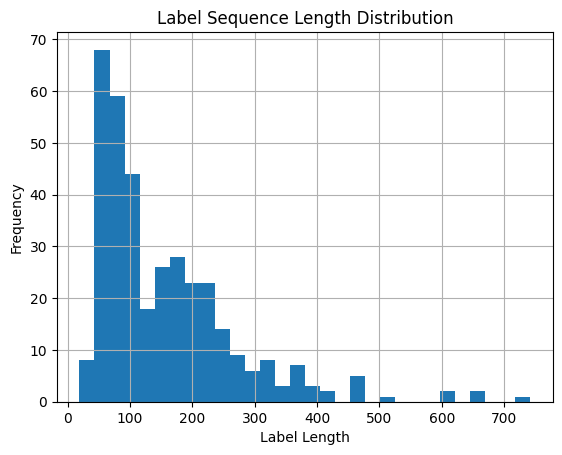

In [18]:
import matplotlib.pyplot as plt

lengths = []
for file in os.listdir(DATA_DIR):
    data = np.load(os.path.join(DATA_DIR, file))
    label = data["label"]
    lengths.append(len(label))

plt.hist(lengths, bins=30)
plt.title("Label Sequence Length Distribution")
plt.xlabel("Label Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [19]:
print(f"Ortalama: {np.mean(lengths):.2f}, Medyan: {np.median(lengths)}, Min: {np.min(lengths)}, Max: {np.max(lengths)}")

Ortalama: 155.64, Medyan: 118.5, Min: 19, Max: 742


In [20]:
all_labels = []
for file in os.listdir(DATA_DIR):
    data = np.load(os.path.join(DATA_DIR, file))
    all_labels.extend(data["label"].tolist())

print("📊 Benzersiz sınıflar:", sorted(set(all_labels)))

📊 Benzersiz sınıflar: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]


In [21]:
for i in range(5):
    print(f"\n📦 Sample {i+1}")
    print("🎯 Target :", val_targets[i])
    print("🤖 Decoded:", val_preds[i])


📦 Sample 1
🎯 Target : [10, 17, 22, 17, 10, 17, 20, 10, 17, 22, 10, 17, 22, 10, 17, 22, 10, 17, 22, 10, 17, 10, 17, 20, 10, 17, 22, 10, 17, 10, 17, 22, 10, 17, 10, 17, 22, 10, 17, 20, 17, 22, 10, 17, 29, 10, 17, 22, 10, 17, 20, 17, 22, 1, 10, 3, 10, 3, 10, 13, 3, 10, 13, 19, 3, 10, 15, 19, 22, 13, 10, 19, 3, 10, 13, 3, 10, 3, 10, 15, 19, 3, 10, 15, 3, 10, 13, 19, 1, 11, 10, 17, 10, 17, 22, 24, 22, 24, 10, 17, 20, 10, 17, 10, 17, 22, 10, 17, 22, 10, 17, 10, 17, 22, 17, 22, 10, 17, 20, 10, 17, 22, 5, 10, 5, 12, 5, 12, 5, 12, 15, 21, 24, 5, 12, 5, 12, 15, 21, 1, 3, 10, 3, 10, 3, 10, 13, 19, 22, 10, 3, 10, 13, 19, 22, 11, 10, 17, 22, 17, 10, 20, 10, 17, 10, 17, 22, 10, 17, 22, 10, 17, 22, 10, 17, 10, 17, 22, 10, 17, 20, 10, 17, 10, 17, 22, 10, 17, 22]
🤖 Decoded: [42, 23, 17, 42]

📦 Sample 2
🎯 Target : [27, 18, 23, 8, 18, 23, 27, 8, 18, 23, 27, 8, 18, 23, 27, 22, 13, 23, 17, 27, 13, 17, 23, 27, 13, 17, 23, 27, 13, 17, 23, 27, 21, 16, 22, 6, 16, 22, 25, 6, 16, 22, 25, 6, 16, 22, 25, 22, 25, 

In [22]:
logits = model(mels[:1].to(device))  # örnek bir inputla
print("Logits shape:", logits.shape)
print("Min/Max logit:", logits.min().item(), logits.max().item())

Logits shape: torch.Size([1412, 1, 43])
Min/Max logit: -17.993989944458008 13.485800743103027


In [23]:
from collections import Counter
print(Counter([label for seq in val_preds for label in seq]))

Counter({42: 90, 7: 12, 17: 9, 18: 8, 25: 8, 20: 8, 22: 6, 10: 6, 28: 6, 23: 5, 24: 5, 21: 5, 8: 5, 13: 5, 26: 4, 12: 4, 1: 3, 14: 3, 9: 3, 31: 3, 27: 2, 34: 2, 30: 2, 19: 2, 4: 2, 11: 2, 33: 2, 6: 1, 32: 1, 16: 1, 35: 1})


greedy decoder'a geri dön

belki greedy ile birlikte cnn_ctc_bilstm kullanılabilir.

In [24]:
import matplotlib.pyplot as plt

def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(15, 5))

    # Train / Val Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Sequence Similarity
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['val_sim'], label='Sequence Similarity')
    plt.xlabel('Epoch')
    plt.ylabel('Similarity')
    plt.title('Val Sequence Similarity')
    plt.legend()

    # Token Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['val_token_acc'], label='Token Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Val Token Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

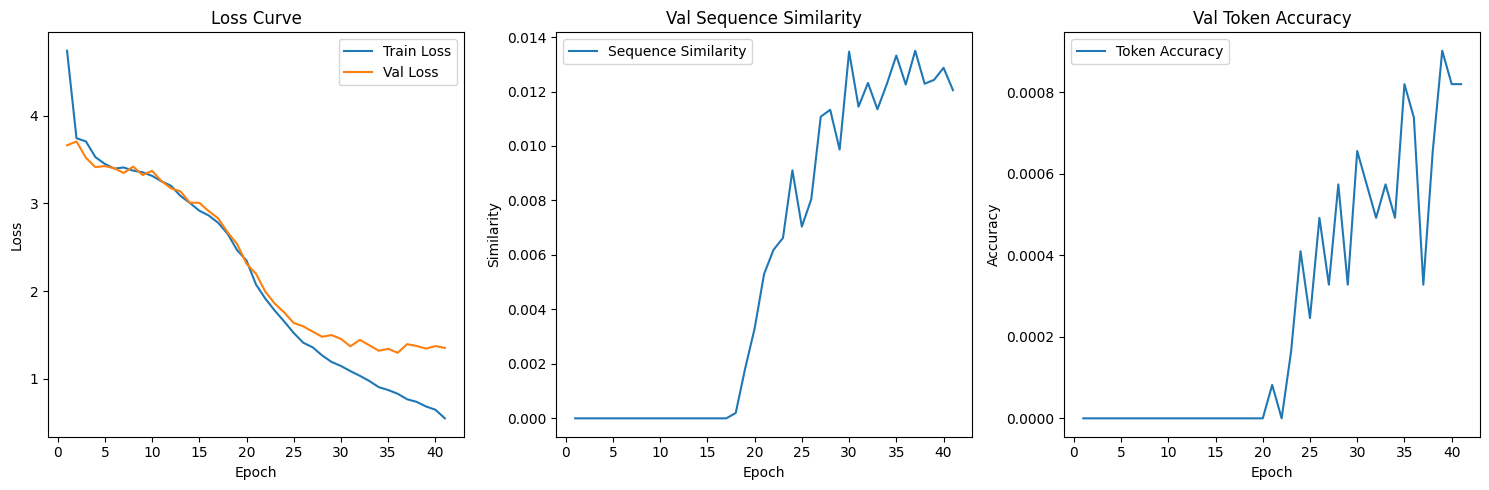

In [25]:
plot_history(history)